# Edinburgh Modellig

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy.stats import gaussian_kde
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
%config InlineBackend.figure_format = 'retina'
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.font_manager as fm
import xgboost as xgb
import shap
from scipy.spatial import cKDTree

# Load Cambria font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf"  # Adjust path if needed
cambria_prop = fm.FontProperties(fname=cambria_path)

# Load modelling functions
import sys
sys.path.append('../../scripts')  # go up one folder, into scripts/

from modelling import (
    prepare_data,
    run_modelling_pipeline,
    map_gwr_coefficients,
    calculate_t_values,
    categorise_significance,
    plot_significance,
    geographically_weighted_rf
)

## 1. Import Data

In [36]:
# Import data
edinburgh_airbnb = gpd.read_file('../../data/edinburgh/airbnb_per_edinburgh_glx.gpkg')
edinburgh_tourism_fs = gpd.read_file('../../data/edinburgh/edinburgh_glx_tourism_pois.gpkg')

In [37]:
# Merge the two datasets on glx_id keeping only one geometry column
edinburgh_airbnb_tourism_fs = edinburgh_tourism_fs.merge(edinburgh_airbnb, on='glx_id', how='left')

# Drop geometry_x and rename geometry_y to geometry
edinburgh_airbnb_tourism_fs.drop(columns=['geometry_x'], inplace=True)
edinburgh_airbnb_tourism_fs.rename(columns={'geometry_y': 'geometry'}, inplace=True)

In [38]:
# Create total_pois_log column
edinburgh_airbnb_tourism_fs['total_pois_log'] = np.log1p(edinburgh_airbnb_tourism_fs['total_pois'])

In [39]:
# Import Edinburgh GLX shapefile
edinburgh_glx = gpd.read_file("../../data/edinburgh/edinburgh_seamless.gpkg")
edinburgh_glx = edinburgh_glx.to_crs(epsg=27700)

## 2. Data Exploration

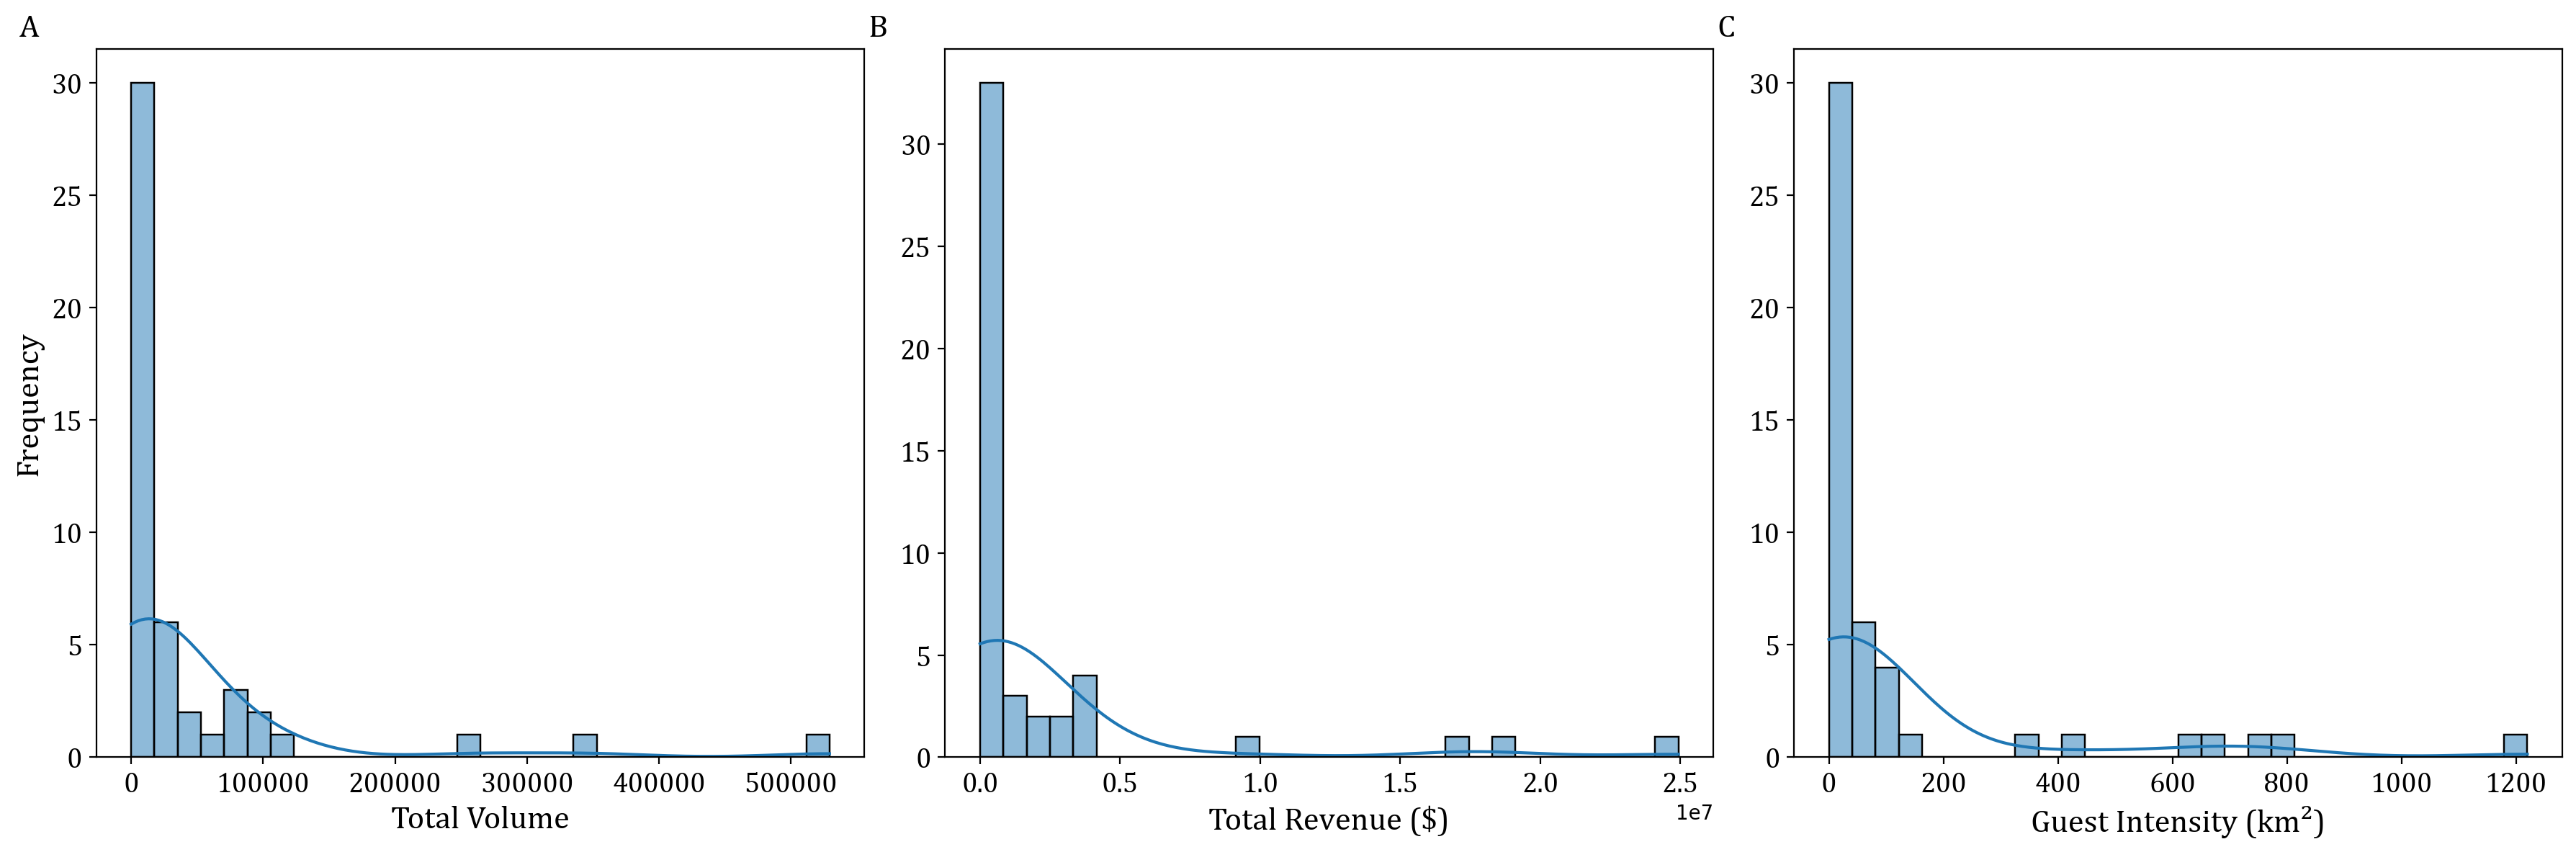

In [40]:
# Create plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Total Volume
sns.histplot(edinburgh_airbnb_tourism_fs['total_volume'], bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel('Total Volume', fontproperties=cambria_prop, size=16)
axes[0].set_ylabel('Frequency', fontproperties=cambria_prop, size=16)

# Plot 2: Total Revenue
sns.histplot(edinburgh_airbnb_tourism_fs['total_revenue'], bins=30, kde=True, ax=axes[1])
axes[1].set_xlabel('Total Revenue ($)', fontproperties=cambria_prop, size=16)
axes[1].set_ylabel('', fontproperties=cambria_prop)

# Plot 3: Tourism Intensity
sns.histplot(edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2'], bins=30, kde=True, ax=axes[2])
axes[2].set_xlabel('Guest Intensity (km²)', fontproperties=cambria_prop, size=16)
axes[2].set_ylabel('', fontproperties=cambria_prop)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(14)

plt.tight_layout()
plt.savefig('../../results/edinburgh/airbnb_feature_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
edinburgh_airbnb_tourism_fs.columns.tolist()

['glx_id',
 'air_travel',
 'arts_other',
 'bars_nightlife',
 'cafes_bakeries',
 'cultural_institution',
 'dining_other',
 'entertainment_nightlife',
 'event_space',
 'fast_food',
 'food_drink_production',
 'full_service_restaurant',
 'high_end_dining',
 'historic_landmark',
 'leisure_activity_centre',
 'local_public_transit',
 'lodging',
 'major_attraction',
 'major_transit_hub',
 'mobility_services',
 'music_cinema_venue',
 'nature_trail',
 'outdoors_other',
 'park_garden',
 'public_art',
 'public_plaza_square',
 'retail_books_hobbies',
 'retail_fashion_apparel',
 'retail_food_beverage',
 'retail_gifts_misc',
 'retail_health_beauty',
 'retail_home_electronics',
 'retail_luxury',
 'retail_markets_plazas',
 'retail_other',
 'rural_agricultural',
 'tourism_services',
 'transport_infrastructure',
 'travel_other',
 'waterfront_river',
 'total_pois',
 'comb_name',
 'area_km2',
 'air_travel_density',
 'arts_other_density',
 'bars_nightlife_density',
 'cafes_bakeries_density',
 'cultural_inst

In [42]:
# Define the non-logged features
features = [
    'air_travel_density',
    'arts_other_density',
    'bars_nightlife_density',
    'cafes_bakeries_density',
    'cultural_institution_density',
    'dining_other_density',
    'entertainment_nightlife_density',
    'event_space_density',
    'fast_food_density',
    'food_drink_production_density',
    'full_service_restaurant_density',
    'high_end_dining_density',
    'historic_landmark_density',
    'leisure_activity_centre_density',
    'local_public_transit_density',
    'lodging_density',
    'major_attraction_density',
    'major_transit_hub_density',
    'mobility_services_density',
    'music_cinema_venue_density',
    'nature_trail_density',
    'outdoors_other_density',
    'park_garden_density',
    'public_art_density',
    'public_plaza_square_density',
    'retail_books_hobbies_density',
    'retail_fashion_apparel_density',
    'retail_food_beverage_density',
    'retail_gifts_misc_density',
    'retail_health_beauty_density',
    'retail_home_electronics_density',
    'retail_luxury_density',
    'retail_markets_plazas_density',
    'retail_other_density',
    'rural_agricultural_density',
    'tourism_services_density',
    'transport_infrastructure_density',
    'travel_other_density',
    'waterfront_river_density'
    ]

# Define the logged features
features_logged = [
    'air_travel_density_log',
    'arts_other_density_log',
    'bars_nightlife_density_log',
    'cafes_bakeries_density_log',
    'cultural_institution_density_log',
    'dining_other_density_log',
    'entertainment_nightlife_density_log',
    'event_space_density_log',
    'fast_food_density_log',
    'food_drink_production_density_log',
    'full_service_restaurant_density_log',
    'high_end_dining_density_log',
    'historic_landmark_density_log',
    'leisure_activity_centre_density_log',
    'local_public_transit_density_log',
    'lodging_density_log',
    'major_attraction_density_log',
    'major_transit_hub_density_log',
    'mobility_services_density_log',
    'music_cinema_venue_density_log',
    'nature_trail_density_log',
    'outdoors_other_density_log',
    'park_garden_density_log',
    'public_art_density_log',
    'public_plaza_square_density_log',
    'retail_books_hobbies_density_log',
    'retail_fashion_apparel_density_log',
    'retail_food_beverage_density_log',
    'retail_gifts_misc_density_log',
    'retail_health_beauty_density_log',
    'retail_home_electronics_density_log',
    'retail_luxury_density_log',
    'retail_markets_plazas_density_log',
    'retail_other_density_log',
    'rural_agricultural_density_log',
    'tourism_services_density_log',
    'transport_infrastructure_density_log',
    'travel_other_density_log',
    'waterfront_river_density_log'
]

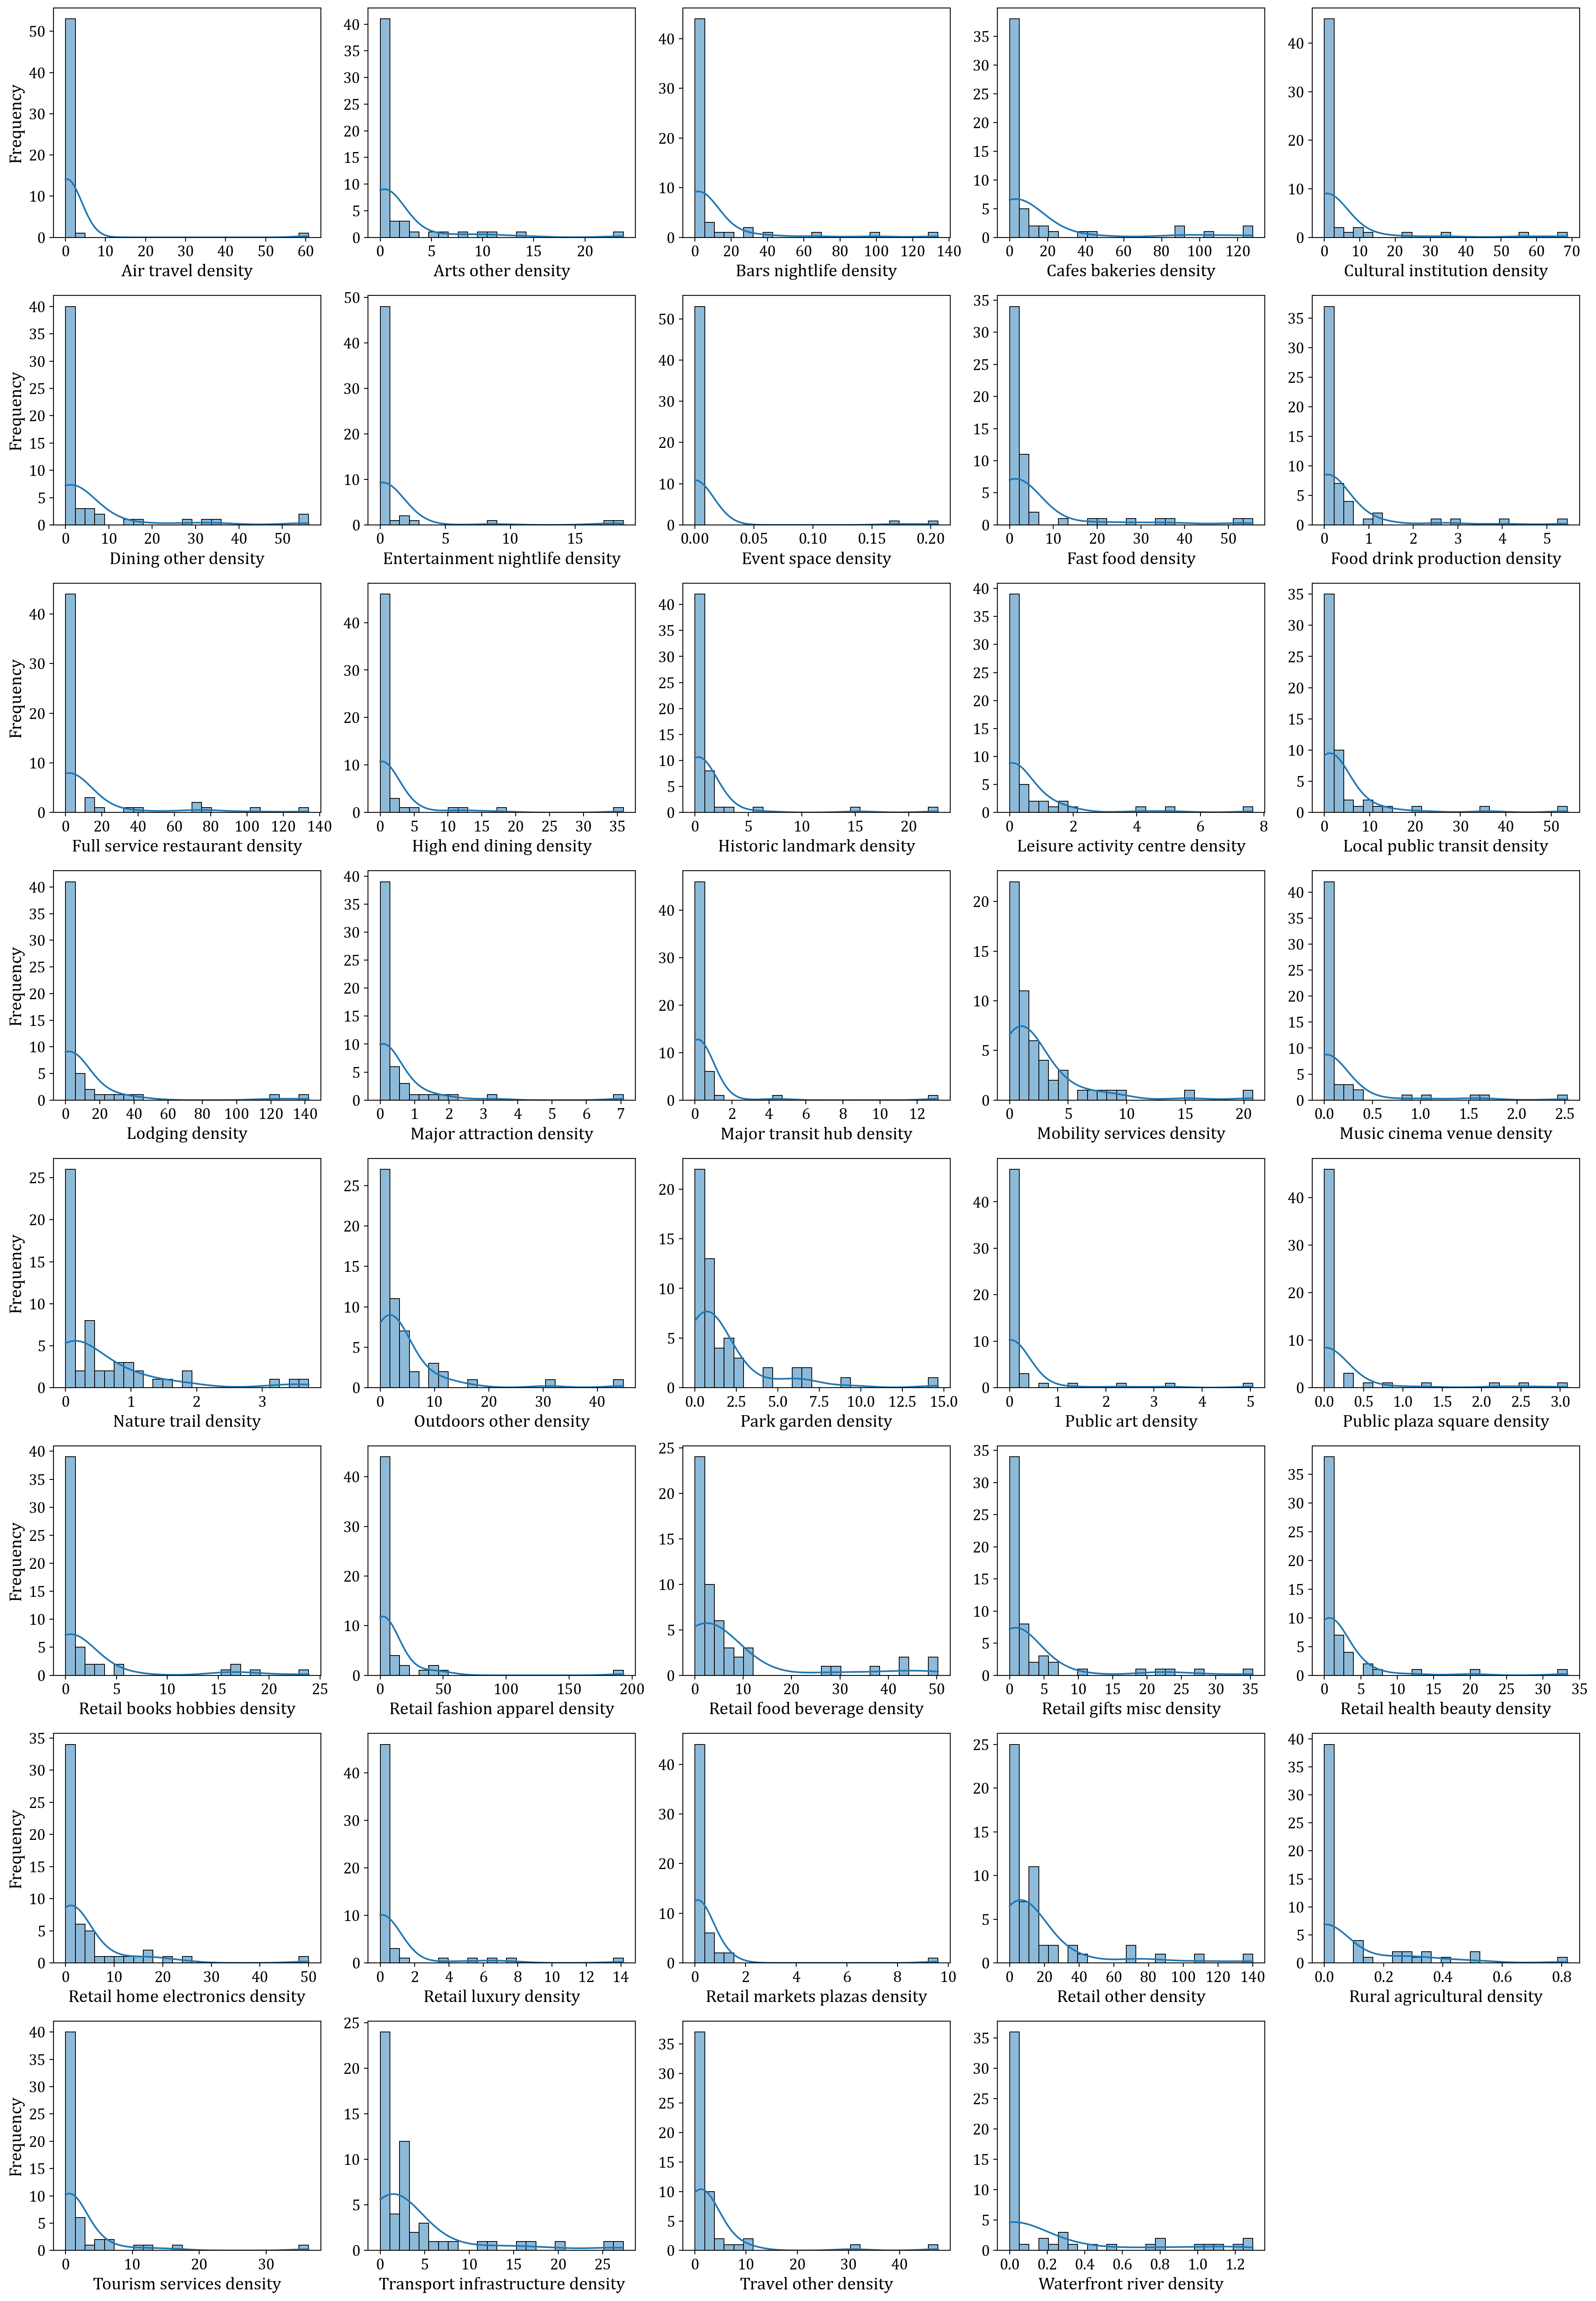

In [43]:
# For all features, create histograms to check for normality and put into a single figure and hide empty subplots
n_rows, n_cols = 14, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(edinburgh_airbnb_tourism_fs[feature], bins=25, kde=True, ax=axes[i])
    axes[i].set_xlabel(
        axes[i].get_xlabel().replace('_', ' ').replace('density', 'Density').capitalize(),
        fontproperties=cambria_prop, size=16
    )

    # Only show y-axis label on first column of each row
    if i % n_cols == 0:
        axes[i].set_ylabel('Frequency', fontproperties=cambria_prop, size = 16)
    else:
        axes[i].set_ylabel('')  # Remove y-axis label

    axes[i].grid(False)

    # Set font for tick labels
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(14)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('../../results/edinburgh/feature_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

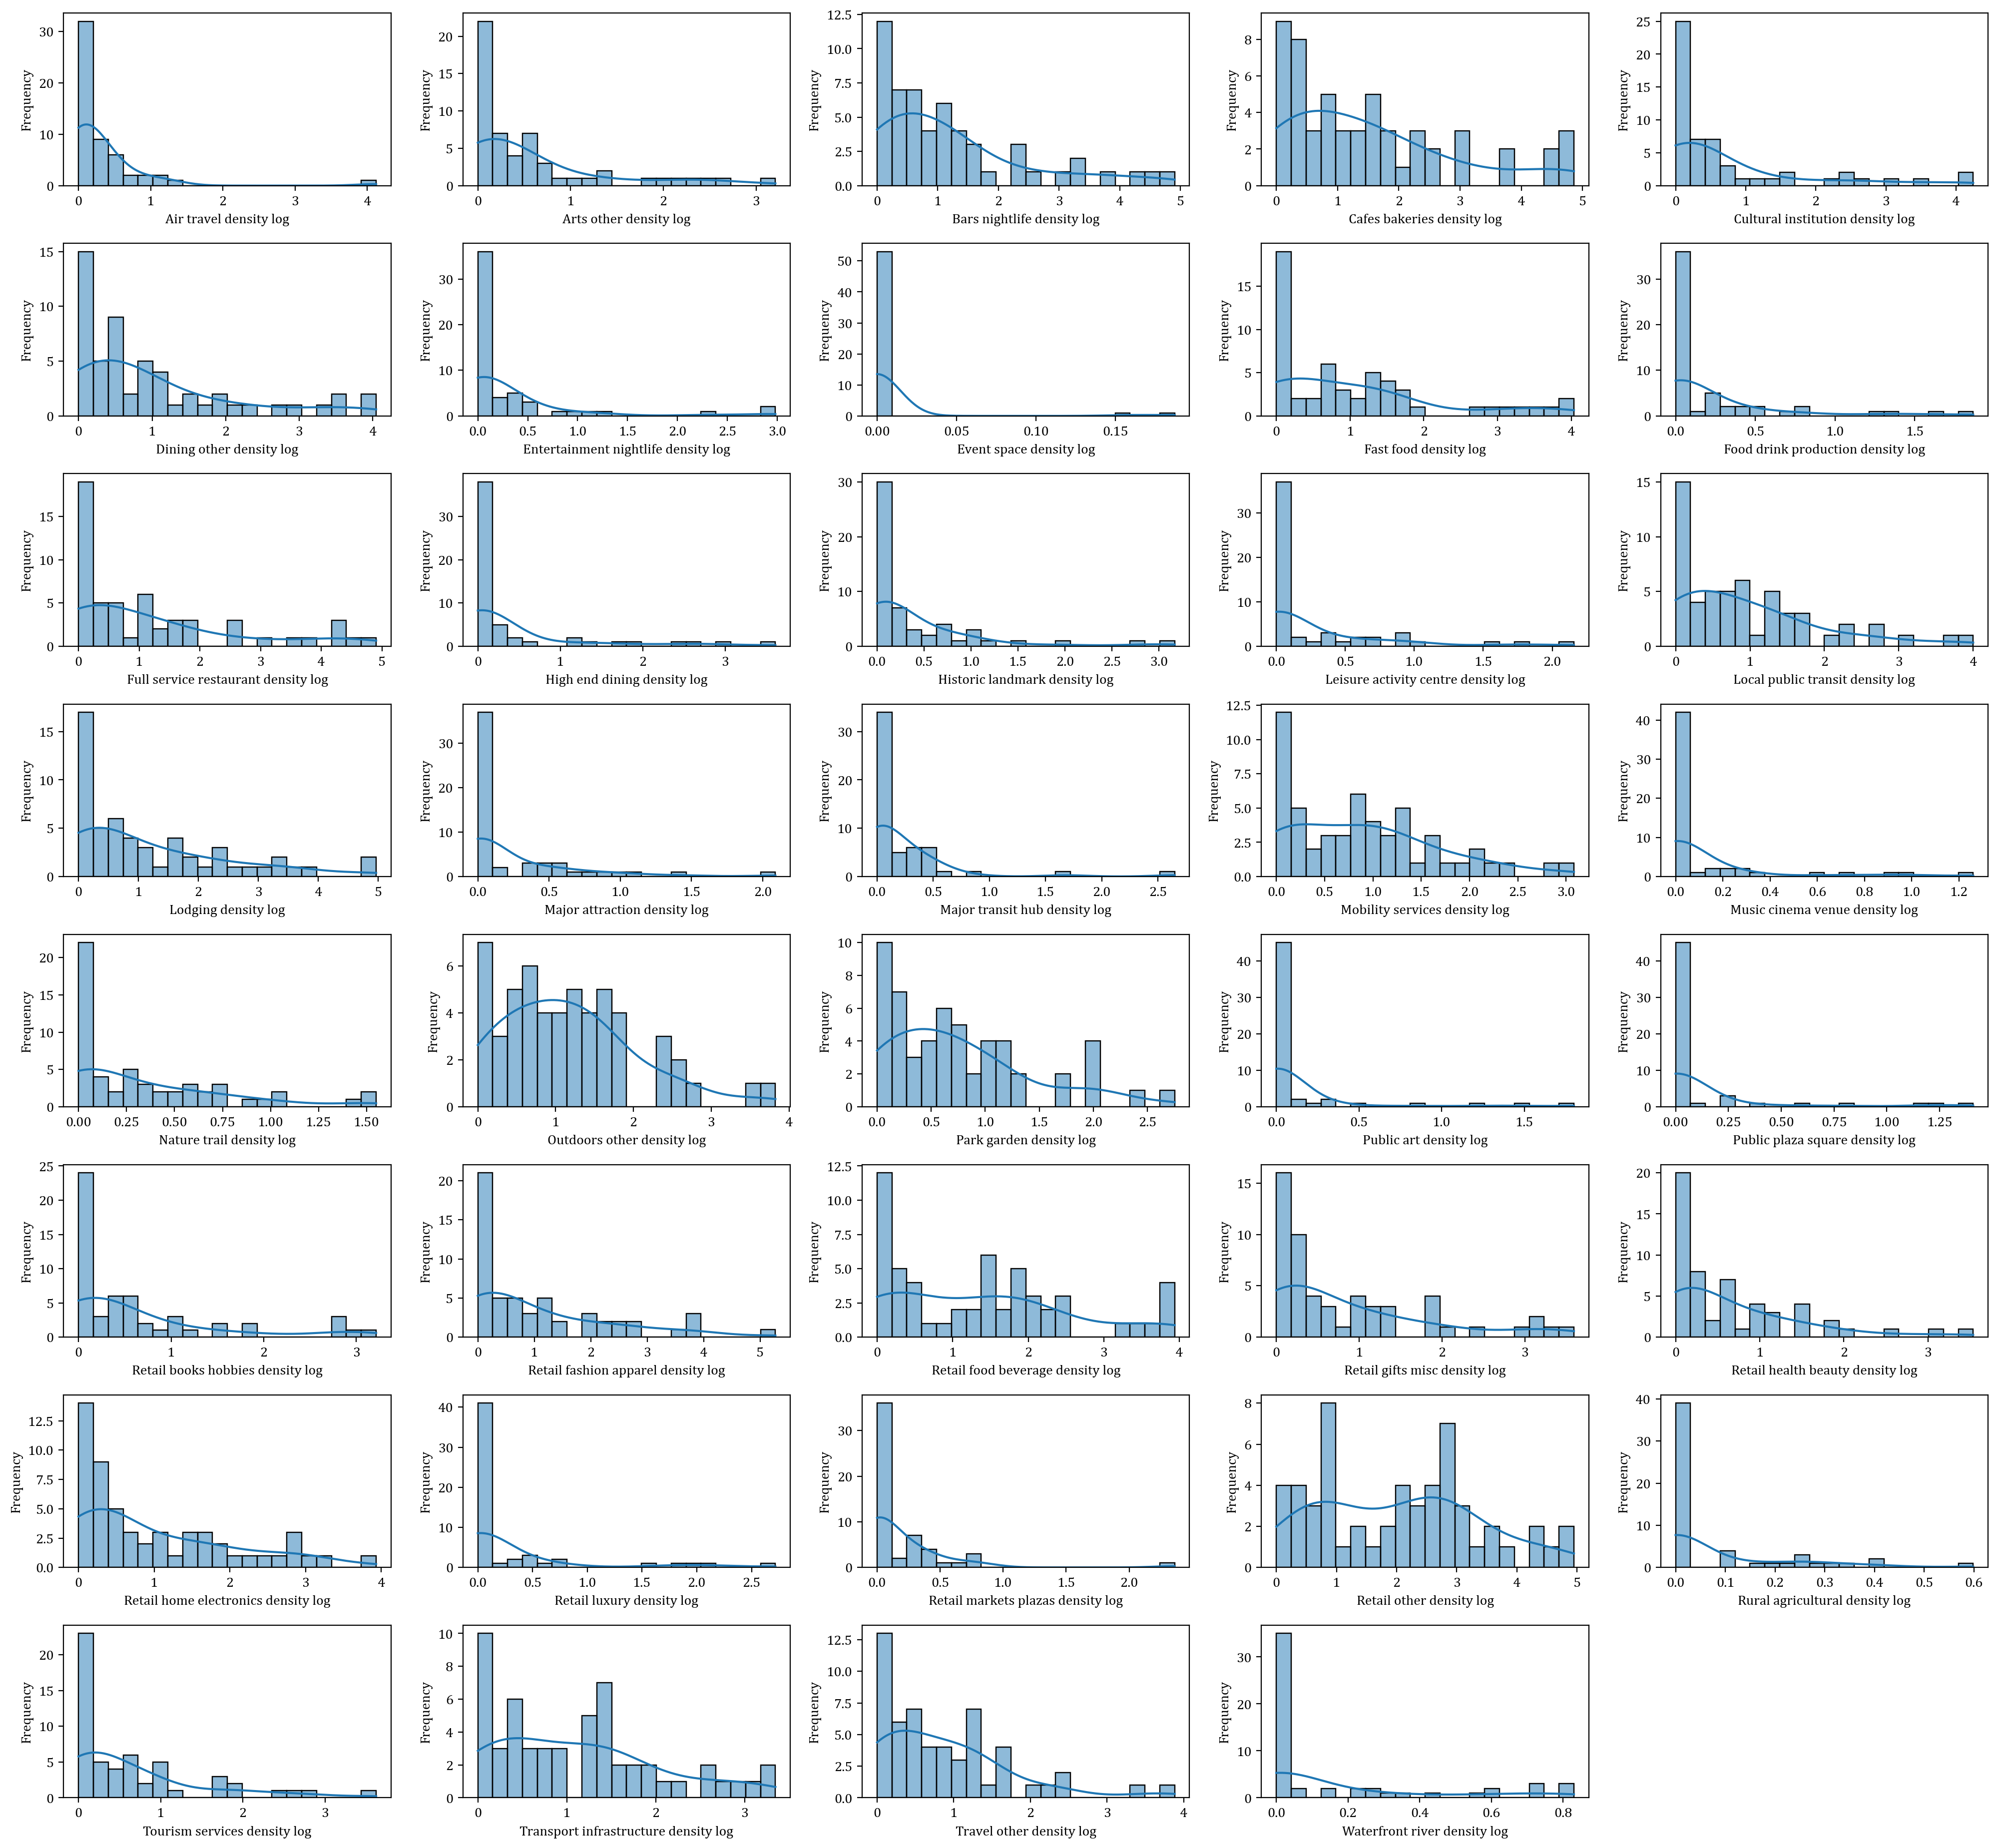

In [44]:
# For all features, create histograms to check for normality and put into a single figure and hide empty subplots
fig, axes = plt.subplots(14, 5, figsize=(20, 32))
axes = axes.flatten()
for i, feature in enumerate(features_logged):
    sns.histplot(edinburgh_airbnb_tourism_fs[feature], bins=20, kde=True, ax=axes[i])
    axes[i].set_xlabel(axes[i].get_xlabel().replace('_', ' ').replace('density_log', 'Density (per km²) (log)').capitalize(), fontproperties=cambria_prop)
    axes[i].set_ylabel('Frequency', fontproperties=cambria_prop)
    axes[i].grid(False)
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontproperties(cambria_prop)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show();

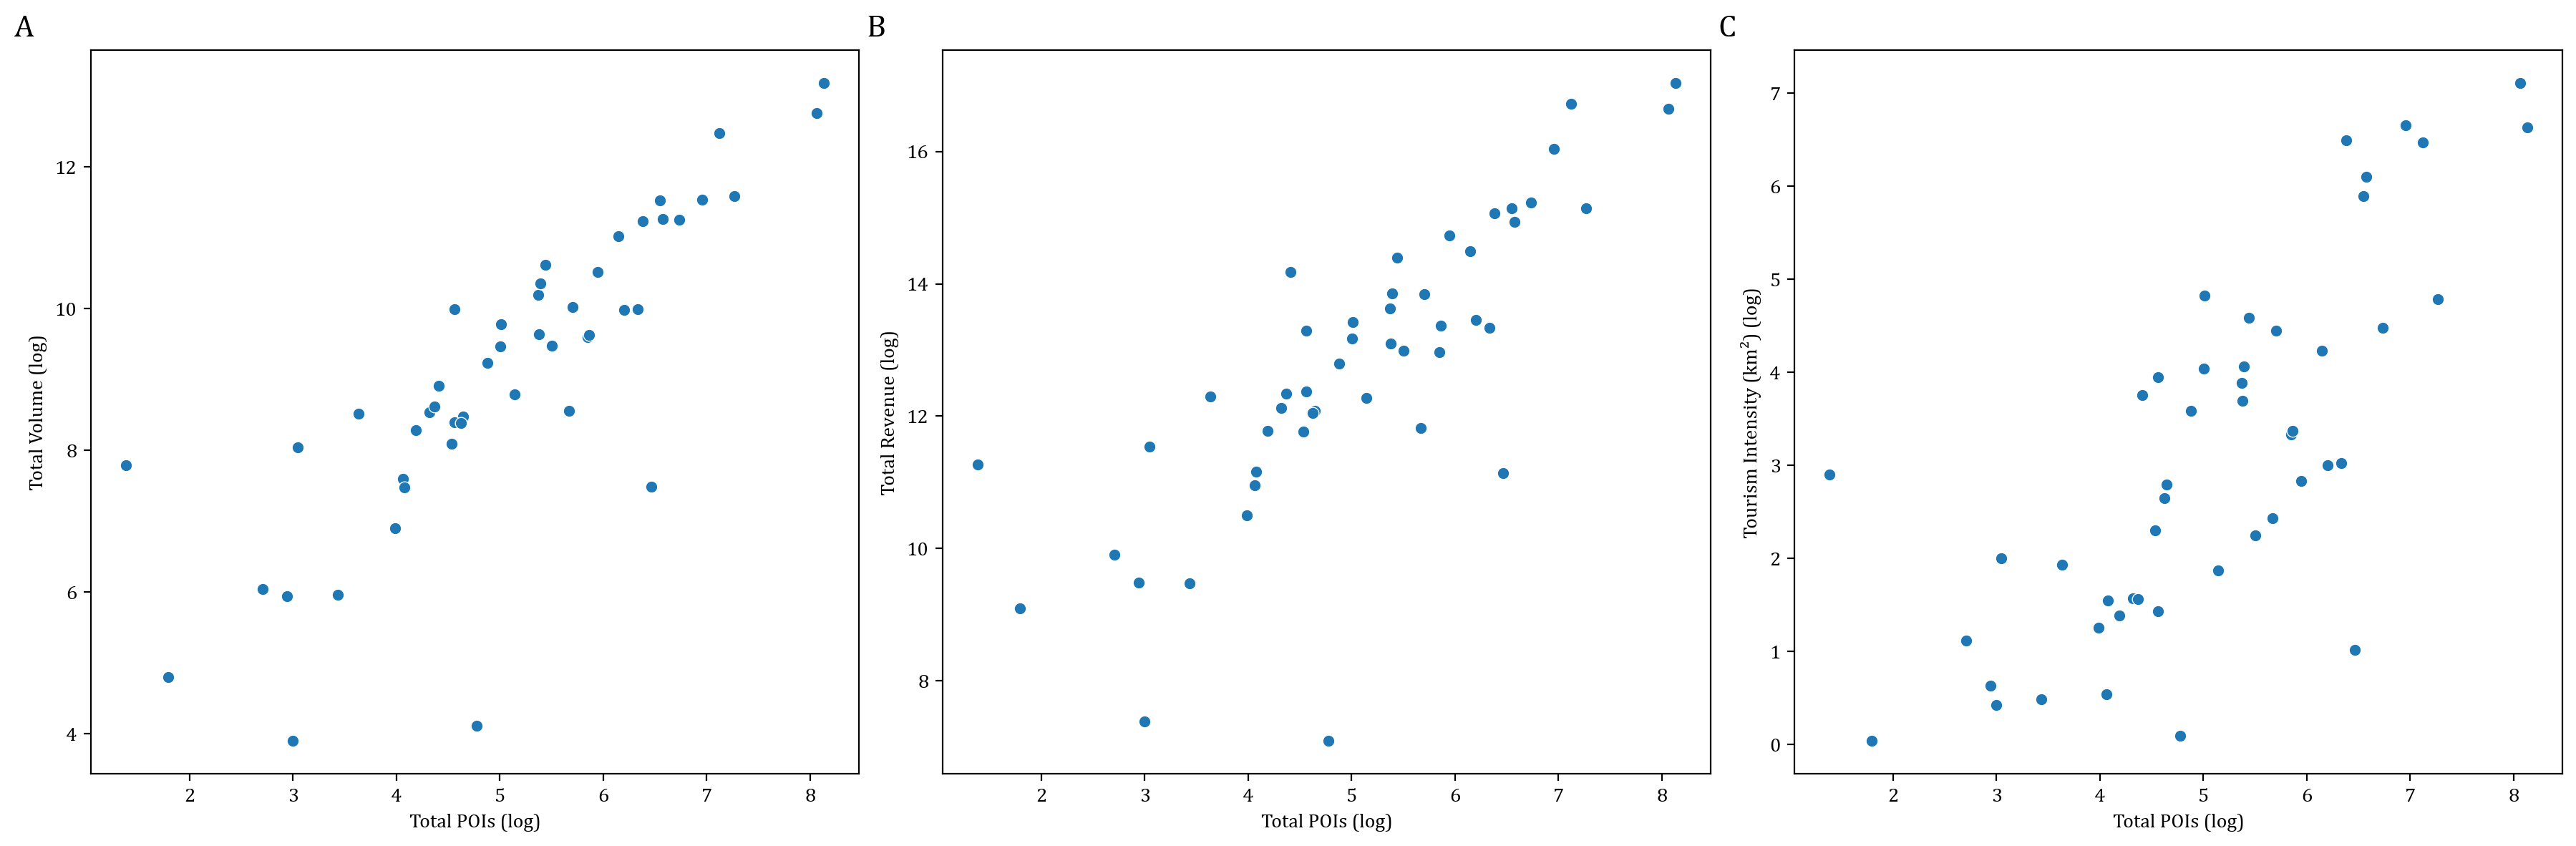

In [45]:
# Create three scatter plots showing total_pois vs, total_volume, total_revenue, and total_tourism_intensity_km2
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_volume_log', ax=axes[0])
axes[0].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[0].set_ylabel('Total Volume (log)', fontproperties=cambria_prop)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_revenue_log', ax=axes[1])
axes[1].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[1].set_ylabel('Total Revenue (log)', fontproperties=cambria_prop)

sns.scatterplot(data=edinburgh_airbnb_tourism_fs, x='total_pois_log', y='total_tourism_intensity_km2_log', ax=axes[2])
axes[2].set_xlabel('Total POIs (log)', fontproperties=cambria_prop)
axes[2].set_ylabel('Tourism Intensity (km²) (log)', fontproperties=cambria_prop)

# Add A–C panel tags
panel_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(
        -0.1, 1.05,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=16,
        fontproperties=cambria_prop,
        fontweight='bold',
        va='top',
        ha='left'
    ),
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()


## 3. Random Forest
### Total Revenue

Analysing: Total Revenue ($)
Data prepared for target: 'total_revenue_log'
Number of features: 39
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.64
Baseline MAE (log): 1.326
Baseline RMSE (log): 1.456
Baseline MAE (original): 5,314,434.25
Baseline RMSE (original): 9,162,770.33

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None}
Tuned R-squared (R²): 0.62
Tuned MAE (log): 1.370
Tuned RMSE (log): 1.481
Tuned MAE (original): 5,456,148.20
Tuned RMSE (original): 9,386,079.09


/Users/elisdavies/Documents/University_of_Liverpool/MSc Geographic Data Science/ENVS492 - Dissertation/POI-and-STR-Guest-Modelling/notebooks/edinburgh/../../scripts/modelling.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")


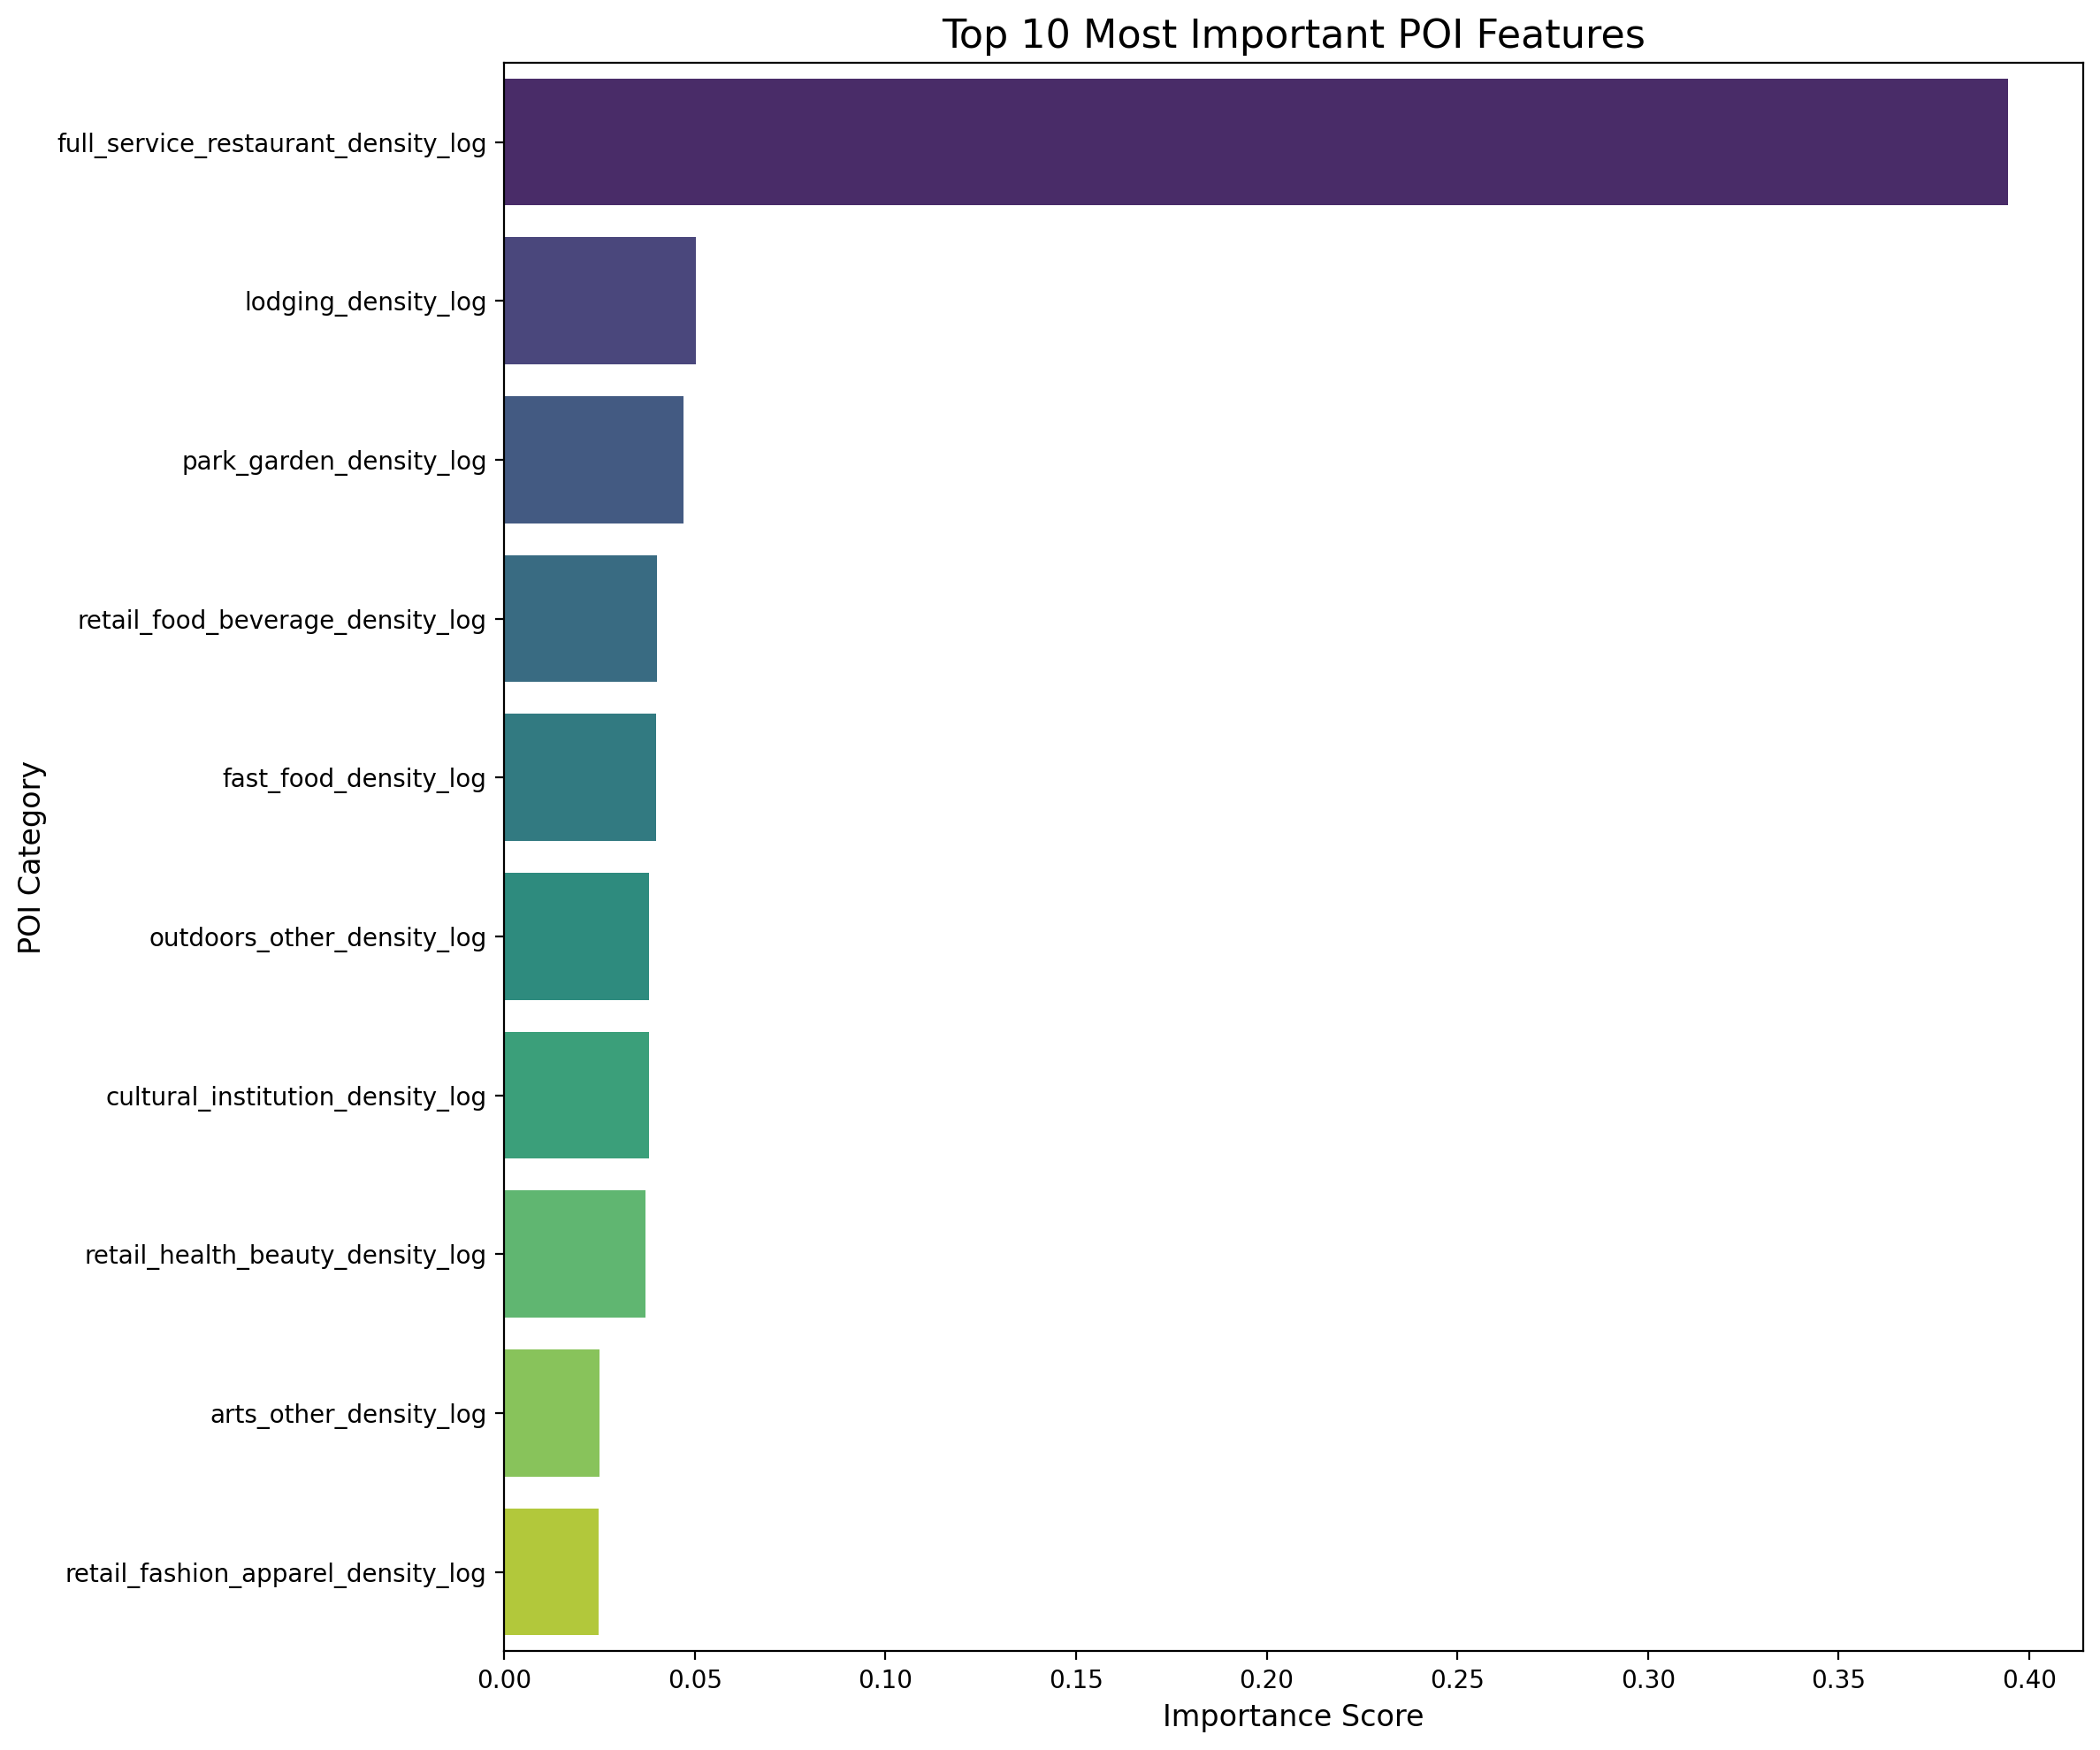


--- Top 10 Most Important Features ---
full_service_restaurant_density_log    0.394399
lodging_density_log                    0.050175
park_garden_density_log                0.047058
retail_food_beverage_density_log       0.040144
fast_food_density_log                  0.039772
outdoors_other_density_log             0.038015
cultural_institution_density_log       0.037979
retail_health_beauty_density_log       0.037058
arts_other_density_log                 0.025026
retail_fashion_apparel_density_log     0.024794
dtype: float64


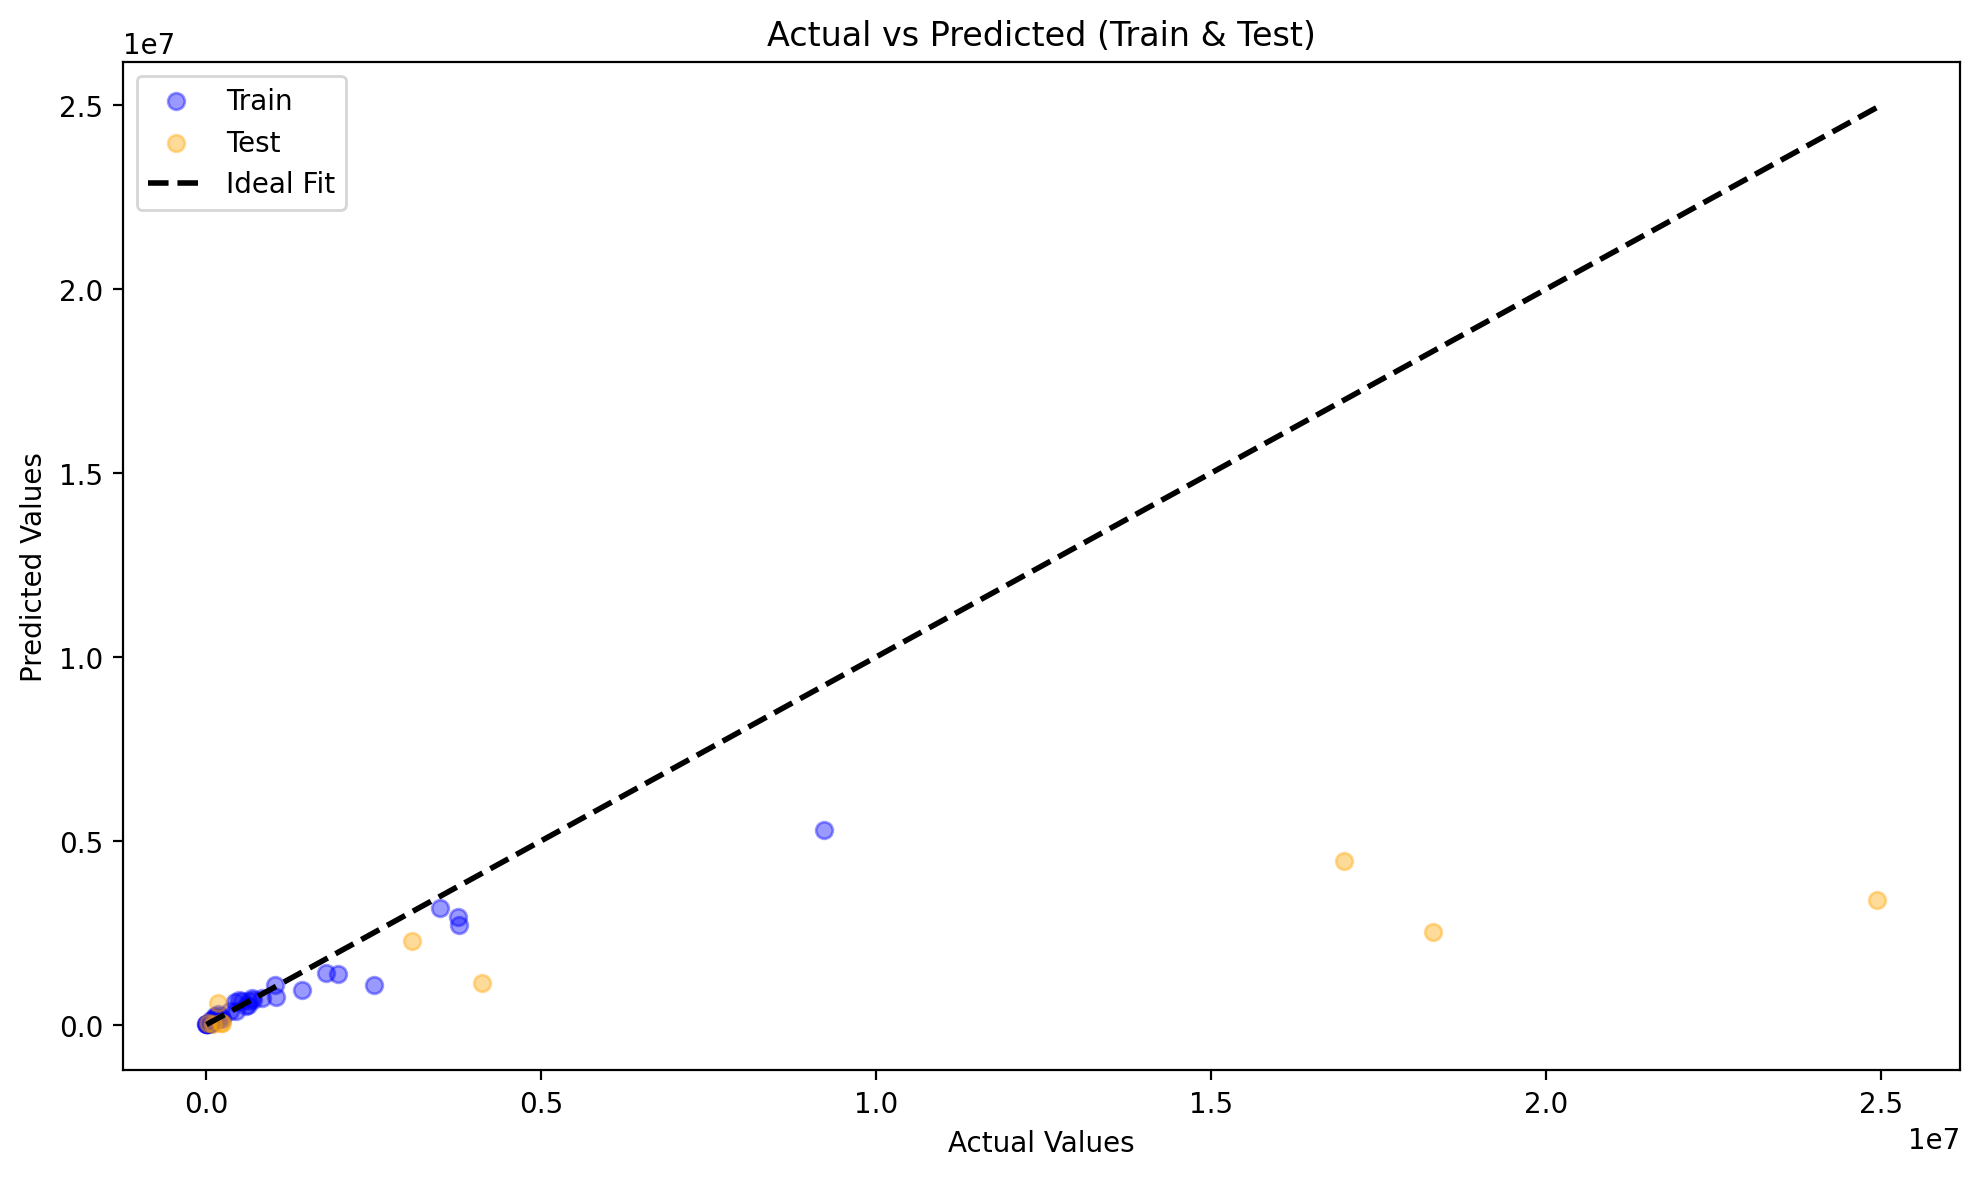

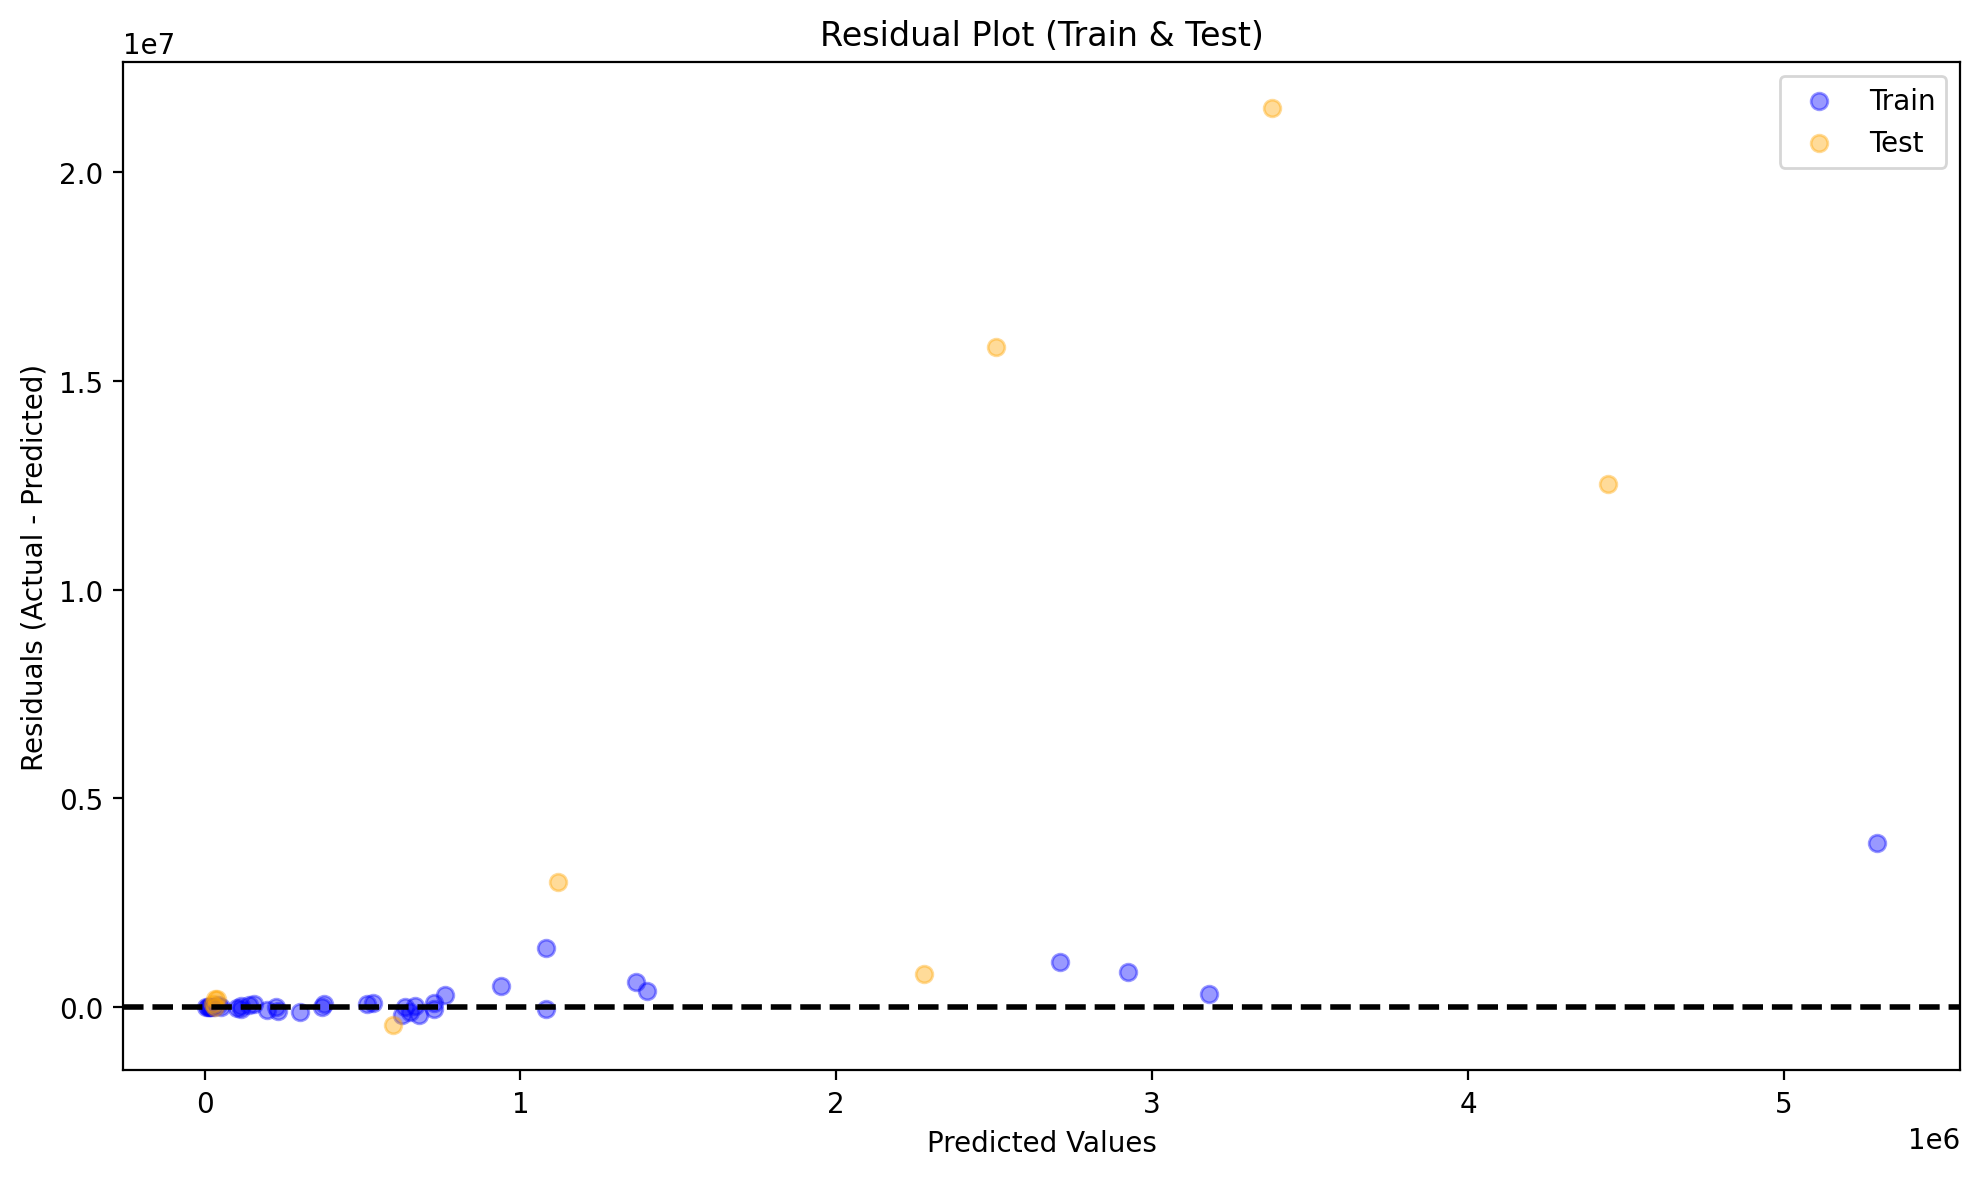

In [46]:
print("=" * 50)
print("Analysing: Total Revenue ($)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_revenue_log')
# Run the modelling pipeline
revenue_model, revenue_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_revenue'])

### Total Volume

Analysing: Total Volume (number of guests)
Data prepared for target: 'total_volume_log'
Number of features: 39
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.61
Baseline MAE (log): 1.317
Baseline RMSE (log): 1.435
Baseline MAE (original): 100,950.42
Baseline RMSE (original): 176,833.35

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': 30}
Tuned R-squared (R²): 0.50
Tuned MAE (log): 1.503
Tuned RMSE (log): 1.626
Tuned MAE (original): 107,748.99
Tuned RMSE (original): 188,243.78


/Users/elisdavies/Documents/University_of_Liverpool/MSc Geographic Data Science/ENVS492 - Dissertation/POI-and-STR-Guest-Modelling/notebooks/edinburgh/../../scripts/modelling.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")


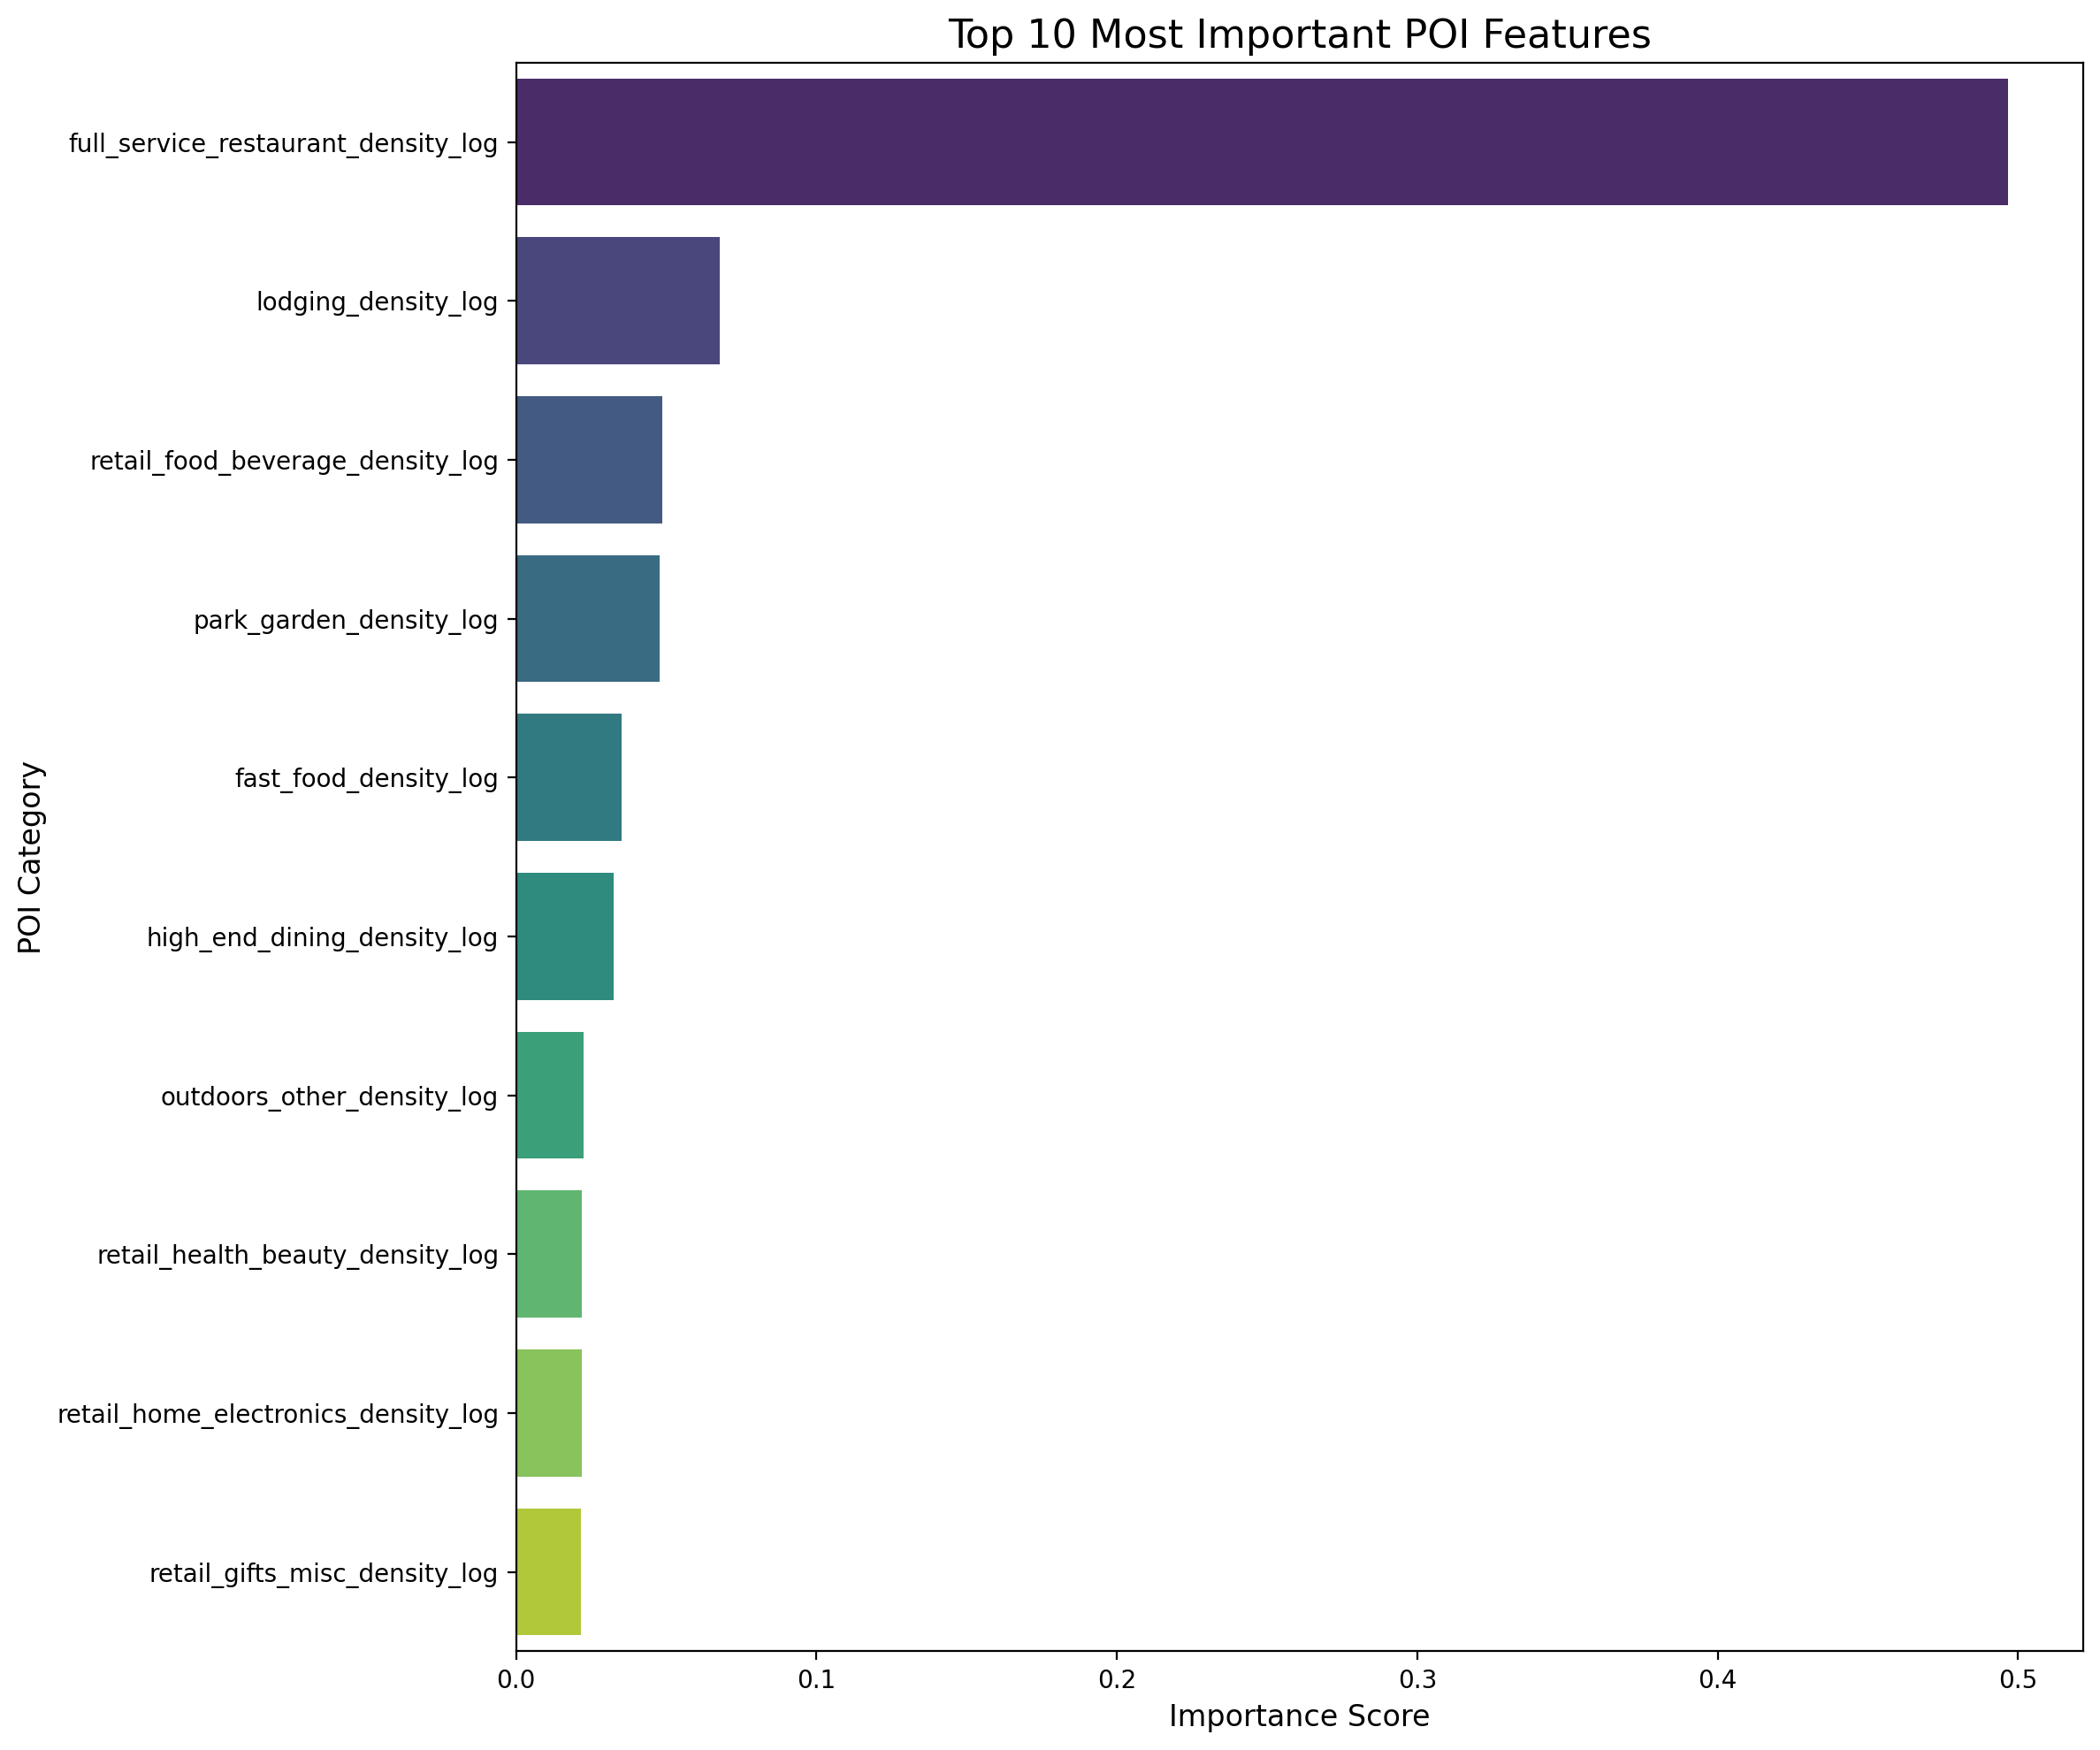


--- Top 10 Most Important Features ---
full_service_restaurant_density_log    0.496832
lodging_density_log                    0.067654
retail_food_beverage_density_log       0.048551
park_garden_density_log                0.047870
fast_food_density_log                  0.035225
high_end_dining_density_log            0.032449
outdoors_other_density_log             0.022537
retail_health_beauty_density_log       0.022021
retail_home_electronics_density_log    0.021757
retail_gifts_misc_density_log          0.021579
dtype: float64


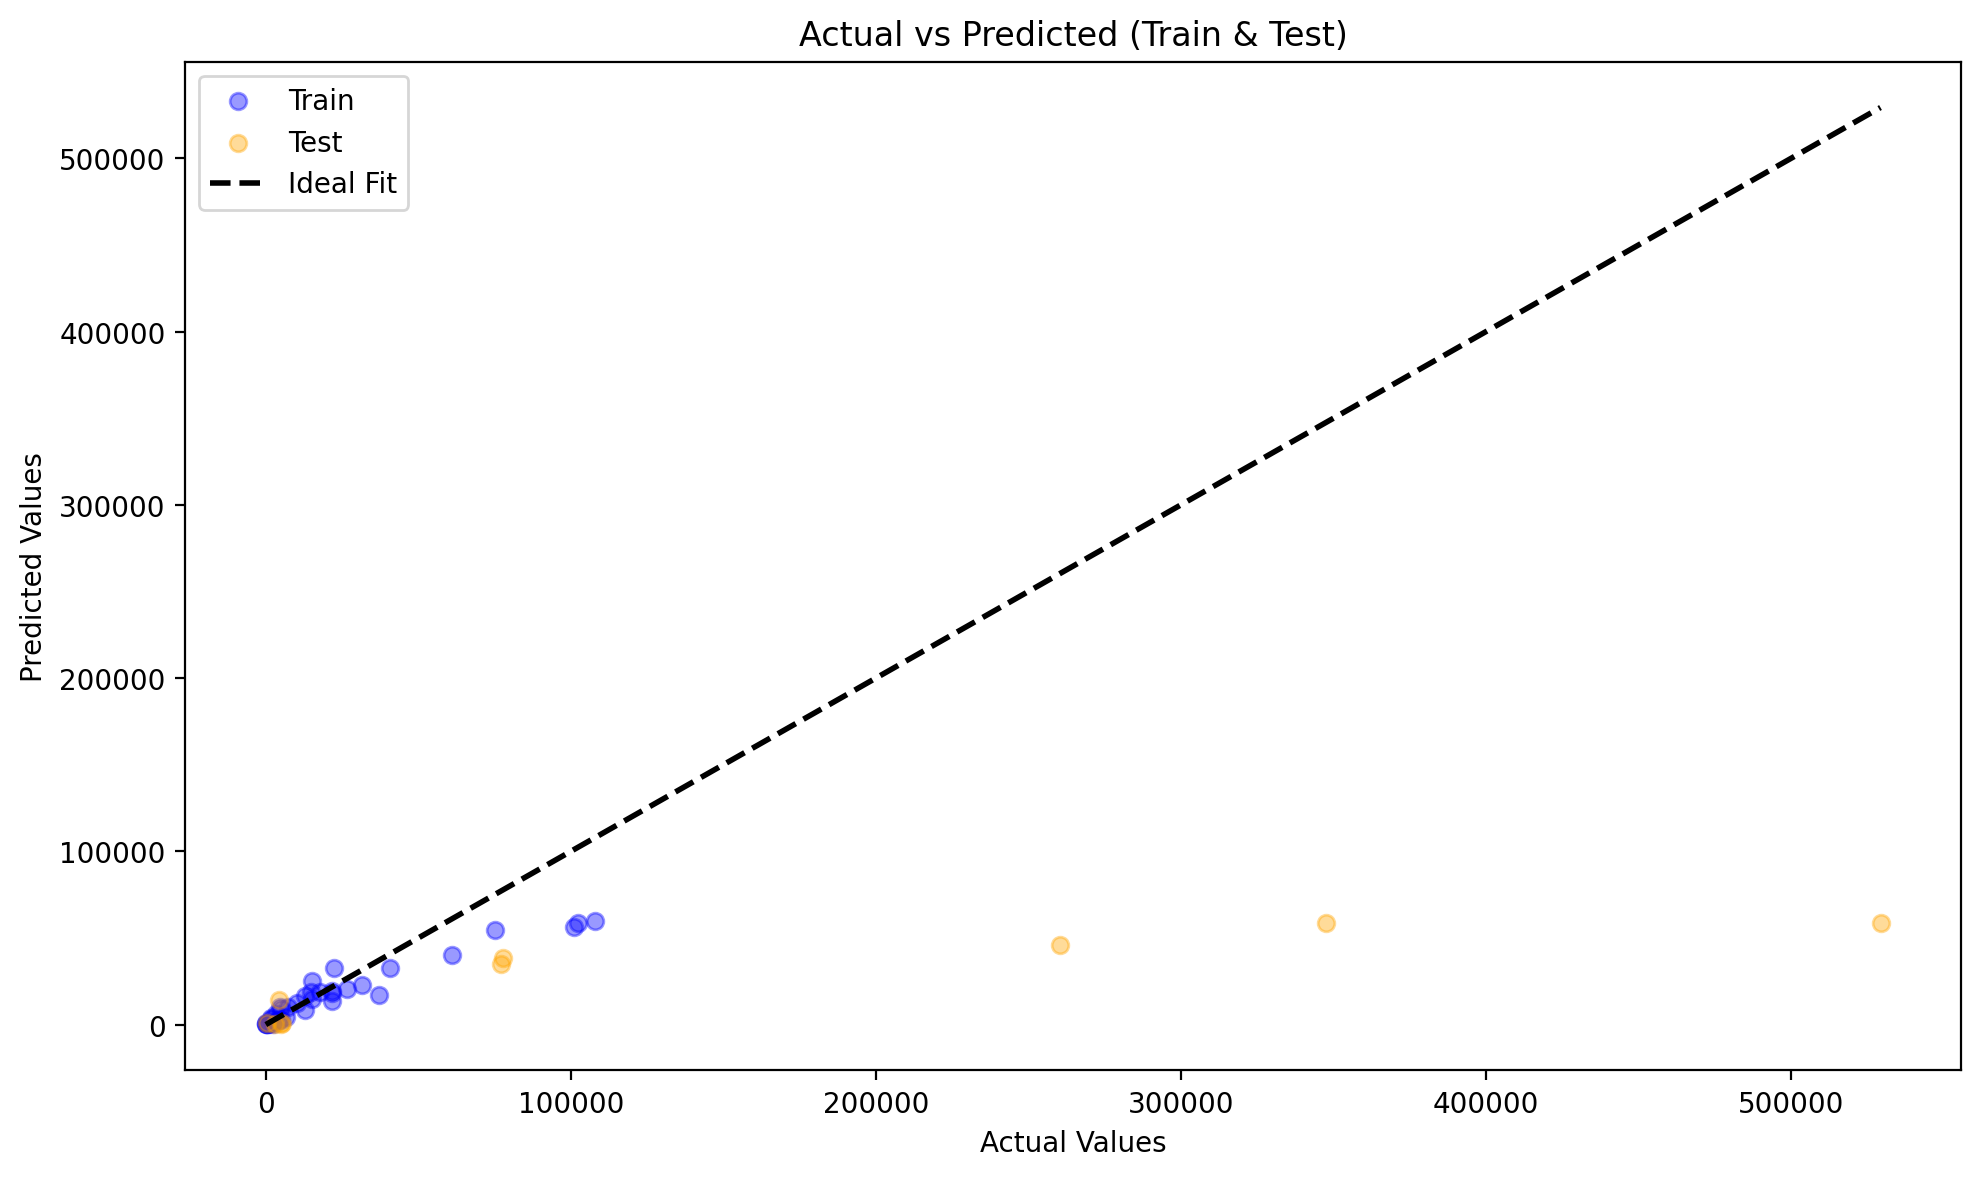

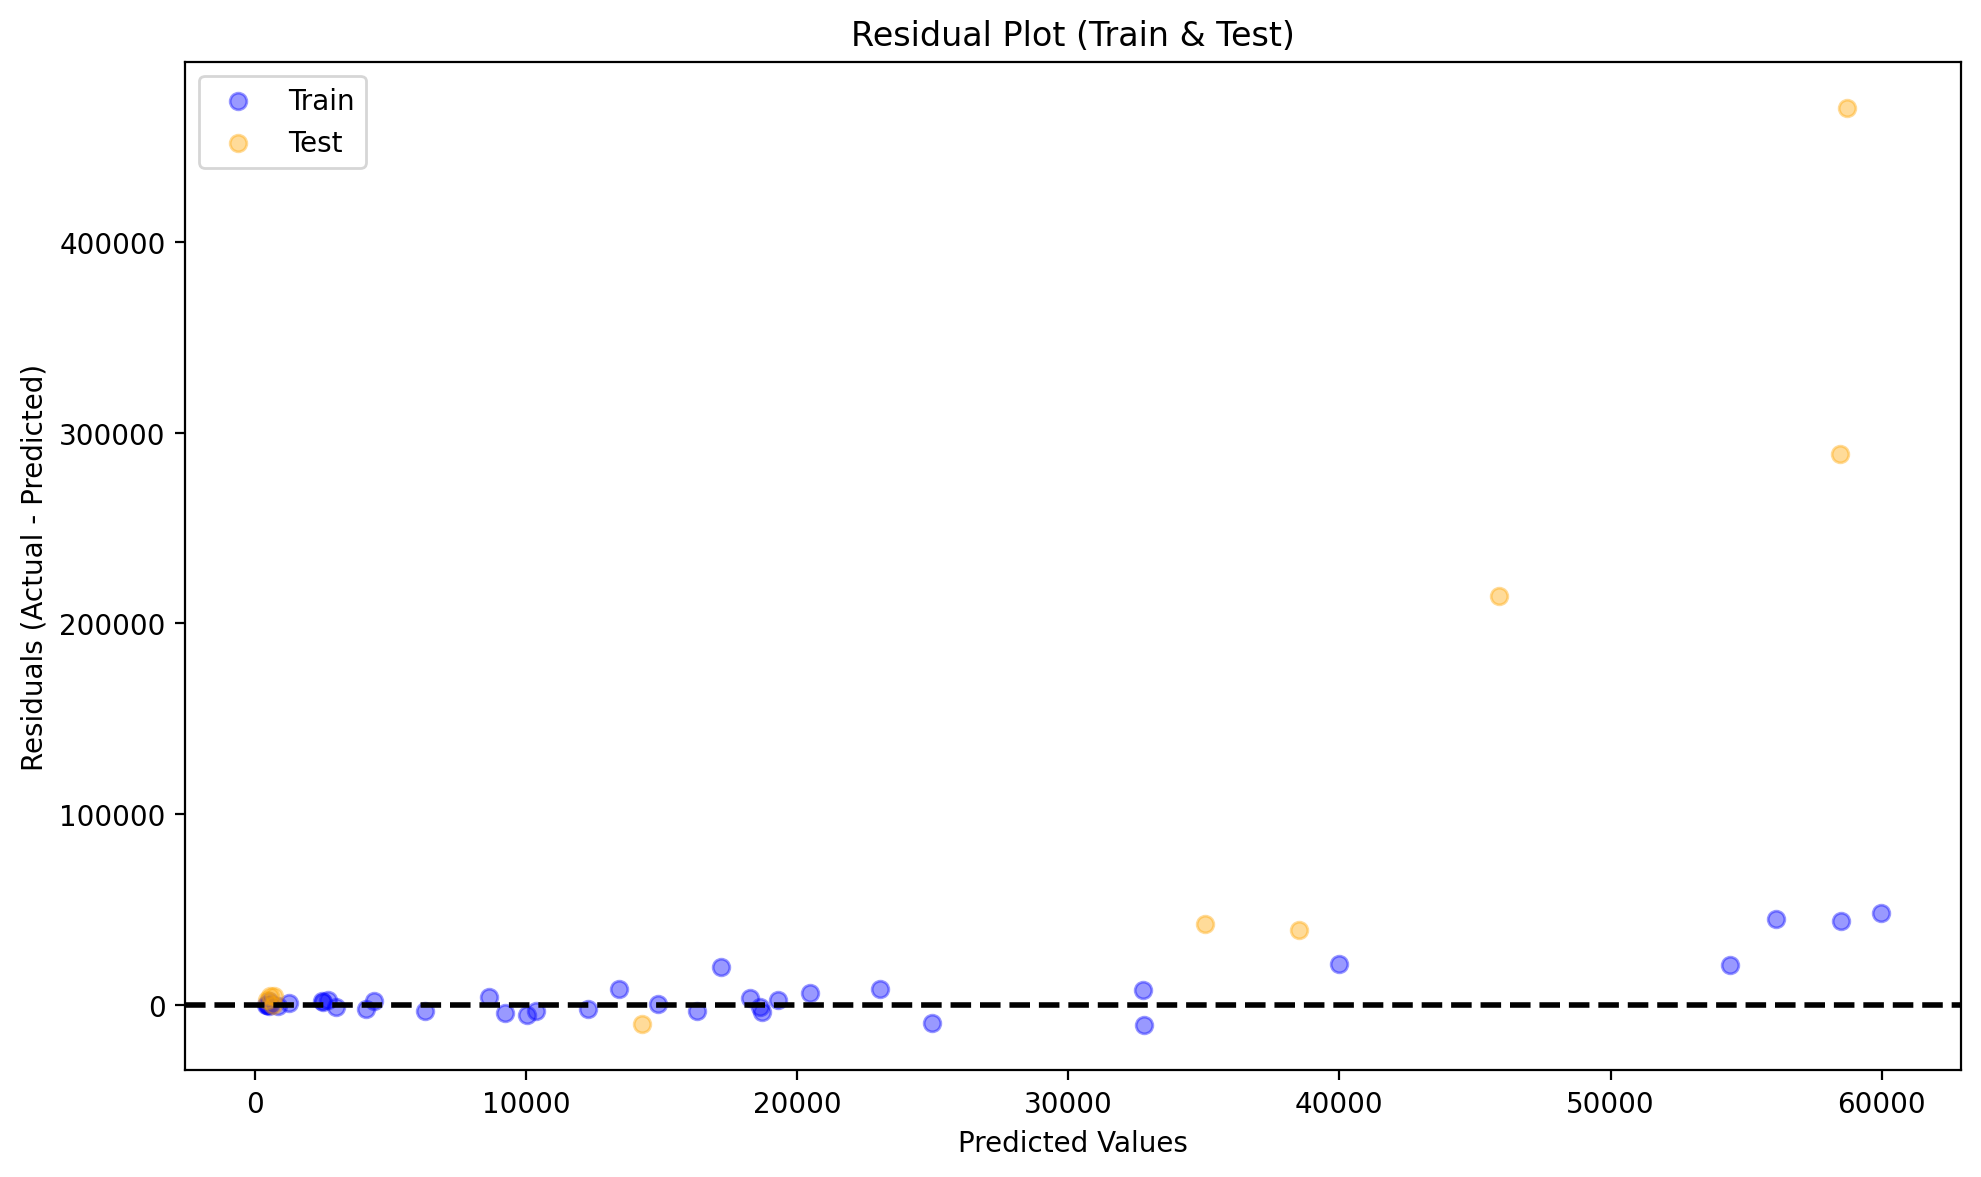

In [47]:
print("=" * 50)
print("Analysing: Total Volume (number of guests)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_volume_log')
# Run the modelling pipeline
revenue_model, revenue_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_volume'])

### Guest Density

Analysing: Total Guest Density (Number of guestes per km2)
Data prepared for target: 'total_tourism_intensity_km2_log'
Number of features: 39
Number of rows after cleaning: 48

--- Training Baseline Model ---
Baseline R-squared (R²): 0.88
Baseline MAE (log): 0.666
Baseline RMSE (log): 0.773
Baseline MAE (original): 160.54
Baseline RMSE (original): 273.66

--- Starting Hyperparameter Tuning ---
Tuning complete.
Best parameters found: {'n_estimators': 300, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 20}
Tuned R-squared (R²): 0.87
Tuned MAE (log): 0.711
Tuned RMSE (log): 0.810
Tuned MAE (original): 182.31
Tuned RMSE (original): 321.56


/Users/elisdavies/Documents/University_of_Liverpool/MSc Geographic Data Science/ENVS492 - Dissertation/POI-and-STR-Guest-Modelling/notebooks/edinburgh/../../scripts/modelling.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette="viridis")


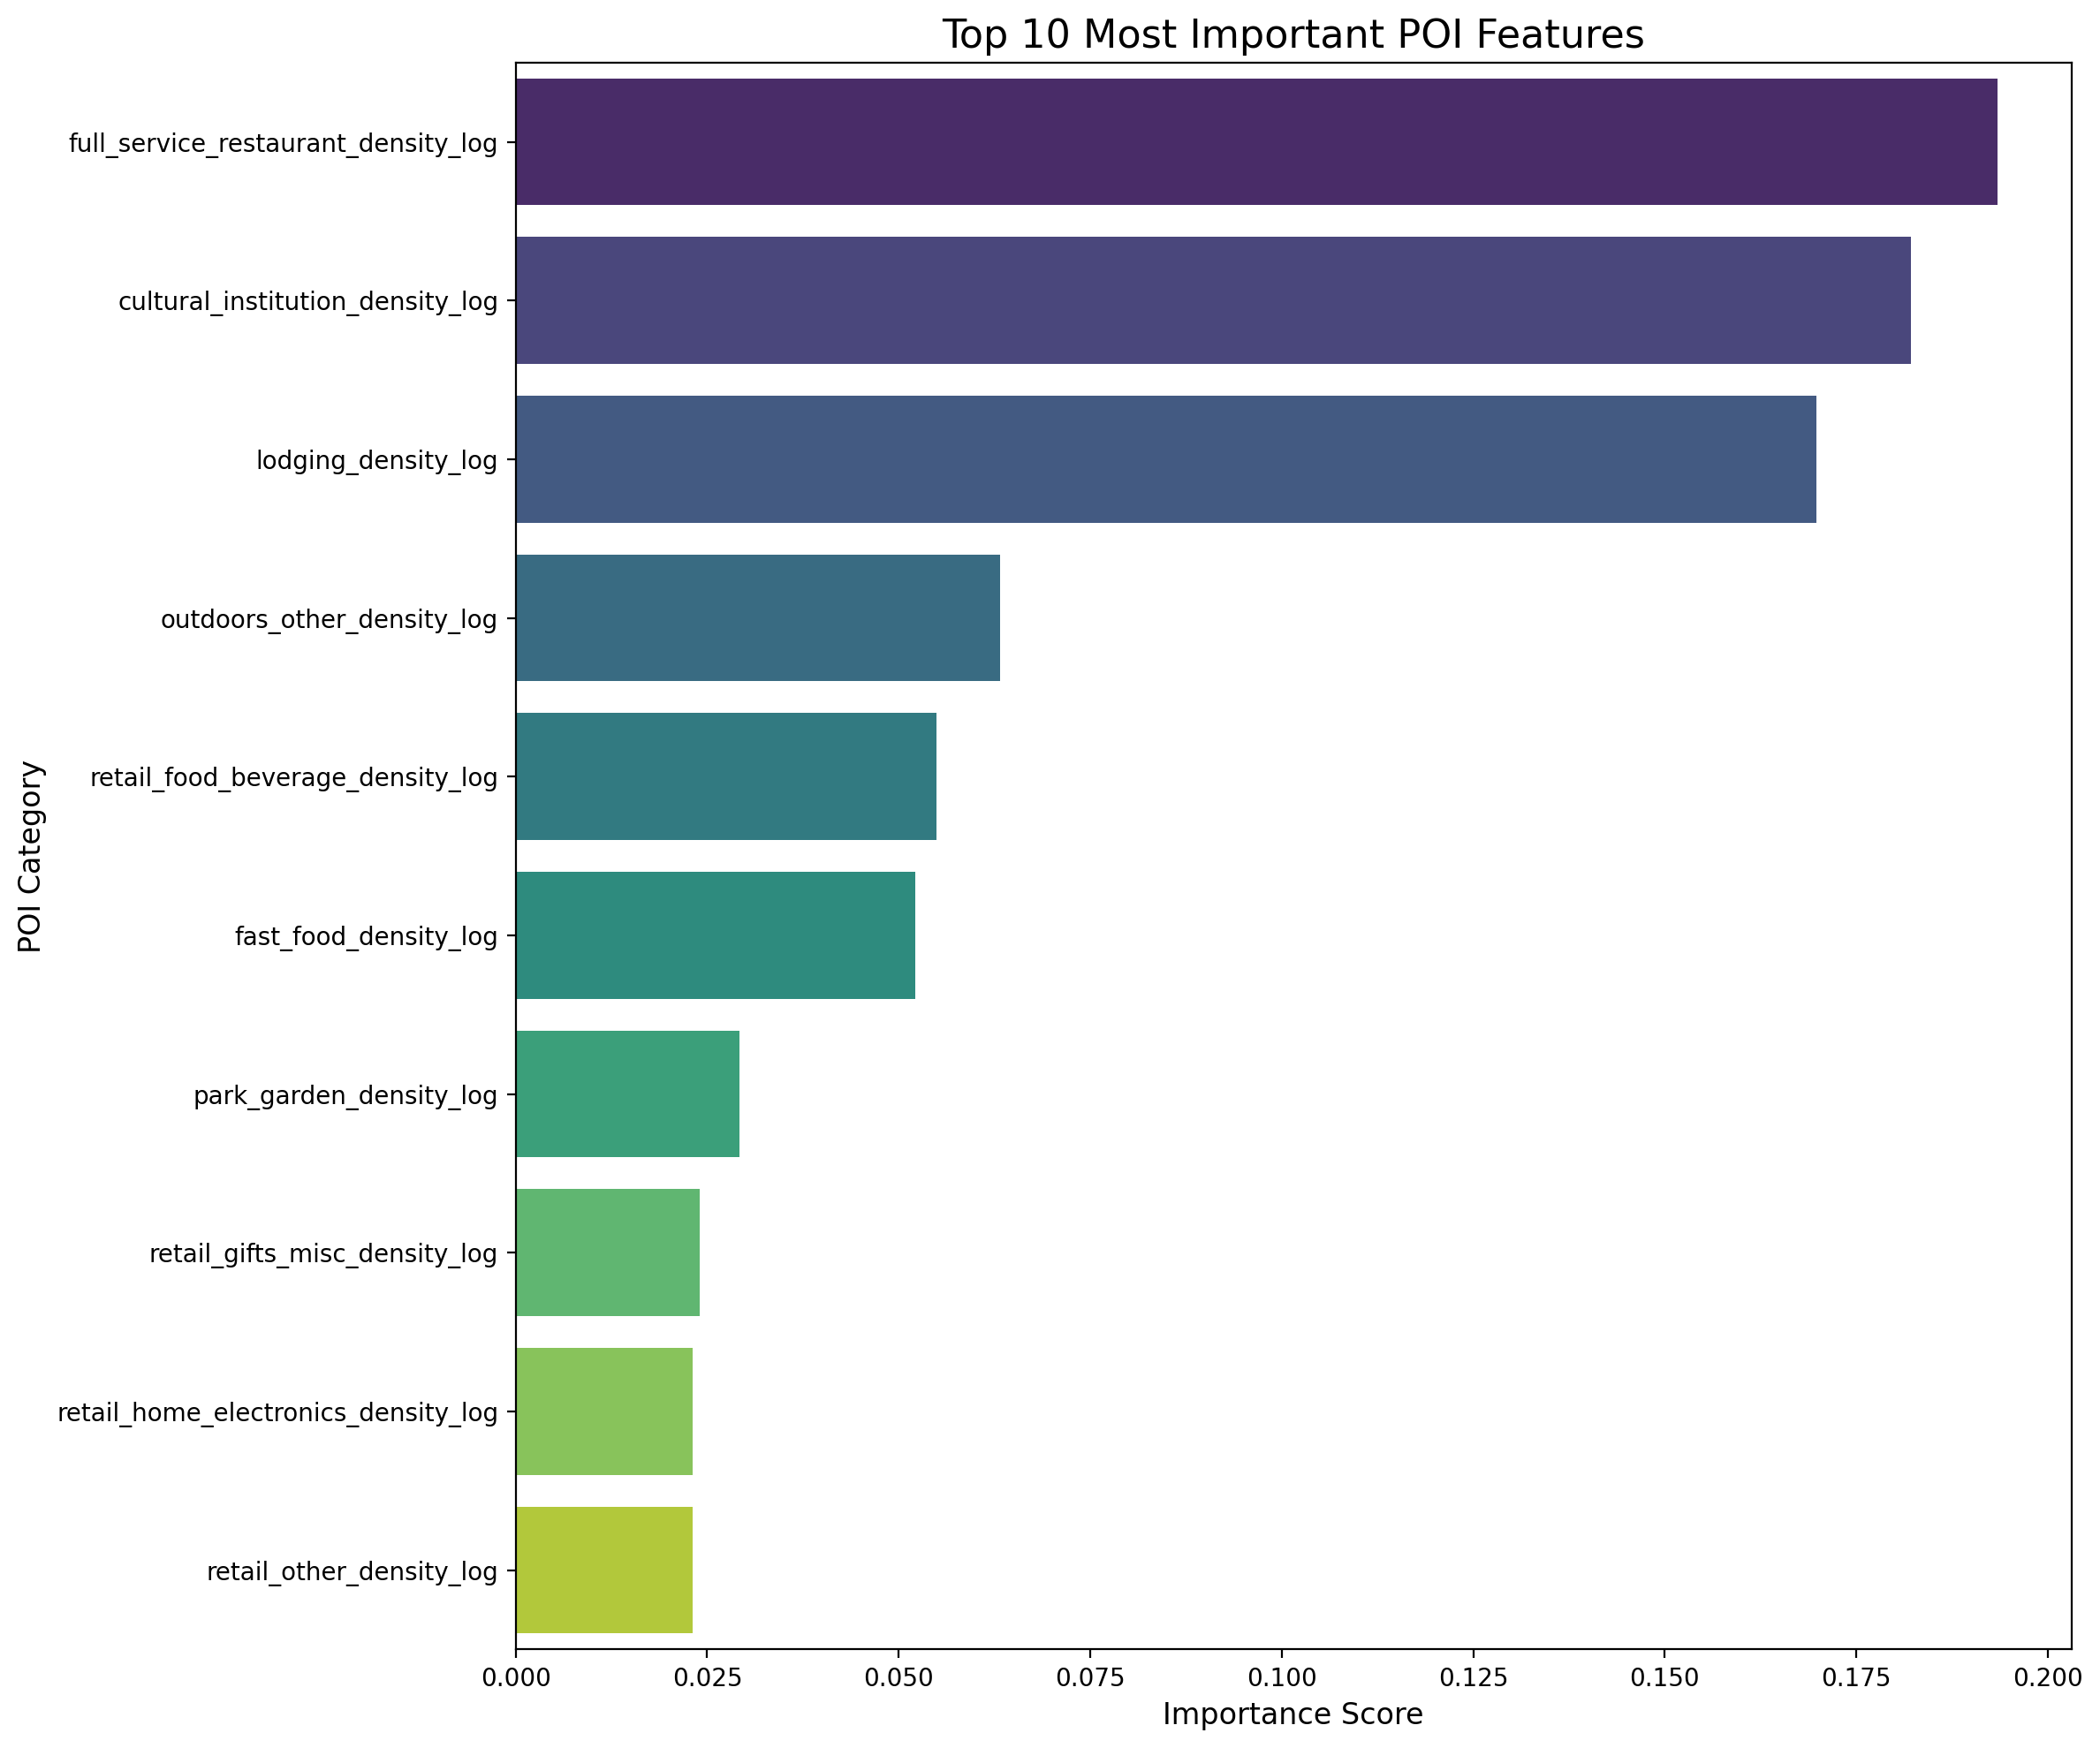


--- Top 10 Most Important Features ---
full_service_restaurant_density_log    0.193400
cultural_institution_density_log       0.182161
lodging_density_log                    0.169820
outdoors_other_density_log             0.063275
retail_food_beverage_density_log       0.054903
fast_food_density_log                  0.052154
park_garden_density_log                0.029220
retail_gifts_misc_density_log          0.024019
retail_home_electronics_density_log    0.023064
retail_other_density_log               0.023062
dtype: float64


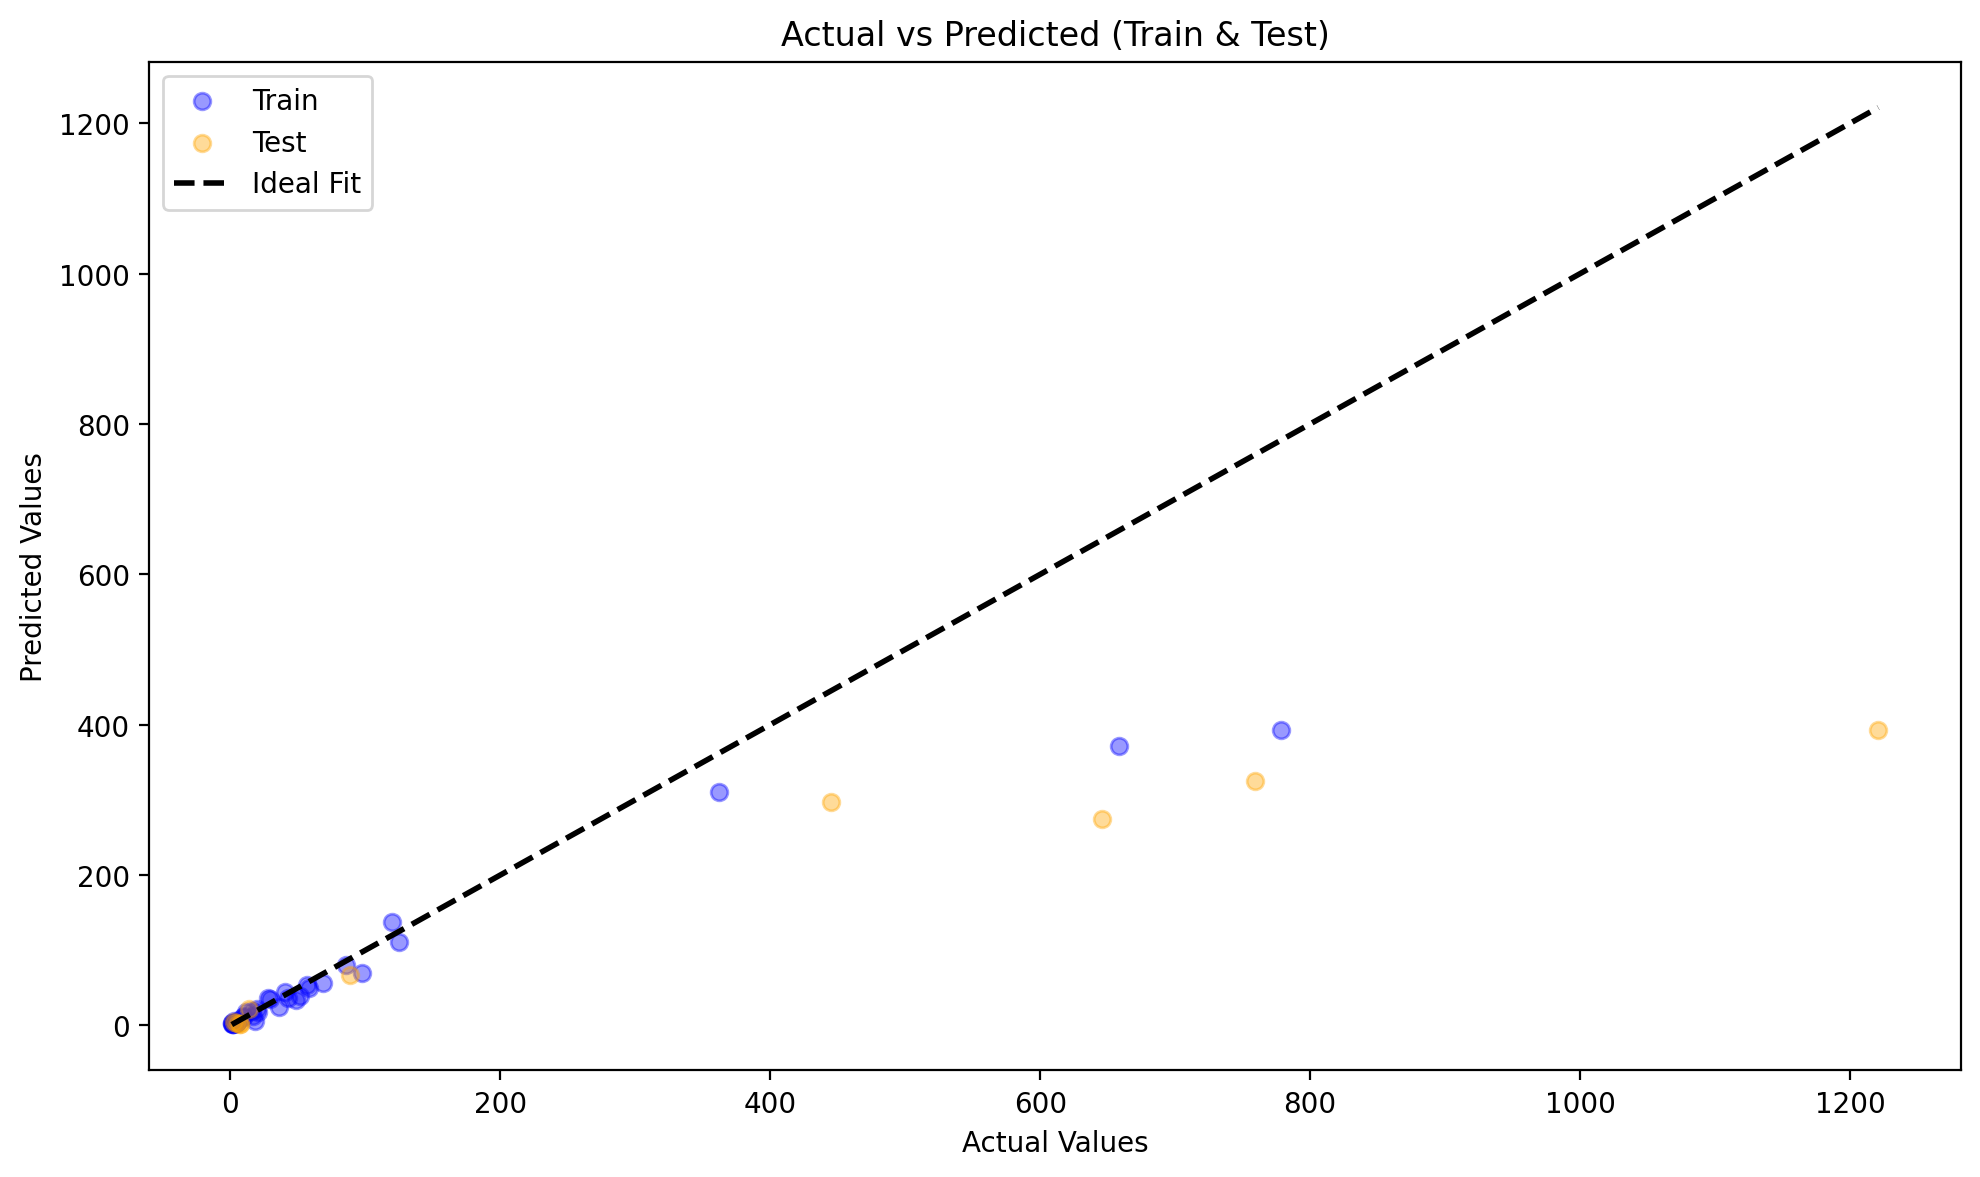

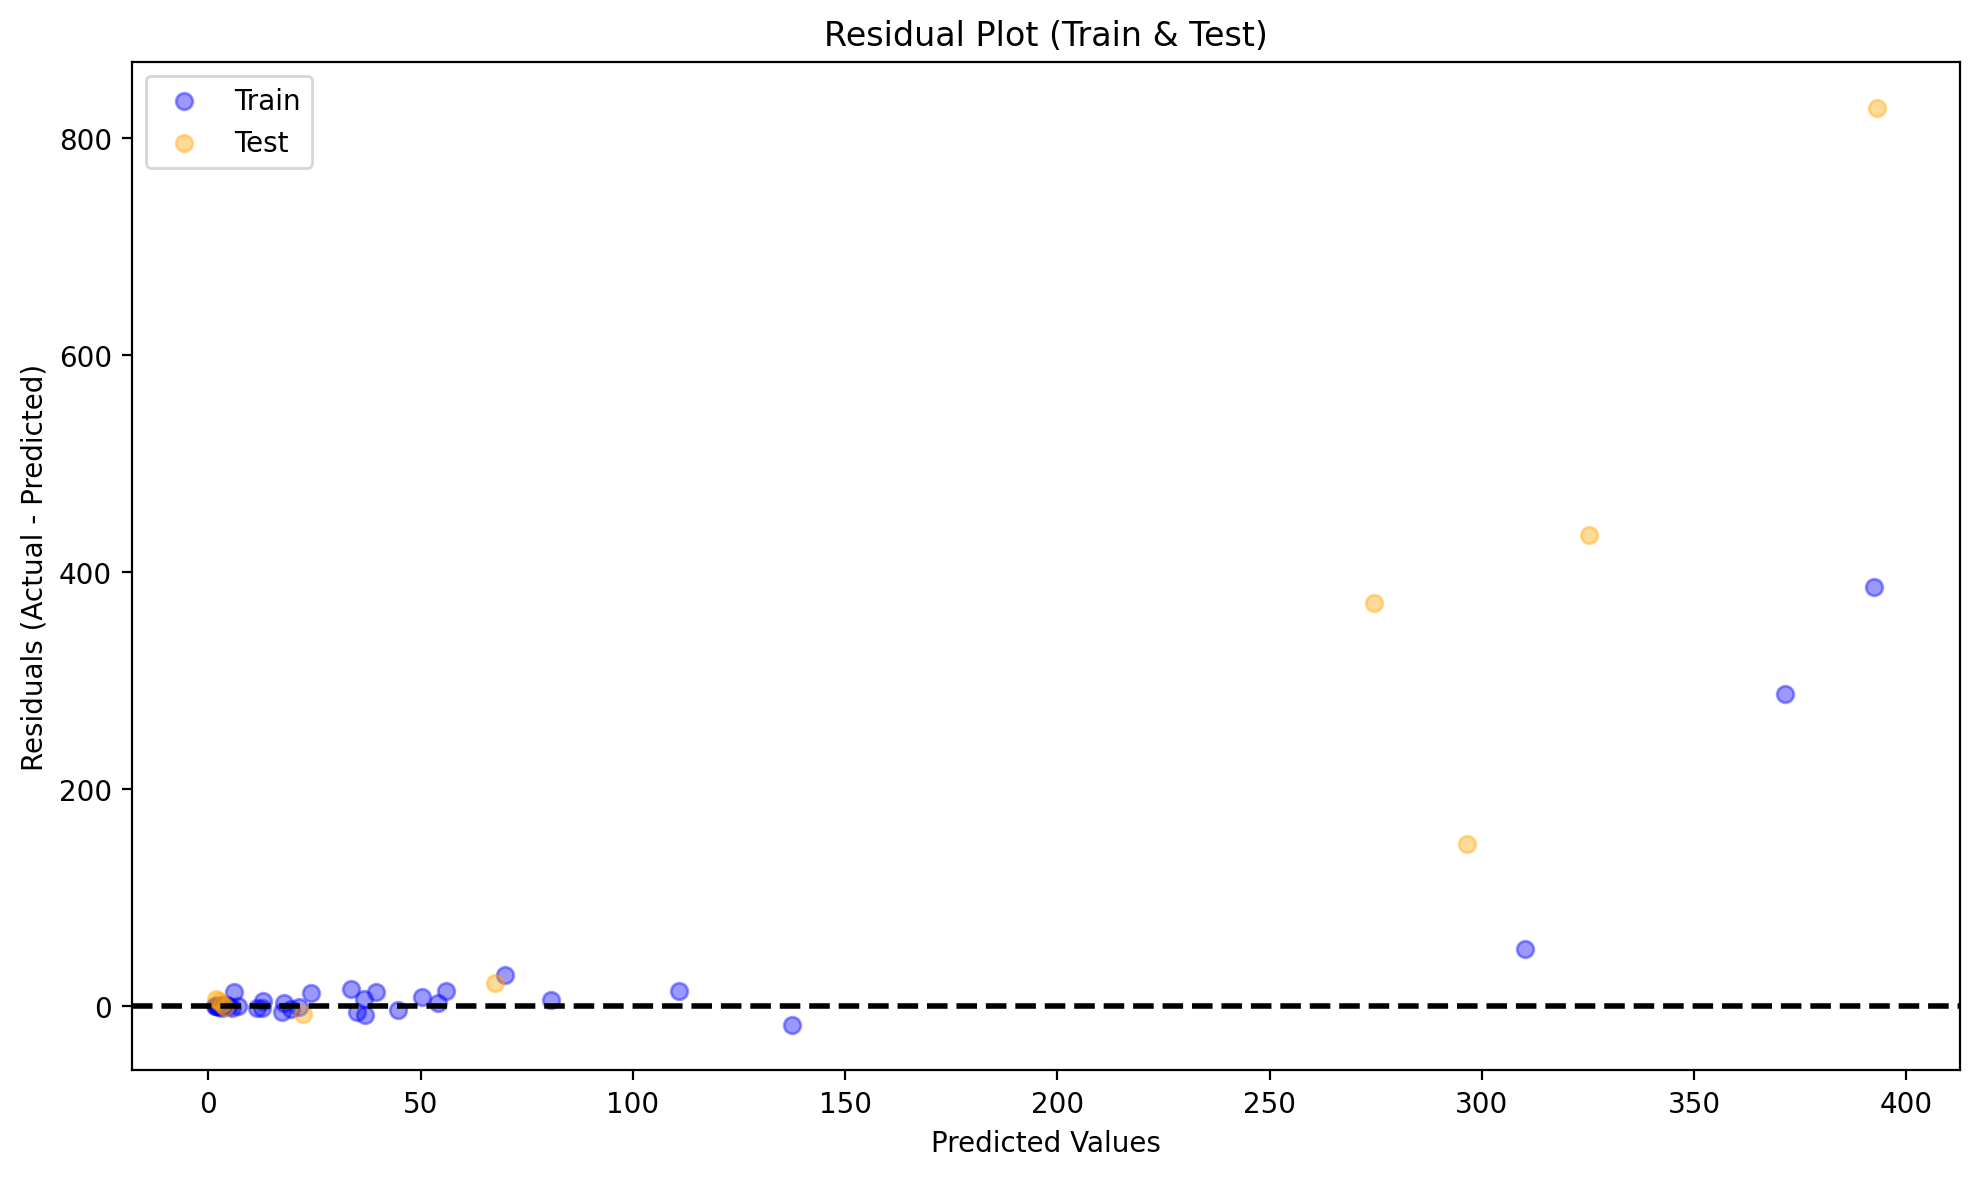

In [48]:
print("=" * 50)
print("Analysing: Total Guest Density (Number of guestes per km2)")
print("=" * 50)
# Prepare the data
X_rev, y_rev = prepare_data(edinburgh_airbnb_tourism_fs, features_logged, 'total_tourism_intensity_km2_log')
# Run the modelling pipeline
revenue_model, revenue_importances = run_modelling_pipeline(X_rev, y_rev, edinburgh_airbnb_tourism_fs['total_tourism_intensity_km2'])

## 4. Geographically Weighted Regression

In [49]:
# Drop rows with NaN values in the target column - this applies to all targets
edinburgh_airbnb_tourism_fs_clean = edinburgh_airbnb_tourism_fs.dropna(subset=['total_revenue'])

gwr_feature_columns = [
    "full_service_restaurant_density_log",
    "cultural_institution_density_log",
    "lodging_density_log",
    "fast_food_density_log",
    "retail_food_beverage_density_log"
]

Only have 48 towns in Edinburgh, therefore, this will not run.

## 5. Geographically Weighted Random Forest

### Total Revenue

In [50]:
# Set CRS
gdf = edinburgh_airbnb_tourism_fs.to_crs(epsg=27700) 

# Get coordinates matrix
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Target variable and predictors
target = "total_revenue_log"
X_cols = features_logged

In [51]:
# --- Parameters ---
k_neighbours = 50            # Step 1: How many neighbours to use for each local model
min_local_data = 10         # Step 2: Minimum required valid observations for local fitting

# --- Build spatial index ---
# Step 3: Extract centroid coordinates for each spatial unit
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Step 4: Build a KD-Tree for fast nearest-neighbour queries
tree = cKDTree(coords)

# --- Outputs ---
# Step 5: Prepare lists to store model results
predictions = []                # Store predicted values at each location
local_r2s = []                  # Store local R² values
feature_importance_list = []   # Store feature importance vectors

# --- Loop through each location ---
# Step 6: Loop over every spatial unit (polygon)
for i, point in enumerate(coords):
    # Step 7: Find k nearest neighbours around the focal point
    distances, indices = tree.query(point, k=k_neighbours)
    raw_local_data = gdf.iloc[indices]

    # Step 8: Remove neighbours that have missing values in predictors or target
    local_data = raw_local_data.dropna(subset=[target] + X_cols)

    # Step 9: If not enough valid data, skip this location
    if len(local_data) < min_local_data:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        feature_importance_list.append([np.nan] * len(X_cols))
        continue

    # Step 10: Get distances only for valid neighbours
    valid_idx_mask = raw_local_data.index.isin(local_data.index)
    valid_distances = distances[valid_idx_mask]

    # Step 11: Extract predictor and target matrices
    X_local = local_data[X_cols].values
    y_local = local_data[target].values

    # Step 12: Compute bisquare weights for valid neighbours
    D = valid_distances.max()
    weights = (1 - (valid_distances / D) ** 2) ** 2
    weights[valid_distances >= D] = 0

    # Step 13: Normalize weights into probabilities for sampling
    prob = weights / weights.sum()

    # Step 14: Sample with replacement using weights — spatial bootstrap
    sample_idx = np.random.choice(len(X_local), size=len(X_local), p=prob,
                                  replace=True)
    X_weighted = X_local[sample_idx]
    y_weighted = y_local[sample_idx]

    # Step 15: Train local random forest on spatially weighted data
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_weighted, y_weighted)

    # Step 16: Evaluate model R² on *original* local data (not weighted)
    y_local_pred = rf.predict(X_local)
    r2_local = r2_score(y_local, y_local_pred)
    local_r2s.append(r2_local)

    # Step 17: Predict the target value at the focal location itself
    X_pred = gdf.iloc[[i]][X_cols].values
    pred = rf.predict(X_pred)[0]
    predictions.append(pred)

    # Step 18: Save feature importances for this local model
    feature_importance_list.append(rf.feature_importances_)

    # Step 19: Print progress
    if i % 50 == 0:
        print(f"Processed {i}/{len(gdf)} points")

# --- Store predictions, R², and feature importances ---
# Step 20: Add prediction and R² columns to the GeoDataFrame
gdf["grf_prediction"] = predictions
gdf["grf_local_r2"] = local_r2s

# Step 21: Convert list of feature importance arrays into a DataFrame and merge
importances_df = pd.DataFrame(feature_importance_list,
                              columns=[f"{col}_importance" for col in X_cols])
gdf = gdf.join(importances_df)

# --- Identify top feature per location ---
# Step 22: Find the feature with the highest importance at each location
importance_cols = [f"{col}_importance" for col in X_cols]
importance_only = gdf[importance_cols]

# Step 23: Get the name of the most important POI for each polygon
gdf["top_poi"] = importance_only.idxmax(axis=1)

# Step 24: Clean up the POI column names for readability
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_density_log_importance", "",
                                                  regex=False)
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_log_importance", "",
                                                  regex=False)

Processed 0/55 points
Processed 50/55 points


In [52]:
# Evaluate log and original scale
valid_mask = gdf["grf_prediction"].notna() & gdf[target].notna()
y_true_log = gdf.loc[valid_mask, target]
y_pred_log = gdf.loc[valid_mask, "grf_prediction"]

# Metrics on log scale
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)

# Metrics on original scale
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)

print("GRF Evaluation Metrics")
print("---------------------------------")
print(f"R² {r2:.3f}")
print(f"RMSE (log scale): {rmse_log:.3f}")
print(f"MAE  (log scale): {mae_log:.3f}")
print(f"RMSE (original scale): {rmse_orig:,.2f}")
print(f"MAE  (original scale): {mae_orig:,.2f}")

GRF Evaluation Metrics
---------------------------------
R² 0.927
RMSE (log scale): 0.592
MAE  (log scale): 0.350
RMSE (original scale): 2,606,386.77
MAE  (original scale): 574,609.77


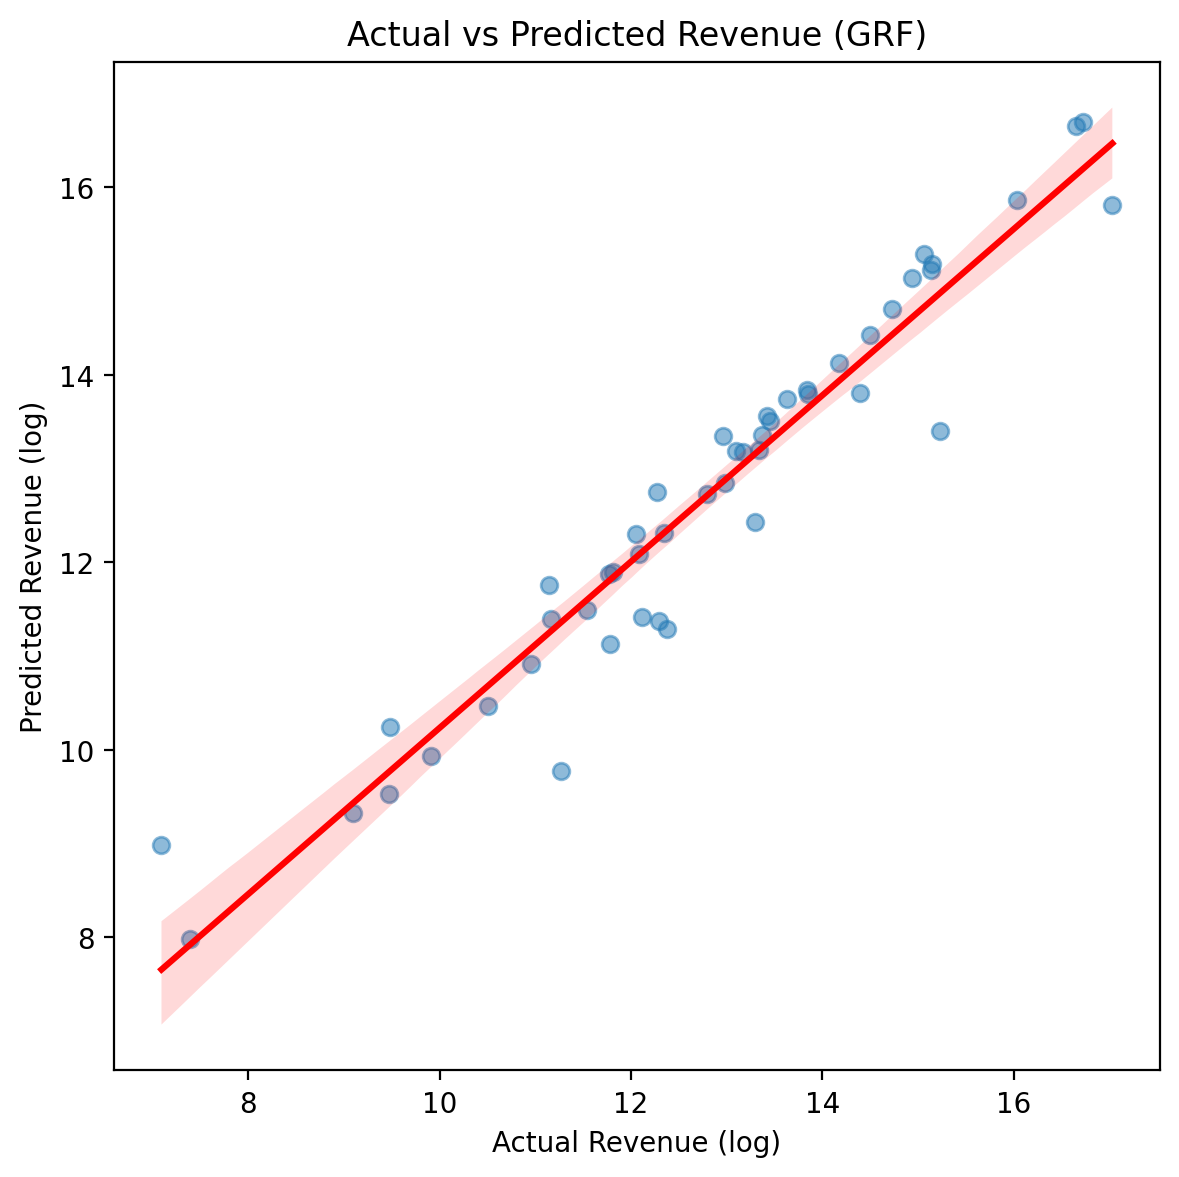

In [53]:
plt.figure(figsize=(6, 6))
sns.regplot(x=gdf.loc[valid_mask, target],
            y=gdf.loc[valid_mask, "grf_prediction"],
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5})

plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.title("Actual vs Predicted Revenue (GRF)")
plt.grid(False)
plt.tight_layout()
plt.show()

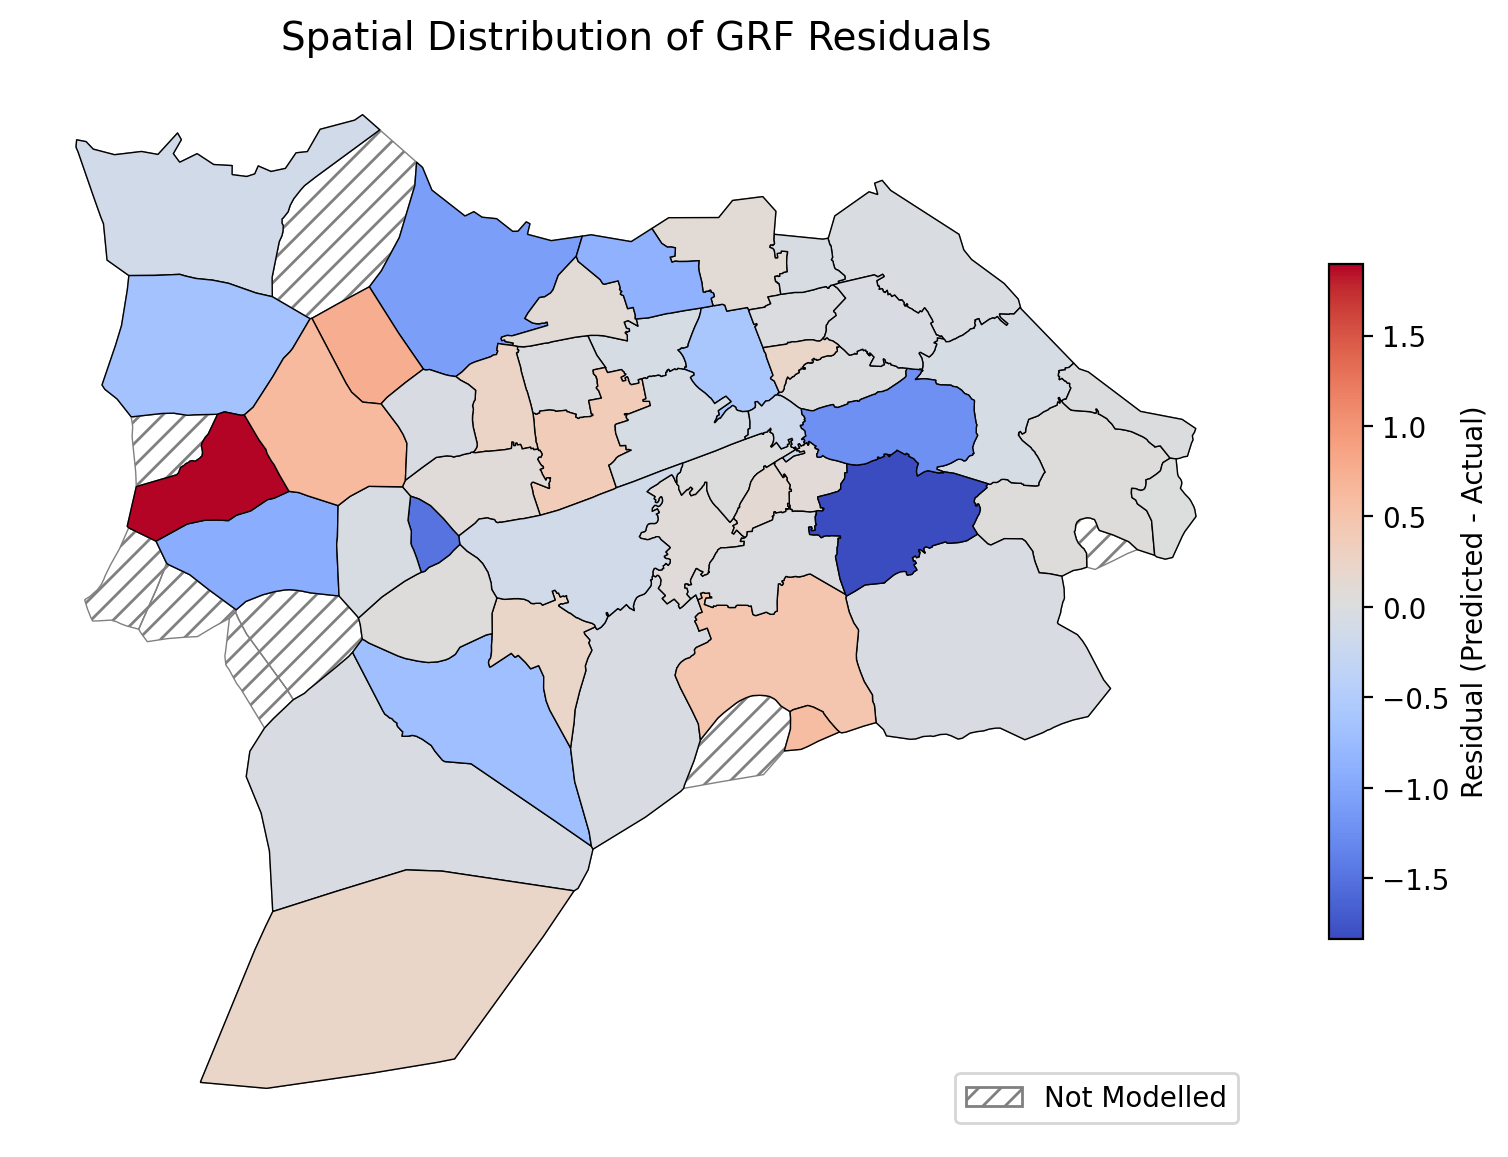

In [54]:
gdf["grf_residual"] = gdf["grf_prediction"] - gdf[target]

# Filter valid predictions
gdf_valid = gdf[valid_mask]

# Create shared figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# --- Baselayer: all boundaries with hatch for unmodelled areas ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# --- Residuals map ---
gdf_valid.plot(
    ax=ax,
    column="grf_residual",
    cmap="coolwarm",
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={
        'label': "Residual (Predicted - Actual)",
        'shrink': 0.6
    },
    zorder=1
)

# --- Final styling ---
hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
ax.legend(handles=[hatch_patch], loc='lower right')

ax.set_title("Spatial Distribution of GRF Residuals", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

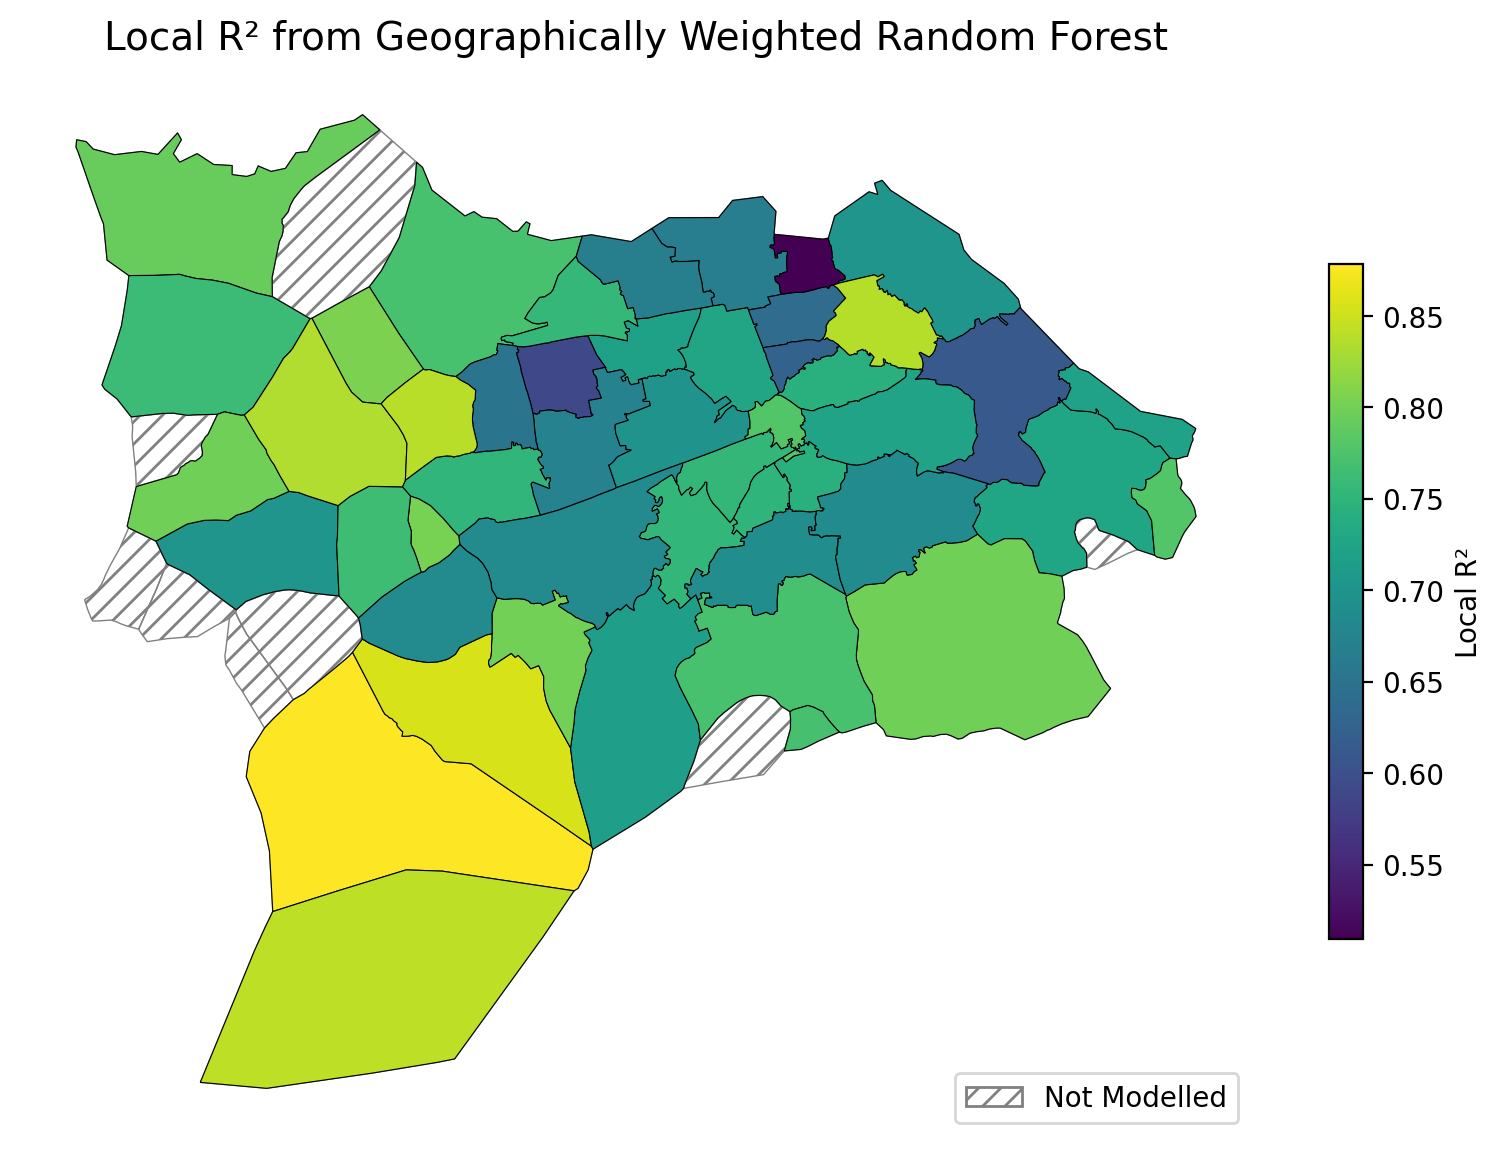

In [55]:
# Filter to valid R² values
gdf_valid_r2 = gdf_valid[gdf_valid["grf_local_r2"].notna()]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# --- Baselayer ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# --- R² choropleth ---
gdf_valid_r2.plot(
    ax=ax,
    column="grf_local_r2",
    cmap="viridis",
    edgecolor="black",
    linewidth=0.4,
    legend=True,
    legend_kwds={
        'label': "Local R²",
        'shrink': 0.6,
        'orientation': "vertical"
    },
    zorder=1  # On top
)

hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
ax.legend(handles=[hatch_patch], loc='lower right')
# --- Styling ---
ax.set_title("Local R² from Geographically Weighted Random Forest", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

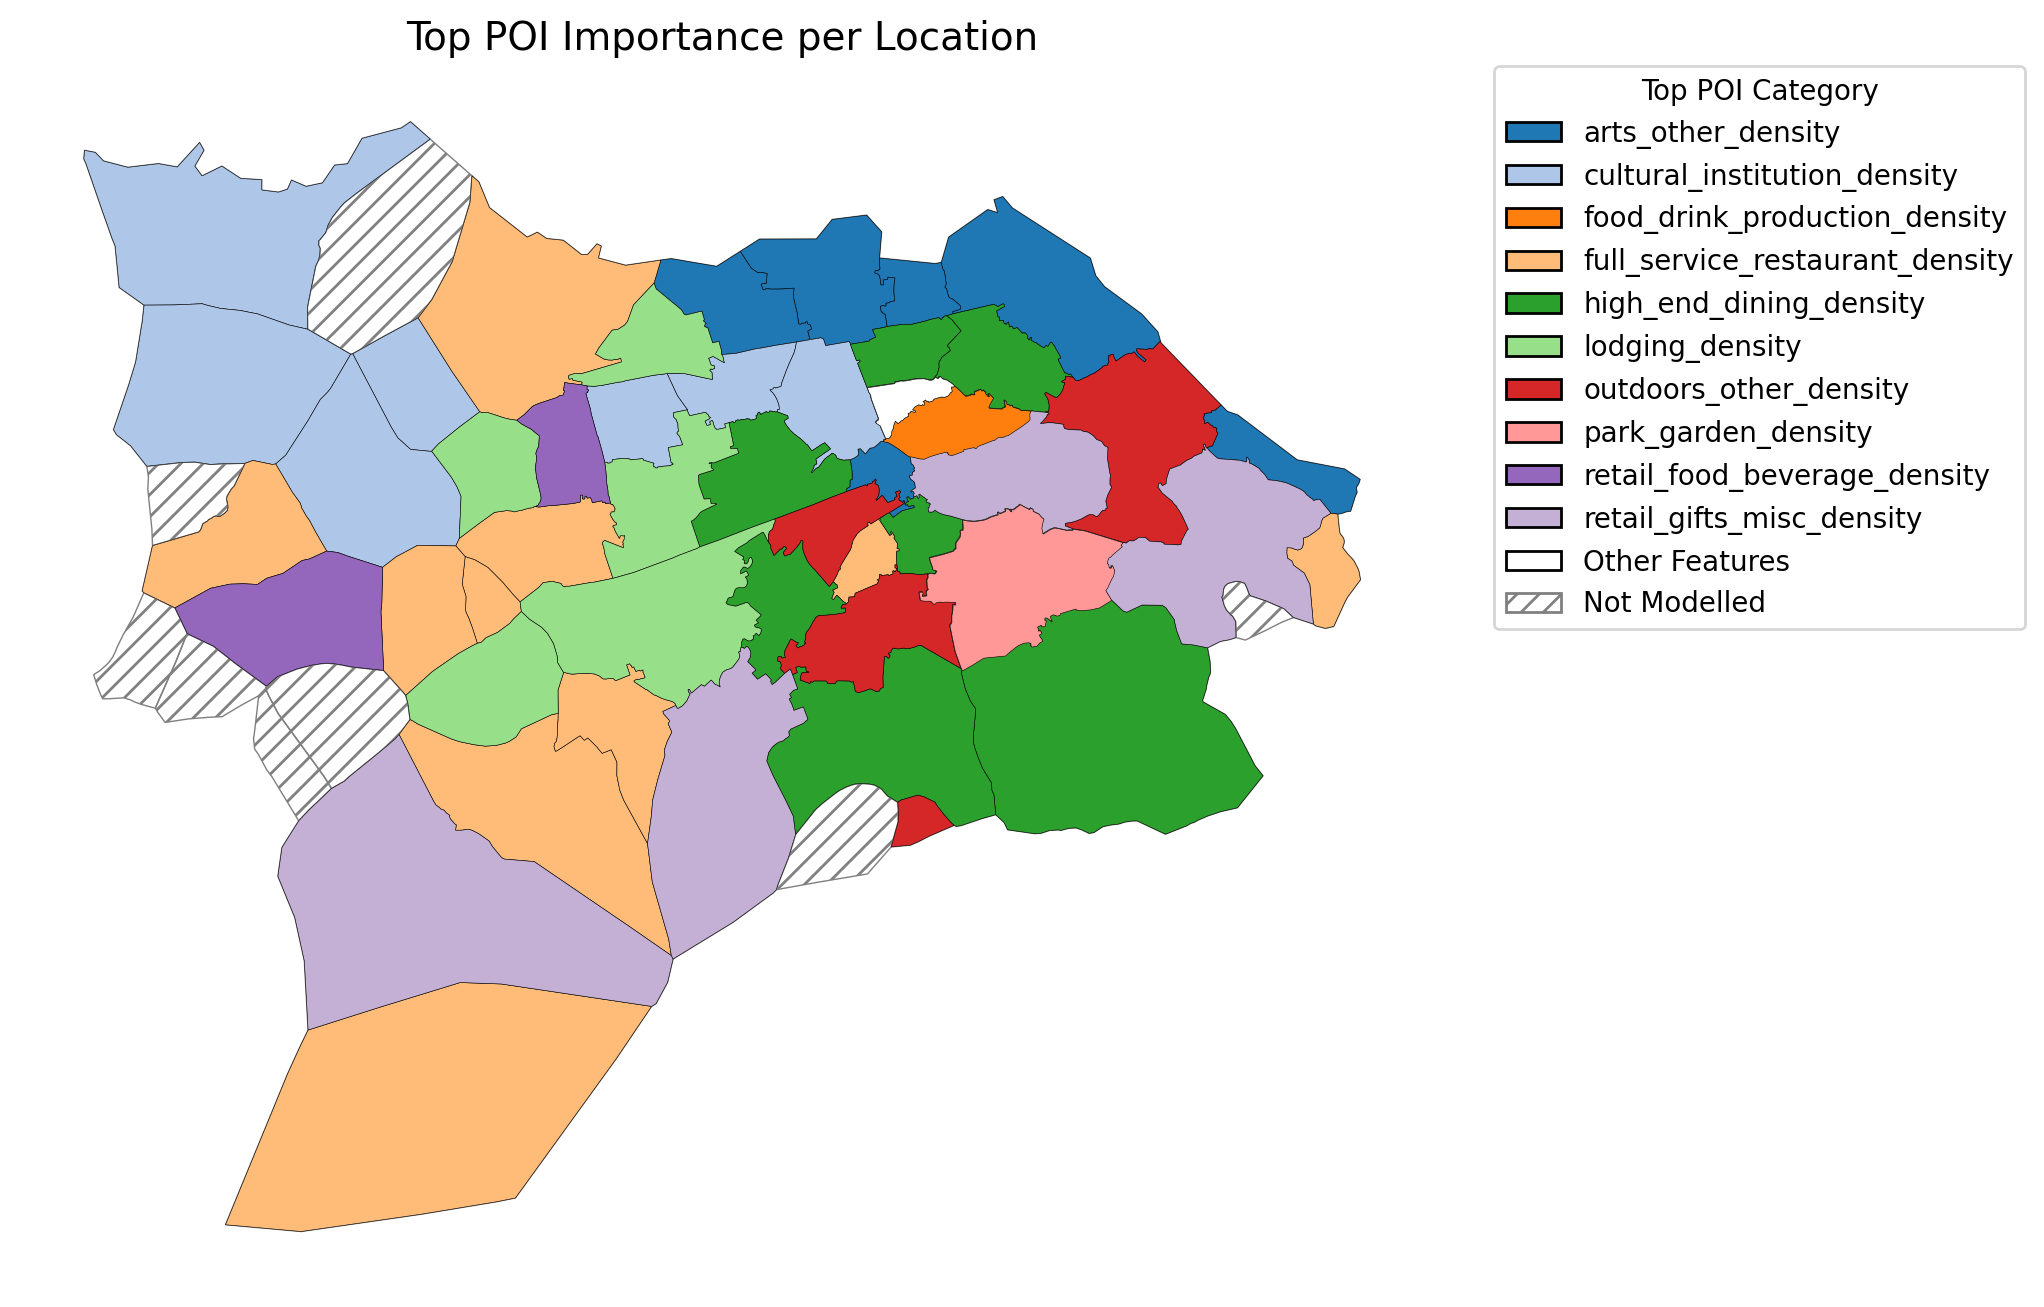

In [56]:
# --- Step 0: Prepare GeoDataFrame ---
gdf_valid = gdf[valid_mask].copy()  # Ensure gdf_valid is up to date

# --- Step 1: Define top N POI features to highlight ---
top_n = 10
top_pois = (
    gdf_valid["top_poi_clean"]
    .value_counts()
    .nlargest(top_n)
    .index.tolist()
)

# --- Step 2: Assign "Other Features" to less frequent ones ---
gdf_valid["top_poi_plot"] = gdf_valid["top_poi_clean"].where(
    gdf_valid["top_poi_clean"].isin(top_pois),
    "Other Features"
)

# --- Step 3: Build color map ---
unique_pois = sorted(set(top_pois))
unique_pois.append("Other Features")

colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois) - 1:
    colors += colors  # Ensure enough colors

poi_color_map = dict(zip(unique_pois[:-1], colors[:len(unique_pois) - 1]))
poi_color_map["Other Features"] = "white"

# --- Step 4: Create figure and axis ---
fig, ax = plt.subplots(figsize=(10, 8))

# --- Step 5: Plot full Edinburgh shapefile as base (hatch for non-modeled) ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# --- Step 6: Plot colored GRF results ---
for poi, color in poi_color_map.items():
    subset = gdf_valid[gdf_valid["top_poi_plot"] == poi]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)

# --- Step 7: Add legend ---
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois
]

# Add legend entry for hatch
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

ax.legend(
    handles=legend_elements,
    title="Top POI Category",
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.
)

# --- Step 8: Finalize map ---
plt.title("Top POI Importance per Location", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Total Volume

In [57]:
# Set CRS
gdf = edinburgh_airbnb_tourism_fs.to_crs(epsg=27700) 

# Get coordinates matrix
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Target variable and predictors
target = "total_volume_log"
X_cols = features_logged

In [58]:
# --- Parameters ---
k_neighbours = 50            # Step 1: How many neighbours to use for each local model
min_local_data = 10         # Step 2: Minimum required valid observations for local fitting

# --- Build spatial index ---
# Step 3: Extract centroid coordinates for each spatial unit
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Step 4: Build a KD-Tree for fast nearest-neighbour queries
tree = cKDTree(coords)

# --- Outputs ---
# Step 5: Prepare lists to store model results
predictions = []                # Store predicted values at each location
local_r2s = []                  # Store local R² values
feature_importance_list = []   # Store feature importance vectors

# --- Loop through each location ---
# Step 6: Loop over every spatial unit (polygon)
for i, point in enumerate(coords):
    # Step 7: Find k nearest neighbours around the focal point
    distances, indices = tree.query(point, k=k_neighbours)
    raw_local_data = gdf.iloc[indices]

    # Step 8: Remove neighbours that have missing values in predictors or target
    local_data = raw_local_data.dropna(subset=[target] + X_cols)

    # Step 9: If not enough valid data, skip this location
    if len(local_data) < min_local_data:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        feature_importance_list.append([np.nan] * len(X_cols))
        continue

    # Step 10: Get distances only for valid neighbours
    valid_idx_mask = raw_local_data.index.isin(local_data.index)
    valid_distances = distances[valid_idx_mask]

    # Step 11: Extract predictor and target matrices
    X_local = local_data[X_cols].values
    y_local = local_data[target].values

    # Step 12: Compute bisquare weights for valid neighbours
    D = valid_distances.max()
    weights = (1 - (valid_distances / D) ** 2) ** 2
    weights[valid_distances >= D] = 0

    # Step 13: Normalize weights into probabilities for sampling
    prob = weights / weights.sum()

    # Step 14: Sample with replacement using weights — spatial bootstrap
    sample_idx = np.random.choice(len(X_local), size=len(X_local), p=prob,
                                  replace=True)
    X_weighted = X_local[sample_idx]
    y_weighted = y_local[sample_idx]

    # Step 15: Train local random forest on spatially weighted data
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_weighted, y_weighted)

    # Step 16: Evaluate model R² on *original* local data (not weighted)
    y_local_pred = rf.predict(X_local)
    r2_local = r2_score(y_local, y_local_pred)
    local_r2s.append(r2_local)

    # Step 17: Predict the target value at the focal location itself
    X_pred = gdf.iloc[[i]][X_cols].values
    pred = rf.predict(X_pred)[0]
    predictions.append(pred)

    # Step 18: Save feature importances for this local model
    feature_importance_list.append(rf.feature_importances_)

    # Step 19: Print progress
    if i % 50 == 0:
        print(f"Processed {i}/{len(gdf)} points")

# --- Store predictions, R², and feature importances ---
# Step 20: Add prediction and R² columns to the GeoDataFrame
gdf["grf_prediction"] = predictions
gdf["grf_local_r2"] = local_r2s

# Step 21: Convert list of feature importance arrays into a DataFrame and merge
importances_df = pd.DataFrame(feature_importance_list,
                              columns=[f"{col}_importance" for col in X_cols])
gdf = gdf.join(importances_df)

# --- Identify top feature per location ---
# Step 22: Find the feature with the highest importance at each location
importance_cols = [f"{col}_importance" for col in X_cols]
importance_only = gdf[importance_cols]

# Step 23: Get the name of the most important POI for each polygon
gdf["top_poi"] = importance_only.idxmax(axis=1)

# Step 24: Clean up the POI column names for readability
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_density_log_importance", "",
                                                  regex=False)
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_log_importance", "",
                                                  regex=False)

Processed 0/55 points
Processed 50/55 points


In [59]:
# Evaluate log and original scale
valid_mask = gdf["grf_prediction"].notna() & gdf[target].notna()
y_true_log = gdf.loc[valid_mask, target]
y_pred_log = gdf.loc[valid_mask, "grf_prediction"]

# Metrics on log scale
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)

# Metrics on original scale
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)

print("GRF Evaluation Metrics")
print("---------------------------------")
print(f"R² {r2:.3f}")
print(f"RMSE (log scale): {rmse_log:.3f}")
print(f"MAE  (log scale): {mae_log:.3f}")
print(f"RMSE (original scale): {rmse_orig:,.2f}")
print(f"MAE  (original scale): {mae_orig:,.2f}")

GRF Evaluation Metrics
---------------------------------
R² 0.946
RMSE (log scale): 0.483
MAE  (log scale): 0.246
RMSE (original scale): 20,613.43
MAE  (original scale): 7,889.91


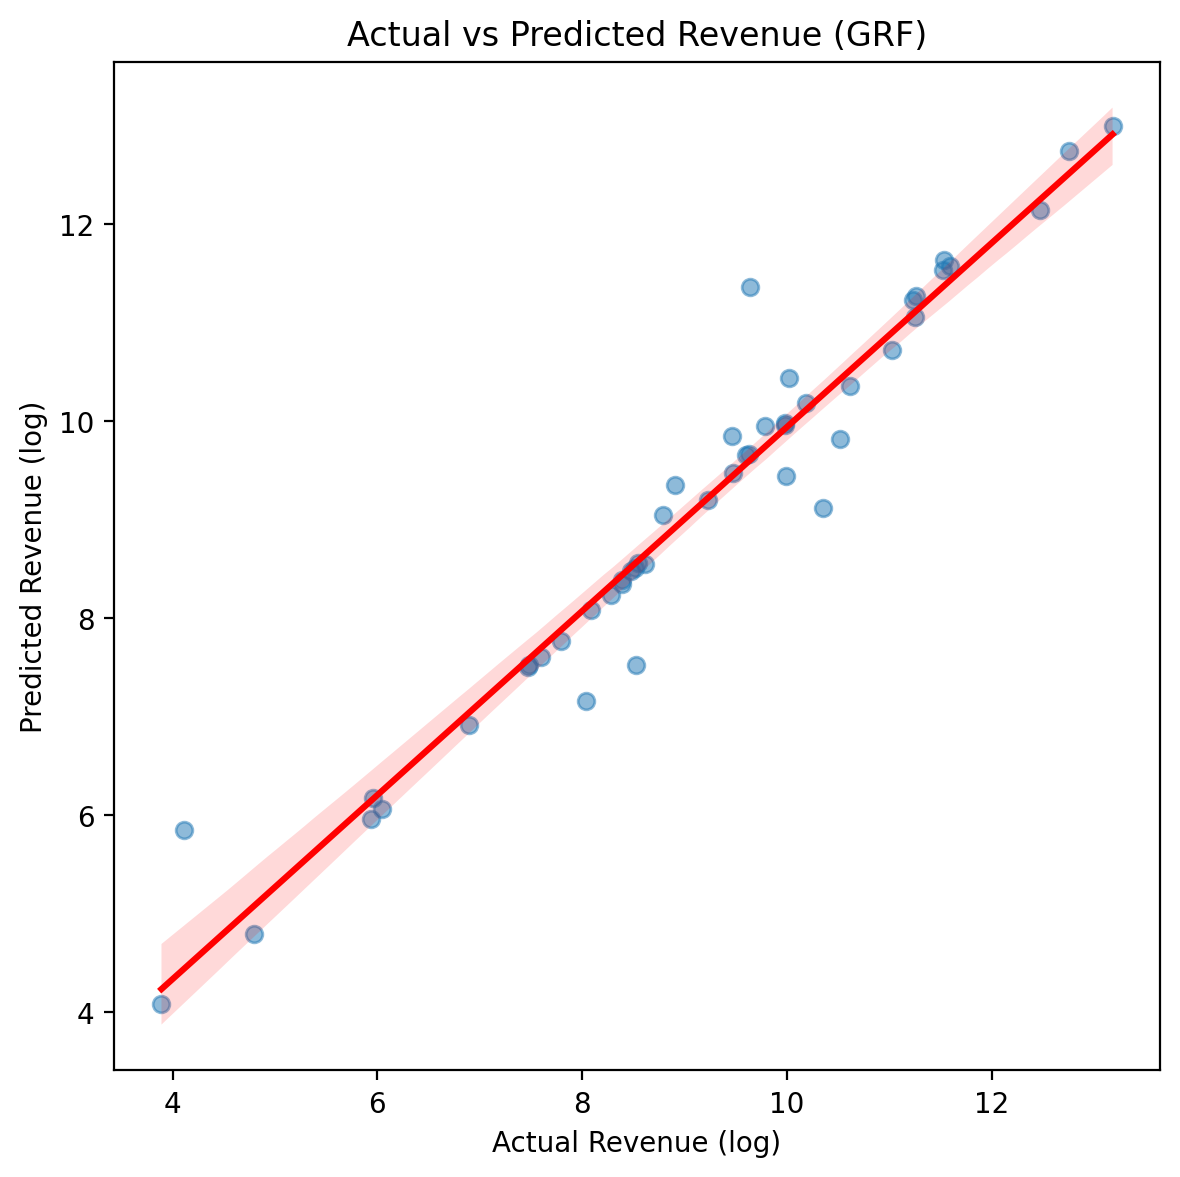

In [60]:
plt.figure(figsize=(6, 6))
sns.regplot(x=gdf.loc[valid_mask, target],
            y=gdf.loc[valid_mask, "grf_prediction"],
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5})

plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.title("Actual vs Predicted Revenue (GRF)")
plt.grid(False)
plt.tight_layout()
plt.show()

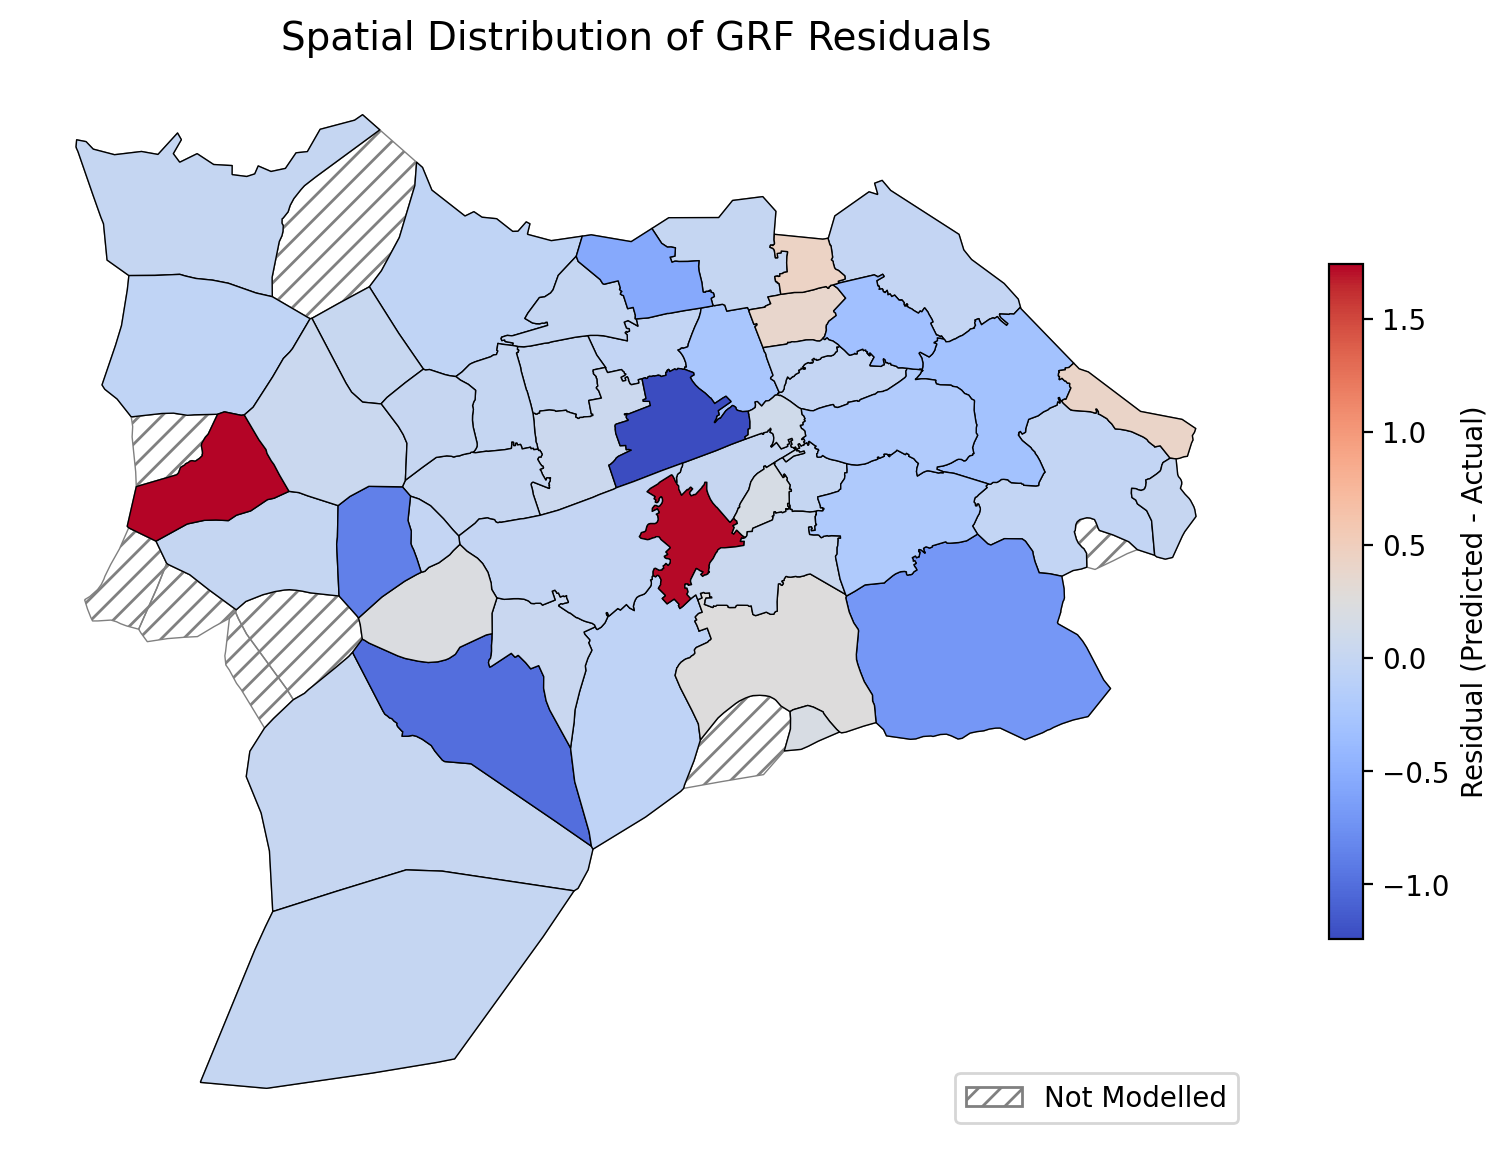

In [61]:
gdf["grf_residual"] = gdf["grf_prediction"] - gdf[target]

# Filter valid predictions
gdf_valid = gdf[valid_mask]

# Create shared figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# --- Baselayer: all boundaries with hatch for unmodelled areas ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# --- Residuals map ---
gdf_valid.plot(
    ax=ax,
    column="grf_residual",
    cmap="coolwarm",
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={
        'label': "Residual (Predicted - Actual)",
        'shrink': 0.6
    },
    zorder=1
)

# --- Final styling ---
hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
ax.legend(handles=[hatch_patch], loc='lower right')

ax.set_title("Spatial Distribution of GRF Residuals", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

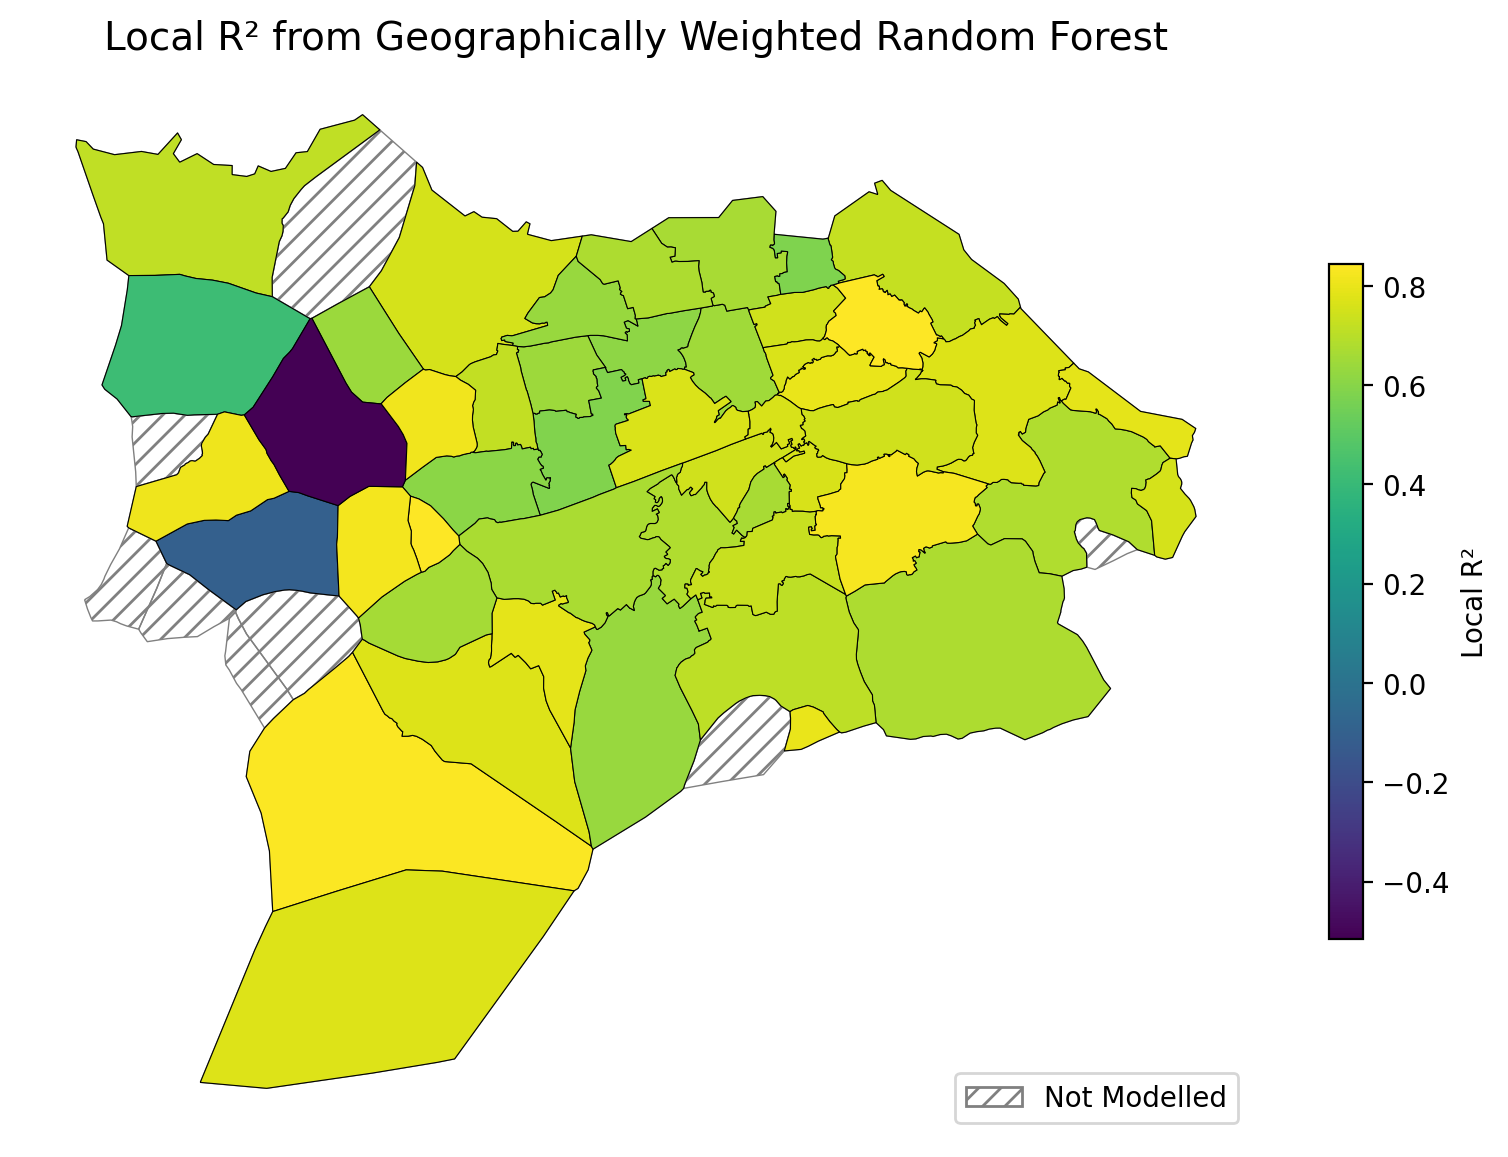

In [62]:
# Filter to valid R² values
gdf_valid_r2 = gdf_valid[gdf_valid["grf_local_r2"].notna()]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# --- Baselayer ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# --- R² choropleth ---
gdf_valid_r2.plot(
    ax=ax,
    column="grf_local_r2",
    cmap="viridis",
    edgecolor="black",
    linewidth=0.4,
    legend=True,
    legend_kwds={
        'label': "Local R²",
        'shrink': 0.6,
        'orientation': "vertical"
    },
    zorder=1  # On top
)

hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
ax.legend(handles=[hatch_patch], loc='lower right')
# --- Styling ---
ax.set_title("Local R² from Geographically Weighted Random Forest", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

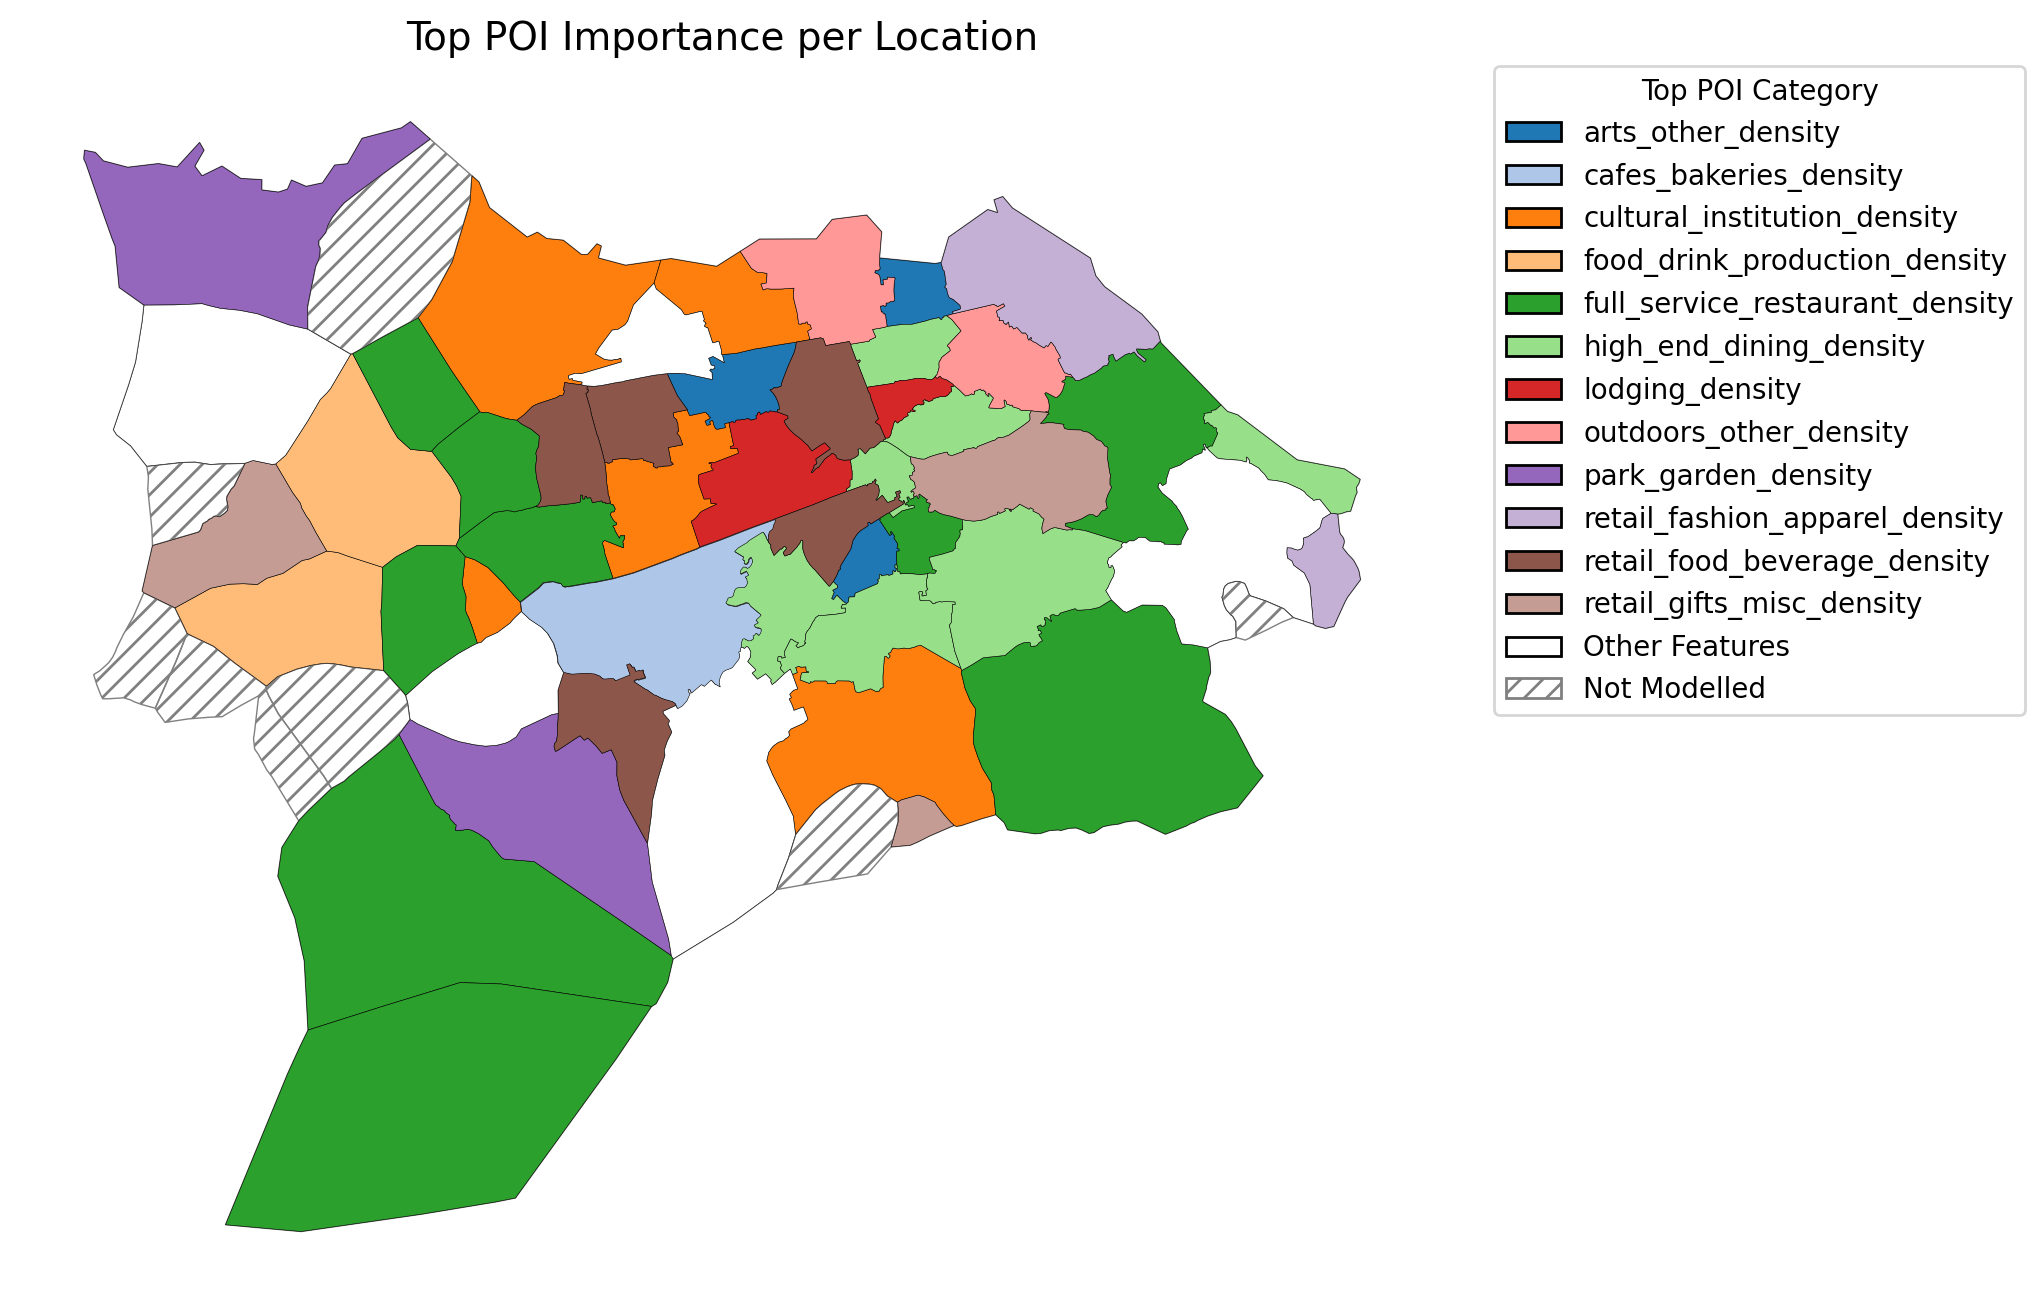

In [63]:
# --- Step 0: Prepare GeoDataFrame ---
gdf_valid = gdf[valid_mask].copy()  # Ensure gdf_valid is up to date

# --- Step 1: Define top N POI features to highlight ---
top_n = 12
top_pois = (
    gdf_valid["top_poi_clean"]
    .value_counts()
    .nlargest(top_n)
    .index.tolist()
)

# --- Step 2: Assign "Other Features" to less frequent ones ---
gdf_valid["top_poi_plot"] = gdf_valid["top_poi_clean"].where(
    gdf_valid["top_poi_clean"].isin(top_pois),
    "Other Features"
)

# --- Step 3: Build color map ---
unique_pois = sorted(set(top_pois))
unique_pois.append("Other Features")

colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois) - 1:
    colors += colors  # Ensure enough colors

poi_color_map = dict(zip(unique_pois[:-1], colors[:len(unique_pois) - 1]))
poi_color_map["Other Features"] = "white"

# --- Step 4: Create figure and axis ---
fig, ax = plt.subplots(figsize=(10, 8))

# --- Step 5: Plot full Edinburgh shapefile as base (hatch for non-modeled) ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# --- Step 6: Plot colored GRF results ---
for poi, color in poi_color_map.items():
    subset = gdf_valid[gdf_valid["top_poi_plot"] == poi]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)

# --- Step 7: Add legend ---
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois
]

# Add legend entry for hatch
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

ax.legend(
    handles=legend_elements,
    title="Top POI Category",
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.
)

# --- Step 8: Finalize map ---
plt.title("Top POI Importance per Location", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Guest Density

In [64]:
# Set CRS
gdf = edinburgh_airbnb_tourism_fs.to_crs(epsg=27700) 

# Get coordinates matrix
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Target variable and predictors
target = "total_tourism_intensity_km2_log"
X_cols = features_logged

In [65]:
# --- Parameters ---
k_neighbours = 50            # Step 1: How many neighbours to use for each local model
min_local_data = 10         # Step 2: Minimum required valid observations for local fitting

# --- Build spatial index ---
# Step 3: Extract centroid coordinates for each spatial unit
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in gdf.geometry])

# Step 4: Build a KD-Tree for fast nearest-neighbour queries
tree = cKDTree(coords)

# --- Outputs ---
# Step 5: Prepare lists to store model results
predictions = []                # Store predicted values at each location
local_r2s = []                  # Store local R² values
feature_importance_list = []   # Store feature importance vectors

# --- Loop through each location ---
# Step 6: Loop over every spatial unit (polygon)
for i, point in enumerate(coords):
    # Step 7: Find k nearest neighbours around the focal point
    distances, indices = tree.query(point, k=k_neighbours)
    raw_local_data = gdf.iloc[indices]

    # Step 8: Remove neighbours that have missing values in predictors or target
    local_data = raw_local_data.dropna(subset=[target] + X_cols)

    # Step 9: If not enough valid data, skip this location
    if len(local_data) < min_local_data:
        predictions.append(np.nan)
        local_r2s.append(np.nan)
        feature_importance_list.append([np.nan] * len(X_cols))
        continue

    # Step 10: Get distances only for valid neighbours
    valid_idx_mask = raw_local_data.index.isin(local_data.index)
    valid_distances = distances[valid_idx_mask]

    # Step 11: Extract predictor and target matrices
    X_local = local_data[X_cols].values
    y_local = local_data[target].values

    # Step 12: Compute bisquare weights for valid neighbours
    D = valid_distances.max()
    weights = (1 - (valid_distances / D) ** 2) ** 2
    weights[valid_distances >= D] = 0

    # Step 13: Normalize weights into probabilities for sampling
    prob = weights / weights.sum()

    # Step 14: Sample with replacement using weights — spatial bootstrap
    sample_idx = np.random.choice(len(X_local), size=len(X_local), p=prob,
                                  replace=True)
    X_weighted = X_local[sample_idx]
    y_weighted = y_local[sample_idx]

    # Step 15: Train local random forest on spatially weighted data
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_weighted, y_weighted)

    # Step 16: Evaluate model R² on *original* local data (not weighted)
    y_local_pred = rf.predict(X_local)
    r2_local = r2_score(y_local, y_local_pred)
    local_r2s.append(r2_local)

    # Step 17: Predict the target value at the focal location itself
    X_pred = gdf.iloc[[i]][X_cols].values
    pred = rf.predict(X_pred)[0]
    predictions.append(pred)

    # Step 18: Save feature importances for this local model
    feature_importance_list.append(rf.feature_importances_)

    # Step 19: Print progress
    if i % 50 == 0:
        print(f"Processed {i}/{len(gdf)} points")

# --- Store predictions, R², and feature importances ---
# Step 20: Add prediction and R² columns to the GeoDataFrame
gdf["grf_prediction"] = predictions
gdf["grf_local_r2"] = local_r2s

# Step 21: Convert list of feature importance arrays into a DataFrame and merge
importances_df = pd.DataFrame(feature_importance_list,
                              columns=[f"{col}_importance" for col in X_cols])
gdf = gdf.join(importances_df)

# --- Identify top feature per location ---
# Step 22: Find the feature with the highest importance at each location
importance_cols = [f"{col}_importance" for col in X_cols]
importance_only = gdf[importance_cols]

# Step 23: Get the name of the most important POI for each polygon
gdf["top_poi"] = importance_only.idxmax(axis=1)

# Step 24: Clean up the POI column names for readability
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_density_log_importance", "",
                                                  regex=False)
gdf["top_poi_clean"] = gdf["top_poi"].str.replace("_log_importance", "",
                                                  regex=False)

Processed 0/55 points
Processed 50/55 points


In [66]:
# Mask for valid (non-missing) rows
valid_mask = gdf["grf_prediction"].notna() & gdf[target].notna()

# Extract valid predictions and true values (log scale)
y_true_log = gdf.loc[valid_mask, target]
y_pred_log = gdf.loc[valid_mask, "grf_prediction"]

# ---- Log-scale metrics ----
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)
r2 = r2_score(y_true_log, y_pred_log)

# ---- Original-scale metrics ----
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)

rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)

# ---- Print all metrics ----
print("GRF Evaluation Metrics")
print("-----------------------")
print(f"R² (log scale): {r2:.3f}")
print(f"RMSE (log scale): {rmse_log:.3f}")
print(f"MAE  (log scale): {mae_log:.3f}")
print(f"RMSE (original scale): {rmse_orig:,.2f}")
print(f"MAE  (original scale): {mae_orig:,.2f}")

GRF Evaluation Metrics
-----------------------
R² (log scale): 0.952
RMSE (log scale): 0.416
MAE  (log scale): 0.233
RMSE (original scale): 16.42
MAE  (original scale): 8.61


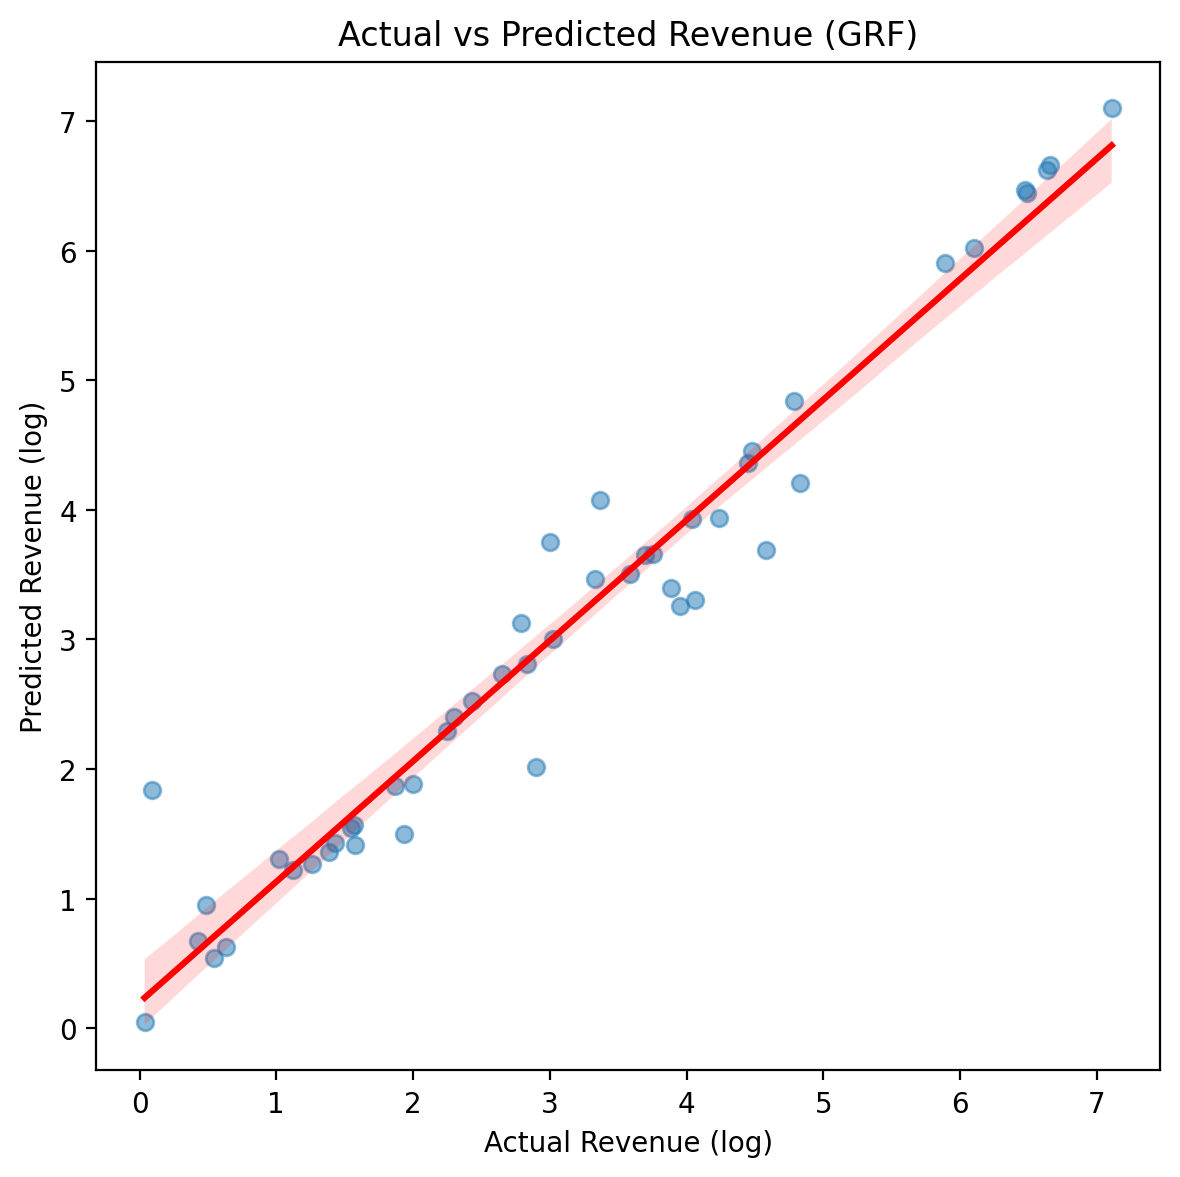

In [67]:
plt.figure(figsize=(6, 6))
sns.regplot(x=gdf.loc[valid_mask, target],
            y=gdf.loc[valid_mask, "grf_prediction"],
            line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5})

plt.xlabel("Actual Revenue (log)")
plt.ylabel("Predicted Revenue (log)")
plt.title("Actual vs Predicted Revenue (GRF)")
plt.grid(False)
plt.tight_layout()
plt.show()

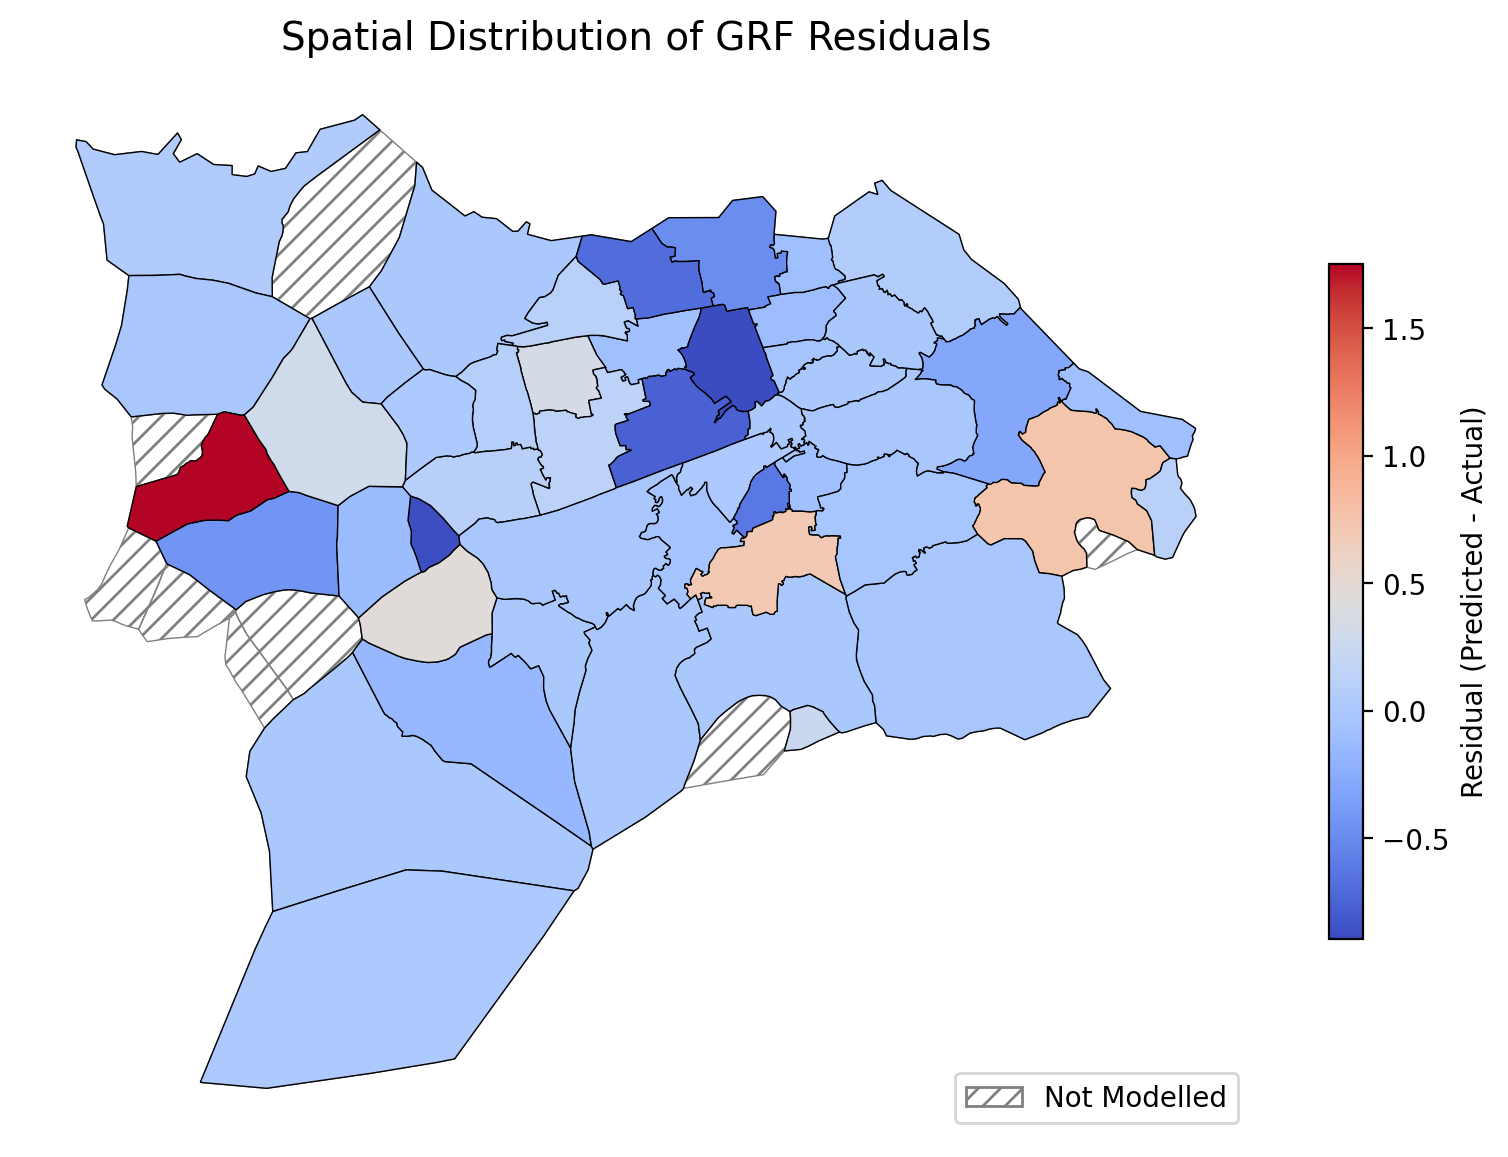

In [68]:
gdf["grf_residual"] = gdf["grf_prediction"] - gdf[target]

# Filter valid predictions
gdf_valid = gdf[valid_mask]

# Create shared figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# --- Baselayer: all boundaries with hatch for unmodelled areas ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# --- Residuals map ---
gdf_valid.plot(
    ax=ax,
    column="grf_residual",
    cmap="coolwarm",
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    legend_kwds={
        'label': "Residual (Predicted - Actual)",
        'shrink': 0.6
    },
    zorder=1
)

# --- Final styling ---
hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
ax.legend(handles=[hatch_patch], loc='lower right')

ax.set_title("Spatial Distribution of GRF Residuals", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

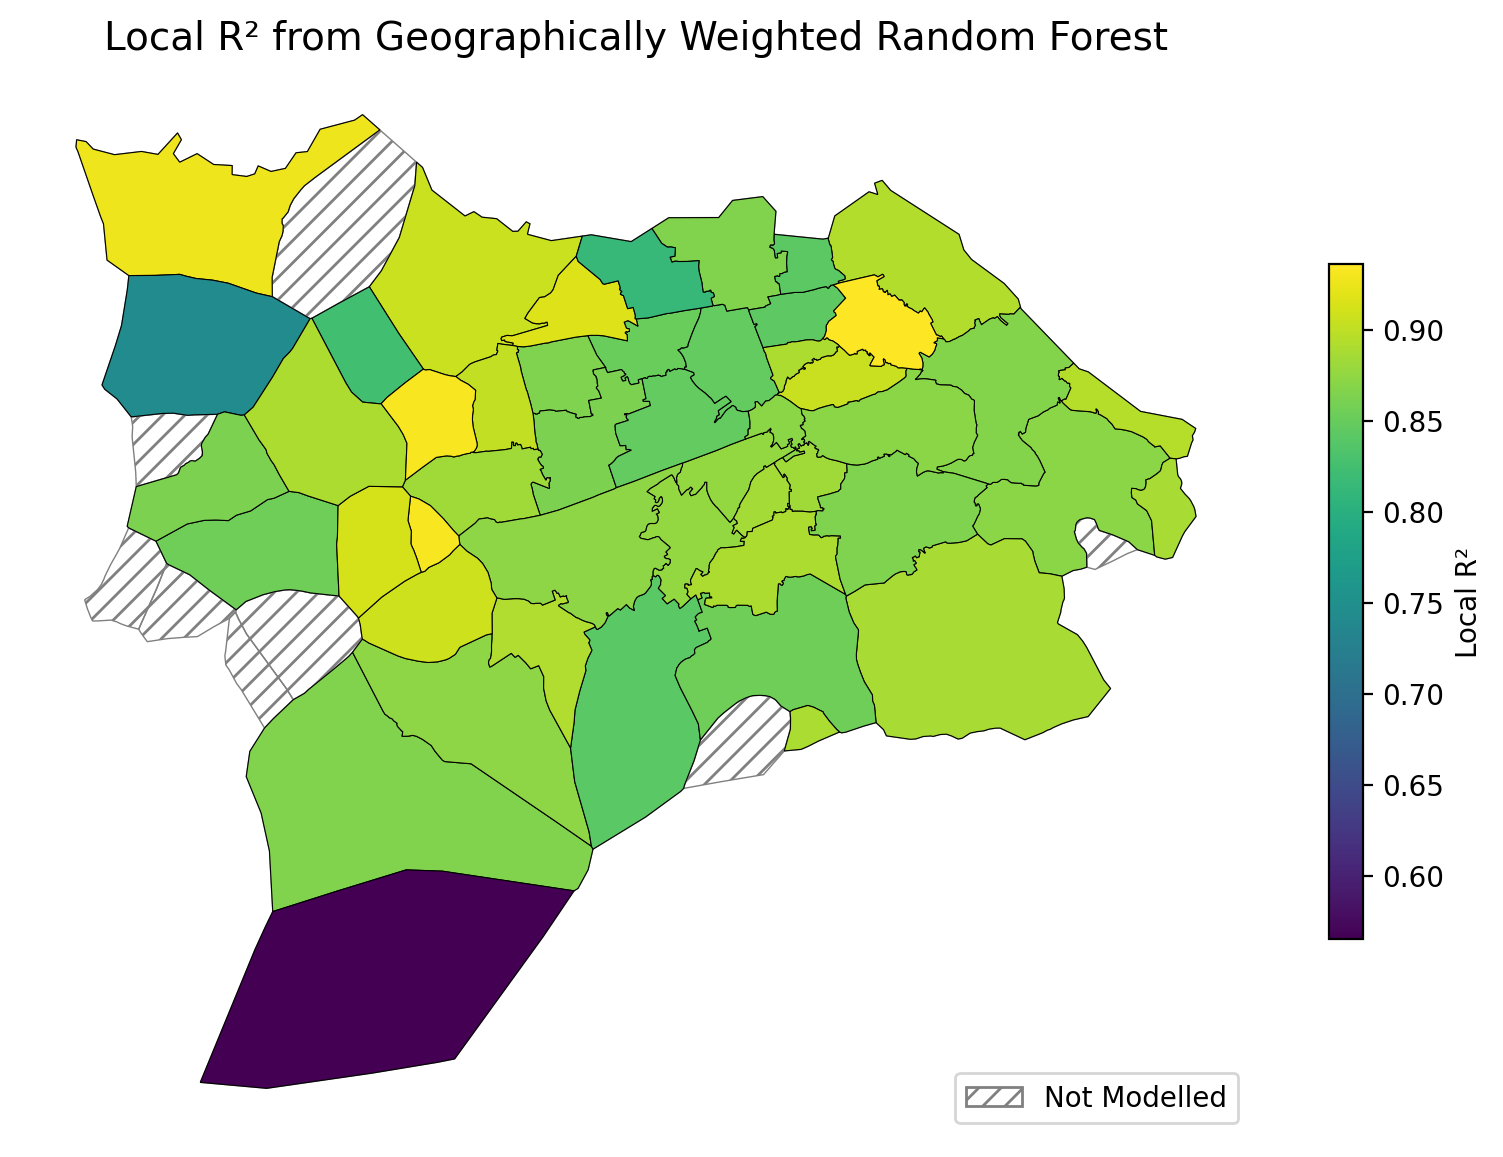

In [69]:
# Filter to valid R² values
gdf_valid_r2 = gdf_valid[gdf_valid["grf_local_r2"].notna()]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# --- Baselayer ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# --- R² choropleth ---
gdf_valid_r2.plot(
    ax=ax,
    column="grf_local_r2",
    cmap="viridis",
    edgecolor="black",
    linewidth=0.4,
    legend=True,
    legend_kwds={
        'label': "Local R²",
        'shrink': 0.6,
        'orientation': "vertical"
    },
    zorder=1  # On top
)

hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
ax.legend(handles=[hatch_patch], loc='lower right')
# --- Styling ---
ax.set_title("Local R² from Geographically Weighted Random Forest", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_16269/134628884.py:46: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)


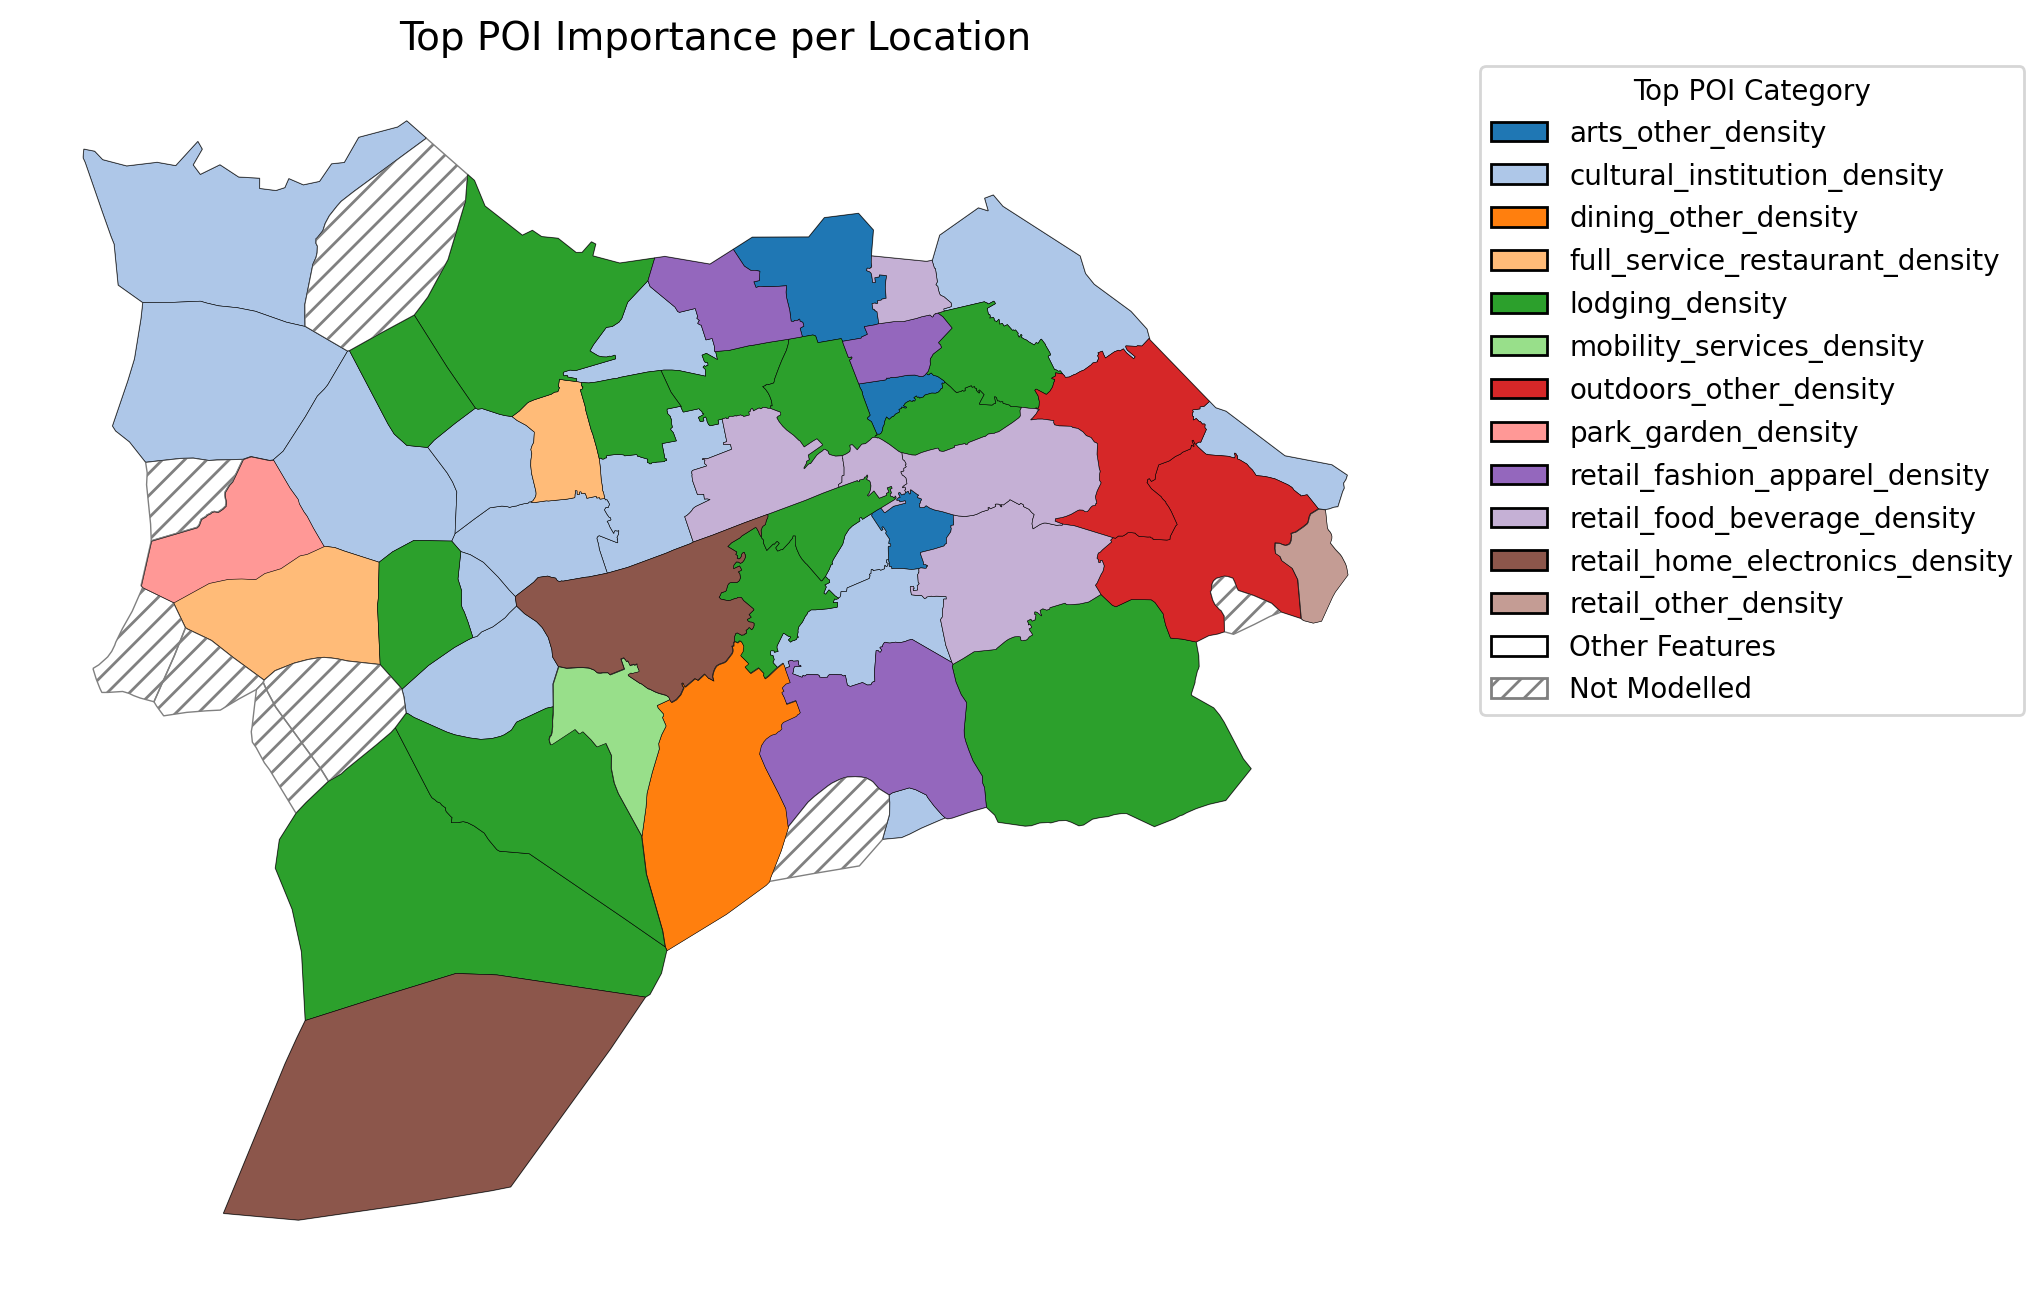

In [70]:
# --- Step 0: Prepare GeoDataFrame ---
gdf_valid = gdf[valid_mask].copy()  # Ensure gdf_valid is up to date

# --- Step 1: Define top N POI features to highlight ---
top_n = 12
top_pois = (
    gdf_valid["top_poi_clean"]
    .value_counts()
    .nlargest(top_n)
    .index.tolist()
)

# --- Step 2: Assign "Other Features" to less frequent ones ---
gdf_valid["top_poi_plot"] = gdf_valid["top_poi_clean"].where(
    gdf_valid["top_poi_clean"].isin(top_pois),
    "Other Features"
)

# --- Step 3: Build color map ---
unique_pois = sorted(set(top_pois))
unique_pois.append("Other Features")

colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois) - 1:
    colors += colors  # Ensure enough colors

poi_color_map = dict(zip(unique_pois[:-1], colors[:len(unique_pois) - 1]))
poi_color_map["Other Features"] = "white"

# --- Step 4: Create figure and axis ---
fig, ax = plt.subplots(figsize=(10, 8))

# --- Step 5: Plot full Edinburgh shapefile as base (hatch for non-modeled) ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# --- Step 6: Plot colored GRF results ---
for poi, color in poi_color_map.items():
    subset = gdf_valid[gdf_valid["top_poi_plot"] == poi]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)

# --- Step 7: Add legend ---
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois
]

# Add legend entry for hatch
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

ax.legend(
    handles=legend_elements,
    title="Top POI Category",
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.
)

# --- Step 8: Finalize map ---
plt.title("Top POI Importance per Location", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()